 <font size="6">Генерация и отбор признаков</font>


# Проблемы при работе с реальными данными

В реальных задачах вы столкнетесь с широким спектром трудностей, и одним из первых этапов будет подготовка данных. Уже на этом этапе есть ряд возможных проблем, например:

- **Нехватка данных** — у вас может быть мало данных. Более того, понять, какой объем данных необходим — тоже отдельная задача. Другая вариация похожей проблемы — это большой объем данных, но без разметки.

- **Некачественная разметка** —  даже в широко известных MNIST, CIFAR-10 и ImageNet есть [ошибки в разметке 🎮[demo]](https://labelerrors.com/). В вашем датасете они тоже будут. Важно понимать, что разметка может не являться бесспорным эталоном.

- **Шум в данных** — полезно подумать о потенциальной зашумленности данных. Например, когда люди заполняют таблицы, они могут допускать ошибки. Хорошо понимать, какого рода ошибки могут содержаться в ваших данных.

- **Несбалансированность датасета** — какие-то классы могут быть плохо представлены (**минорные классы**). Например, если в вашем датасете будет всего 10 фотографий одного класса и 10 000 другого, то модели будет очень заманчиво вообще не пытаться определять минорный класс (всего 0.1% ошибок).

- **Ковариантный сдвиг** — явление, когда признаки тренировочной и тестовой выборок **распределены по-разному**. Из-за этого мы можем получать плохие предсказания на тестовой выборке, когда модель просто не знает, что признаки могут находиться в другом распределении.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/covariate_shift.png" width="600">

*Практический совет: для быстрого обнаружения ковариантного сдвига можно **обучить модель**, которая будет предсказывать, относится ли объект к **train** или **test** выборке. Если модель легко делит данные по такому принципу, то имеет смысл визуализировать значения признаков, по которым она это делает.*

- **Малое число источников данных** — проблема, родственная предыдущей. В вашем датасете могут быть данные только от одного прибора или одной модели прибора. Могут быть данные, снятые только одним специалистом, или в одной больнице, или только у взрослых. Это также может влиять на способность вашего алгоритма обобщать полученное решение и требует пристального внимания.

- **Грязные данные** — в данных могут быть полные/неполные дубликаты, пропуски, ошибки форматов, перемешанные столбцы и многое другое. Такие проблемы могут быть как естественной характеристикой (нет данных о каких-то объектах, отсюда пропуски), так и ошибкой при агрегации данных из разных источников. Важно подумать о проверках и тестах, чтобы быть уверенным в качестве.

Все это приводит к целому спектру сложностей, из которых самой типичной будет переобучение модели — какую бы простую модель вы не взяли, она все равно будет выучивать искажения вашего датасета.

## Дисбаланс классов

Прежде всего надо убедиться, что датасет сбалансирован:

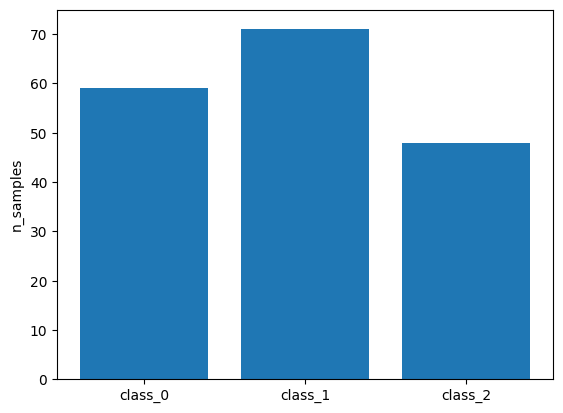

In [ ]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine


def show_class_balance(y, classes):
    _, counts = torch.unique(torch.tensor(y), return_counts=True)
    plt.bar(classes, counts)
    plt.ylabel("n_samples")
    plt.ylim([0, 75])
    plt.show()


wine = load_wine()
classes = wine.target_names

show_class_balance(wine.target, classes)

Разница в 10–20% будет незначительна, поэтому для наглядности мы искусственно разбалансируем наш датасет при помощи метода `make_imbalance` [🛠️[doc]](https://imbalanced-learn.org/stable/references/generated/imblearn.datasets.make_imbalance.html) из библиотеки [imbalanced-learn 🛠️[doc]](https://imbalanced-learn.org/stable/).

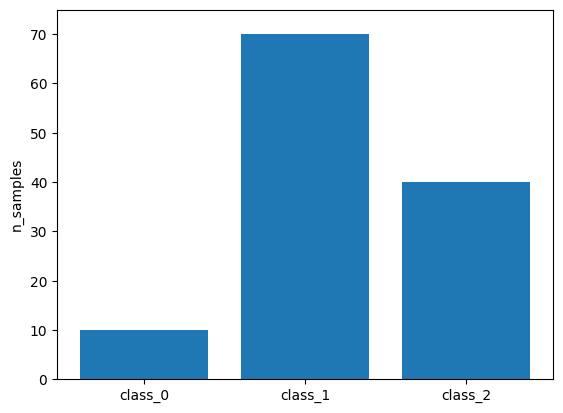

In [ ]:
from imblearn.datasets import make_imbalance

x, y = make_imbalance(
    wine.data, wine.target, sampling_strategy={0: 10, 1: 70, 2: 40}, random_state=42
)
show_class_balance(y, classes)

### Изменение баланса класса сэмплированием

Если в данных нехватка именно конкретного класса, то можно бороться с этим при помощи разных способов сэмплирования.

Важно понимать, что в большинстве случаев данные, полученные таким способом, должны использоваться в качестве **обучающего набора**, но ни в коем случае не в качестве **валидации** или **теста**.


#### Дублирование примеров меньшего класса (oversampling)

Мы можем увеличить число объектов меньшего класса за счет дублирования.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/oversampling_scheme.png" width="600"></center>

<center><em>Дублирование примеров меньшего класса</em></center>



Такой oversampling может быть выполнен с помощью класса `RandomOverSampler` [🛠️[doc]](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html) из imbalanced-learn, как показано ниже:

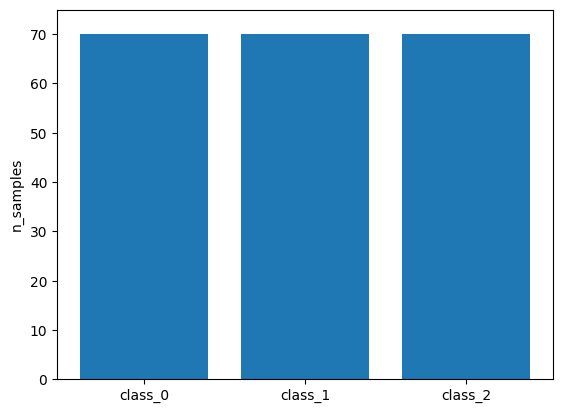

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=0)
x_ros, y_ros = ros.fit_resample(x, y)

show_class_balance(y_ros, classes)

#### Уменьшение числа примеров большего класса (undersampling)

Аналогично, можно взять для обучения не всех представителей большего класса.

<center><img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/undersampling_scheme.png" width="600"></center>

<center><em>Удаление примеров преобладающего класса</em></center>

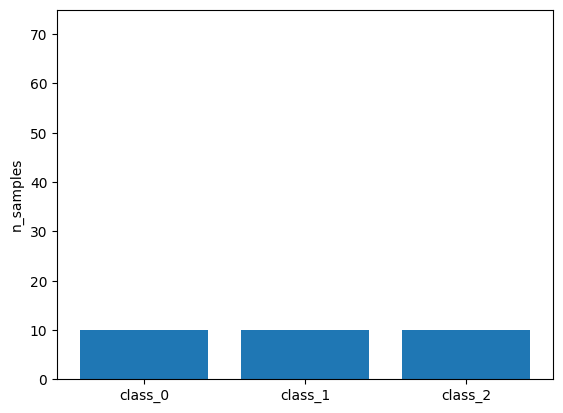

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)
x_res, y_res = rus.fit_resample(x, y)

show_class_balance(y_res, classes)

Минус подхода: мы можем выбросить важных представителей большего класса, ответственных за существенное улучшение генерализации, и из-за этого качество модели существенно ухудшится.

Выбрасывать объекты большего класса  можно разными способами. Например, кластеризовать объекты большего класса и брать по заданному количеству объектов из каждого класса.

#### Ансамбли + undersampling

Можно использовать ансамбли вместе с undersampling. В этом случае мы можем, к примеру, делать сэмплирование только большего класса, а объекты минорного класса оставлять как есть.

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/ensembles_and_undersampling.png" width="700px">

Или просто сэмплировать объекты и того, и другого класса в равном количестве.

### Генерация синтетических данных

Другой подход к решению этой проблемы — создание синтетических данных.



#### SMOTE

**Synthetic Minority Over-sampling Technique (SMOTE)** позволяет генерировать синтетические данные за счет реальных объектов из минорного класса.

Алгоритм работает следующим образом:

1. Для случайной точки из минорного класса выбираем $k$ ближайших соседей из того же класса.
2. Для первого соседа проводим отрезок, соединяющий его и выбранную точку. На этом отрезке случайно выбираем точку.
3. Эта точка — новый **синтетический** объект минорного класса.
4. Повторяем процедуру для оставшихся соседей.


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/generate_synthetic_data.png" width="700">

Число соседей, как и число раз, которое мы запускаем описанную выше процедуру, можно регулировать.

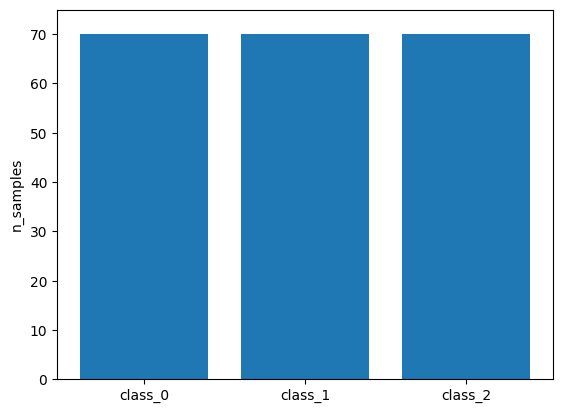

In [ ]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
x_smote, y_smote = oversample.fit_resample(x, y)

show_class_balance(y_smote, classes)

Количество объектов каждого класса, которое должно получиться после генерации, можно задать явно:

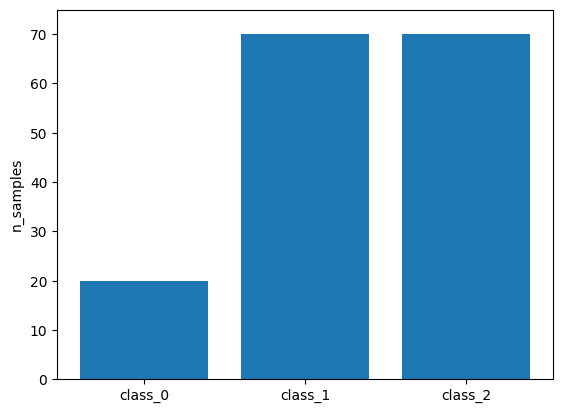

In [ ]:
over = SMOTE(sampling_strategy={0: 20, 1: 70, 2: 70})
x_smote, y_smote = over.fit_resample(x, y)

show_class_balance(y_smote, classes)

[[blog] ✏️ SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/) — подробнее про использование пакета.

### Метрики качества на несбалансированных данных

Обращайте внимание на то, какие метрики вы используете. При решении задачи классификации часто используется accuracy (точность), равная доле правильно классифицированных объектов. Эта метрика позволяет адекватно оценить результат классификации в случае сбалансированных классов. В случае дисбаланса классов данная метрика может выдать обманчиво хороший результат.

Пример: датасет, в котором 95% объектов относятся к классу 0 и 5% к классу 1.

Class distribution  Counter({0: 950, 1: 50})


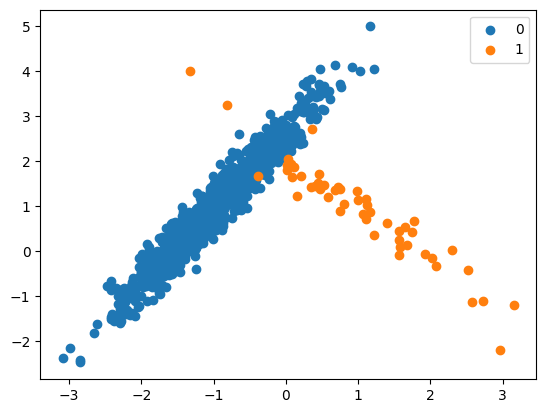

In [ ]:
from sklearn.datasets import make_classification
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt


x, y = make_classification(
    n_samples=1000,
    n_features=2,
    n_redundant=0,
    n_clusters_per_class=1,
    weights=[0.95],
    flip_y=0,
    random_state=42,
)

counter = Counter(y)
print("Class distribution ", Counter(y))

for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    plt.scatter(x[row_ix, 0], x[row_ix, 1], label=str(label))
plt.legend()
plt.show()

И модель, которая для всех данных выдает класс 0:

In [ ]:
class DummyModel:
    def predict(self, x):
        return np.zeros(x.shape[0])  # always predict class 0

Такая модель будет иметь $accuracy = 0.95$, хотя не выдает никакой полезной информации:



In [ ]:
from sklearn.metrics import accuracy_score

dummy_model = DummyModel()
y_pred = dummy_model.predict(x)

accuracy = accuracy_score(y, y_pred)
print("Accuracy", accuracy)

Accuracy 0.95


Для несбалансированных данных лучше выбирать [F1 Score 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score),  [MCC 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html?highlight=matthews%20correlation%20coefficient#sklearn.metrics.matthews_corrcoef) (Matthews correlation coefficient, коэффициент корреляции Мэтьюса) или [balanced accuracy 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score) (среднее между recall разных классов).

In [ ]:
from sklearn.metrics import f1_score, matthews_corrcoef, balanced_accuracy_score

print("F1", f1_score(y, y_pred))
print("MCC", matthews_corrcoef(y, y_pred))
print("Balanced accuracy", balanced_accuracy_score(y, y_pred))

F1 0.0
MCC 0.0
Balanced accuracy 0.5


Эти метрики более адекватно оценивают качество модели при наличии дисбаланса классов, и в данном случае отражают отсутствие связи предсказаний с данными на входе модели.

## Обнаружение аномалий

В случае сильно несбалансированных наборов данных стоит задуматься, могут ли такие примеры рассматриваться как аномалия (выброс) или нет. Если такое событие и впрямь может считаться аномальным, мы можем использовать такие модели, как `OneClassSVM`, методы кластеризации или методы обнаружения гауссовских аномалий.

Эти методы требуют изменения взгляда на задачу: мы будем рассматривать аномалии как отдельный класс выбросов. Это может помочь нам найти новые способы разделения и классификации.

Пусть мы хотим отличать фрукты по каким-то признакам, скажем, по форме и цвету, и мы имеем выборку, где много яблок и груш. Задача обнаружения аномалий возникает, если мы предполагаем, что среди яблок и груш может вдруг возникнуть клубника и нам нужно отнести ее не к одному из известных классов, а выделить в отдельный, отличающийся класс.

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/anomaly_fruits.png" width="800"></img>

Проблемой при работе с аномалиями является то, что аномальных значений может быть очень мало или вообще не быть. В таком случае алгоритм учит паттерны нормального поведения и реагирует на отличия от паттернов.

Разберем примеры обнаружения аномалий с помощью трех алгоритмов из библиотеки Scikit-Learn (там можно найти еще много различных алгоритмов).

Создадим датасет из двух кластеров и случайных значений.

In [ ]:
import numpy as np

rng = np.random.RandomState(42)

# Train
x = 0.3 * rng.randn(100, 2)  # 100 2D points
x_train = np.r_[x + 2, x - 2]  # split into two clusters

# Test norlmal
x = 0.3 * rng.randn(20, 2)  # 20 2D points
x_test_normal = np.r_[x + 2, x - 2]  # split into two clusters

# Test outliers
x_test_outliers = rng.uniform(low=-4, high=4, size=(20, 2))

Напишем функцию визуализации, которая будет изображать созданный датасет на рисунке слева, а результат поиска аномалий — на рисунке справа.

In [ ]:
def plot_outliers(x_train, x_test_normal, x_test_outliers, model=None):
    fig, (plt_data, plt_model) = plt.subplots(1, 2, figsize=(12, 6))

    plt_data.set_title("Created Dataset (real labels)")
    plot_train = plt_data.scatter(
        x_train[:, 0], x_train[:, 1], c="white", s=40, edgecolor="k"
    )
    plot_test_normal = plt_data.scatter(
        x_test_normal[:, 0], x_test_normal[:, 1], c="green", s=40, edgecolor="k"
    )
    plot_test_outliers = plt_data.scatter(
        x_test_outliers[:, 0], x_test_outliers[:, 1], c="red", s=40, edgecolor="k"
    )

    plt_data.set_xlim((-5, 5))
    plt_data.set_ylim((-5, 5))

    plt_data.legend(
        [plot_train, plot_test_normal, plot_test_outliers],
        ["train", "test normal", "test outliers"],
        loc="lower right",
    )

    if model:
        plt_model.set_title("Model Results")
        # plot decision function
        xx, yy = np.meshgrid(np.linspace(-5, 5, 50), np.linspace(-5, 5, 50))
        Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        plt_model.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)

        # plot prediction
        full_data = np.concatenate((x_train, x_test_normal, x_test_outliers), axis=0)
        predicted = model.predict(full_data)

        anom_index = np.where(predicted == -1)
        anom_values = full_data[anom_index]

        plot_all_data = plt_model.scatter(
            full_data[:, 0], full_data[:, 1], c="white", s=40, edgecolor="k"
        )

        plot_anom_data = plt_model.scatter(
            anom_values[:, 0], anom_values[:, 1], c="red", s=40, marker="x"
        )
        plt_model.legend(
            [plot_all_data, plot_anom_data],
            ["normal", "outliers"],
            loc="lower right",
        )
    plt.show()

Посмотрим, как работает на этих данных алгоритм [OneClassSVM 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html).

Идея алгоритма состоит в поиске функции, которая положительна для областей с высокой плотностью и отрицательна для областей с малой плотностью.

Подробнее об алгоритме:

[[article] 🎓 Support Vector Method for Novelty Detection](https://proceedings.neurips.cc/paper/1999/file/8725fb777f25776ffa9076e44fcfd776-Paper.pdf)



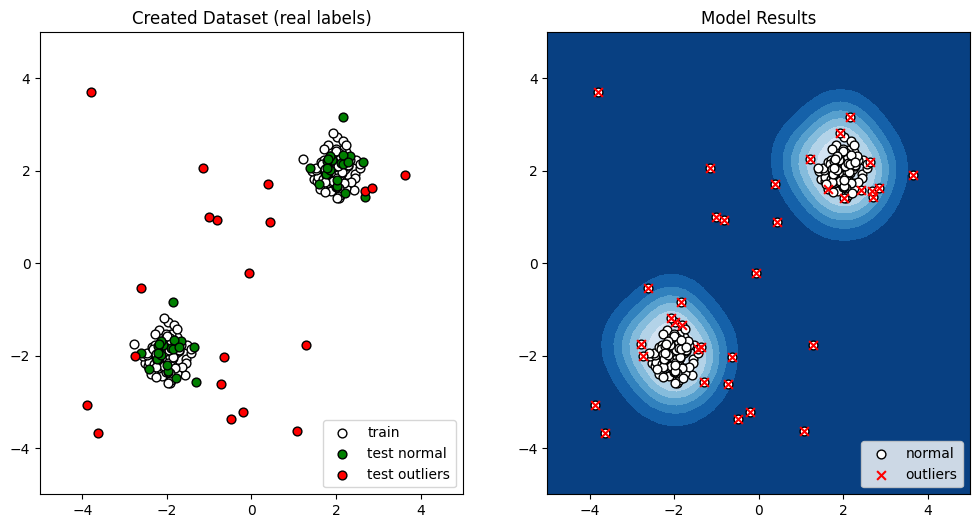

In [ ]:
from sklearn.svm import OneClassSVM

gamma = 2.0  # Kernel coefficient
contamination = 0.05  # threshold

model = OneClassSVM(gamma=gamma, kernel="rbf", nu=contamination)
model.fit(x_train)

plot_outliers(x_train, x_test_normal, x_test_outliers, model)

Посмотрим, как на этих же данных работает алгоритм [Isolation Forest 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html).

Isolation Forest состоит из деревьев, которые «изолируют» (пытаются отделить от остальной выборки) наблюдения, случайным образом выбирая признак и случайное значение порога для этого признака (между max и min значениями признака). Такой алгоритм чаще и проще отделяет значения аномалий. Если построить по такому принципу множество деревьев, то значения, которые чаще других отделяются раньше, будут аномалиями.

На практике часто используют более продвинутую версию [Extended Isolation Forest
🐾[git]](https://github.com/sahandha/eif).


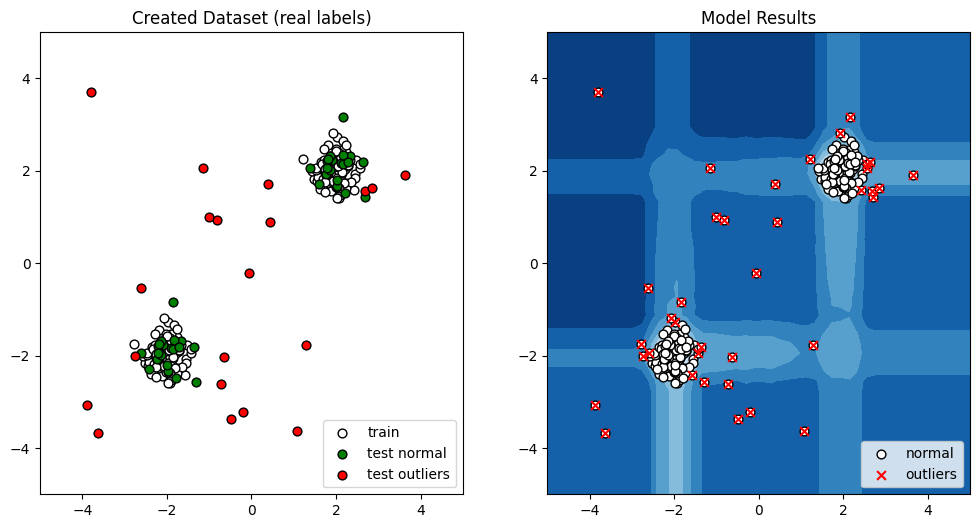

In [ ]:
from sklearn.ensemble import IsolationForest

n_estimators = 200
contamination = 0.05  # threshold

model = IsolationForest(
    n_estimators=n_estimators, contamination=contamination, random_state=rng
)
model.fit(x_train)

plot_outliers(x_train, x_test_normal, x_test_outliers, model)

Последним алгоритмом, на который мы посмотрим, будет [Local Outlier Factor 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

В нем используется метод k-NN. Расстояние до ближайших соседей используется для оценки расположения точек. Если соседи далеко, то точка с большой вероятностью является аномалией.

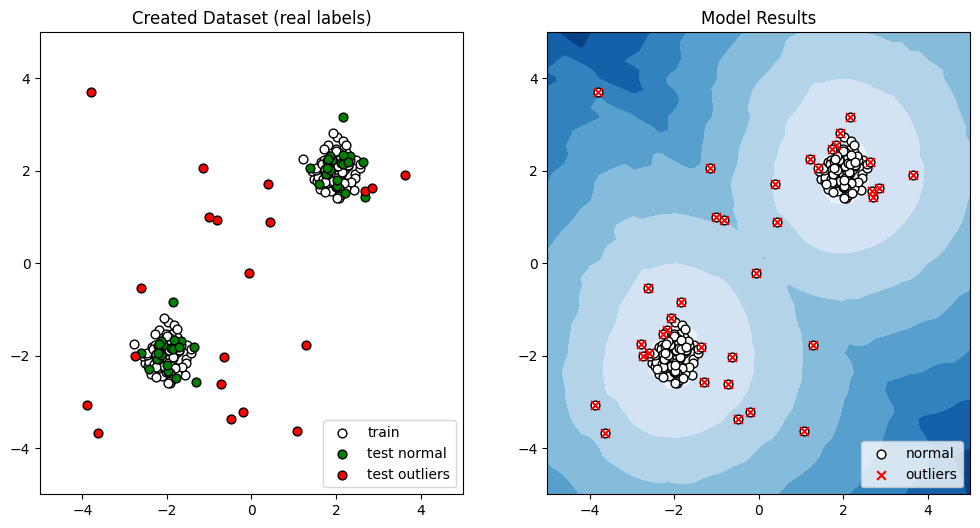

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

n_neighbors = 10
contamination = 0.05  # threshold

model = LocalOutlierFactor(
    n_neighbors=n_neighbors, novelty=True, contamination=contamination
)
model.fit(x_train)

plot_outliers(x_train, x_test_normal, x_test_outliers, model)

### Оценка качества в задаче обнаружения аномалий

Отдельное время стоит посвятить подбору порога для алгоритма.

Порог является граничным значением, выше которого данные считаются аномальными. Выбор порога — это компромиссное решение: слишком низкий порог может привести к ложным срабатываниям, тогда как слишком высокий порог может пропустить аномалии. Поэтому выбор порога напрямую связан с задачей и требованиям к детекции.

Построим матрицы ошибок (Confusion matrix) для разных порогов:


In [ ]:
full_data = np.concatenate((x_train, x_test_normal, x_test_outliers), axis=0)
predicted = model.predict(full_data)

# change threshold to 0.005
model_2 = LocalOutlierFactor(n_neighbors=10, novelty=True, contamination=0.005)
model_2.fit(x_train)
predicted_2 = model_2.predict(full_data)

y_true = np.ones(full_data.shape[0])  # create true labels
y_true[-x_test_outliers.shape[0] :] = -1  # last 20 is anomaly

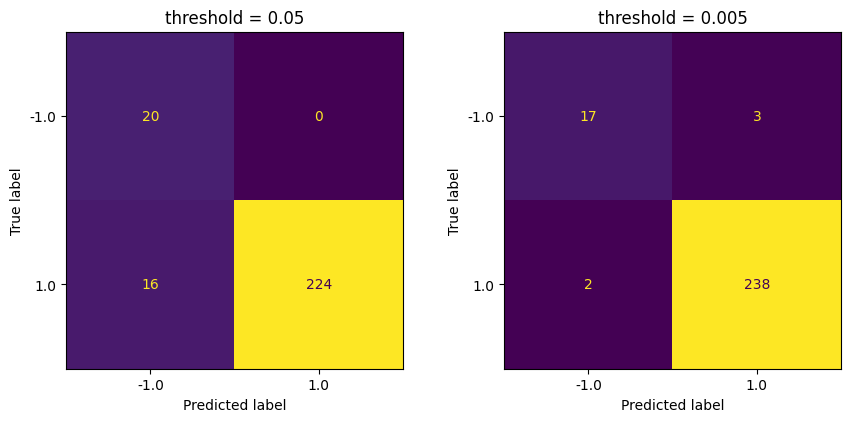

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig = plt.figure(figsize=(10, 6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ConfusionMatrixDisplay.from_predictions(y_true, predicted, ax=ax1, colorbar=False)
ConfusionMatrixDisplay.from_predictions(y_true, predicted_2, ax=ax2, colorbar=False)
ax1.set_title("threshold = 0.05")
ax2.set_title("threshold = 0.005")
plt.subplots_adjust(wspace=0.3)
plt.show()

Еще одна идея улучшения качества детекции аномалий — это агрегация результатов разных алгоритмов, т. е. создание ансамбля.

# Кластеризация

Когда говорят про задачу кластеризации, подразумевают примерно следующее:

У нас есть неразмеченные данные, и мы хотим поделить эти данные по каким-то группам, где в каждой группе будут объекты, похожие друг на друга. Под похожестью как правило понимается выбранная метрика расстояния.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/clustering_task.png" width="700">

Основные цели кластеризации:

* Исследование данных. Мы хотим понять, какие кластеры являются ярко выраженными, и сделать дополнительные выводы о наших данных.

* Нахождение аномалий/выбросов. Мы можем искать объекты, которые сильно отличаются от всех остальных и не принадлежат никакому кластеру.

* Создание дополнительных признаков. Кластер для объекта уже является дополнительным категориальным признаком.

* Непосредственно классификация. Например, можем считать получившиеся кластеры классами и классифицировать объекты таким образом.

Алгоритмов кластеризации существует большое количество, и все работают по-разному, имеют разные параметры для настройки. Мы рассмотрим два наиболее популярных: [K-Means 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) и [DBSCAN 🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html).

<center><img src ="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L04/sphx_glr_plot_cluster_comparison.png" width="800"></center>

<center><em>Source: <a href="https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods"> Overview of clustering methods</a></em></center>

## Алгоритм K-Means

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/kmeans.png" width="750">

1. Выбираем количество кластеров $k$, которое нам кажется оптимальным для наших данных.
2. Определяем начальное положение центроидов кластеров, случайным образом или по какому-либо правилу.
3. Для каждой точки нашего набора данных считаем расстояние до центроидов. Относим точки к ближайшим центроидам.
4. Перемещаем каждый центроид в центр получившихся кластеров.
5. Повторяем шаги 3–4 до тех пор, пока центроиды не перестанут значительно сдвигаться.


[[demo] 🎮 Интерактивная визуализация алгоритма K-Means](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)

Особенности K-Means:

* Сильно зависит от параметра $k$ и начального положения центроидов.
* Кластеры получаются гиперсферическими, с более сложными формами алгоритм не справляется.
* Все точки относятся к какому-то кластеру, явных выбросов нет.



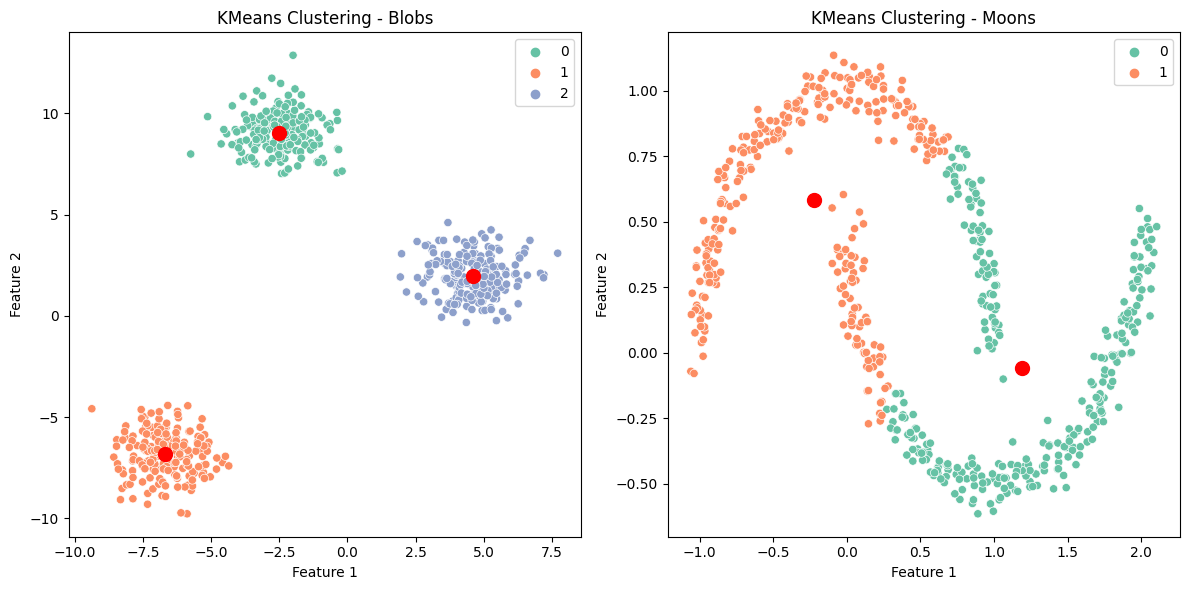

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs, make_moons

x_blobs, _ = make_blobs(n_samples=600, n_features=2, centers=3, random_state=42)
x_moons, _ = make_moons(n_samples=600, noise=0.05, random_state=42)


def plot_kmeans_clustering(ax, data, n_clusters, title):
    kmeans = KMeans(n_clusters=n_clusters, n_init=10)
    kmeans.fit(data)
    kmeans_labels = kmeans.predict(data)

    sns.scatterplot(
        x=data[:, 0], y=data[:, 1], hue=kmeans_labels, palette="Set2", ax=ax
    )
    ax.scatter(
        kmeans.cluster_centers_[:, 0],
        kmeans.cluster_centers_[:, 1],
        s=100,
        c="red",
        marker="o",
    )
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_kmeans_clustering(
    axes[0], x_blobs, n_clusters=3, title="KMeans Clustering - Blobs"
)
plot_kmeans_clustering(
    axes[1], x_moons, n_clusters=2, title="KMeans Clustering - Moons"
)

plt.tight_layout()
plt.show()

## Алгоритм DBSCAN

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/dbscan.png" width="750">

DBSCAN (Density-based spatial clustering of applications with noise, плотностный алгоритм пространственной кластеризации с присутствием шума), как следует из названия, оперирует плотностью данных. На вход требуется матрица близости и два параметра:
1. `eps` — радиус $\varepsilon$-окрестности, в которой мы ищем похожие объекты (радиус кружков на картинке).
2. `min_samples` — количество соседей, которое должен иметь объект, чтобы не быть одиночкой. У нас `min_samples=3`.


Алгоритм выглядит следующим образом:
1. Берем случайную точку из данных.
2. Если рядом с ней меньше трёх точек (количество соседей), переносим ее в список возможных одиночек и выбираем другую точку.

Иначе:
3. Исключаем ее из списка точек, которые надо посмотреть.
4. Ставим ей зеленую метку и создаем новый кластер, к которому относится пока только одна точка.
5. Просматриваем всех ее соседей. Если ее сосед уже в списке потенциальных одиночек и рядом с ним мало других точек, то перед нами край кластера. Для простоты можно сразу пометить его жёлтым флагом, присоединить к группе и продолжить обход. Если сосед тоже оказывается «зелёным», то он не стартует новую группу, а присоединяется к уже созданной. Кроме этого мы добавляем в список обхода соседей соседа. Повторяем этот пункт, пока список обхода не окажется пуст.
6. Повторяем шаги 1–5, пока так или иначе не посмотрим все точки.
7. Разбираемся со списком одиночек. Если мы уже раскидали всех краевых, то в нём остались только выбросы-одиночки — можно сразу закончить. Если нет, то нужно как-нибудь распределить точки, оставшиеся в списке.

[[blog] ✏️ Подробнее про DBSCAN](https://habr.com/ru/post/322034/)

[[demo] 🎮 Интерактивная визуализация алгоритма DBSCAN](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

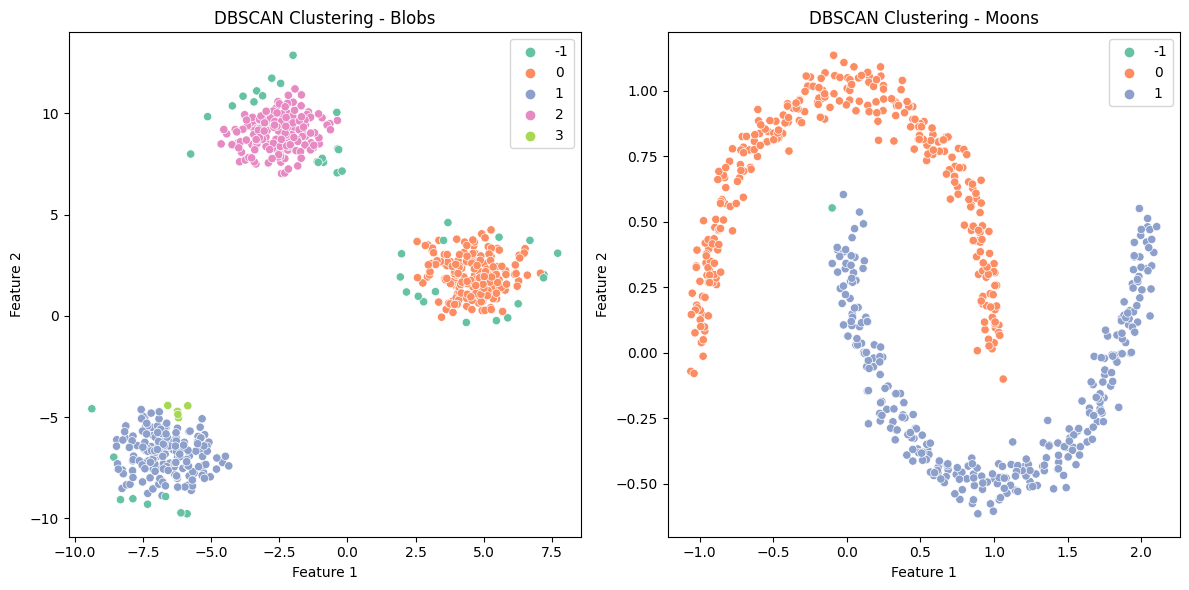

In [ ]:
from sklearn.cluster import DBSCAN


def plot_dbscan_clustering(ax, data, eps, min_samples, title):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    dbscan_labels = dbscan.fit_predict(data)

    sns.scatterplot(
        x=data[:, 0], y=data[:, 1], hue=dbscan_labels, palette="Set2", ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_dbscan_clustering(
    axes[0], x_blobs, eps=0.5, min_samples=5, title="DBSCAN Clustering - Blobs"
)
plot_dbscan_clustering(
    axes[1], x_moons, eps=0.15, min_samples=5, title="DBSCAN Clustering - Moons"
)

plt.tight_layout()
plt.show()

# Кодирование признаков




**Кодирование признаков** &mdash; процесс описания данных в численном представлении.







Изначально объекты в нашем датасете могут быть представлены в виде описаний, которые не являются численными или требуют некоторой предобработки. Например:
*   веб-страницы;
*   тексты;
*   формулы химических веществ;
*   строки со значениями и единицами измерений (сантиметры, метры, и т.д.) и др.

Большая часть моделей не способна работать с такими представлениями в сыром виде и просто не запустится или будет выдавать неадекватные результаты.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/process_of_generation_features.png" width="700">

**Пример на Titanic**

Для иллюстрации будут использованы примеры из книги "[Real-World Machine Learning 📚[book]](https://www.manning.com/books/real-world-machine-learning)" из открытого [репозитория 🐾[git]](https://github.com/brinkar/real-world-machine-learning) и датасет [Titanic 🛠️[doc]](https://www.kaggle.com/datasets/brendan45774/test-file).

Данный датасет представляет собой список пассажиров судна.
В отличие от датасетов, с которыми мы работали раньше, данные в нем не предобработаны и в сыром виде не могут быть использованы для обучения модели.

In [ ]:
import pandas as pd

# Download the data and save it in a variable called data
dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/titanic.csv"
)  # Load the data using pandas
dataset[:5]  # Show the first 5 lines

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

*  SibSp  == Number of Siblings/Spouses Aboard — количество братьев/сестер/супругов на борту Титаника.
*  Parch == Number of Parents/Children Aboard — количество родителей/детей на борту.
*  Embarked == Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton) — порт посадки.

Если мы попытаемся обучить модель на таких данных, то у нас ничего не выйдет.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

x = dataset.drop("Survived", axis=1)  # drop target
y = dataset["Survived"]  # target

rf = RandomForestClassifier(random_state=42)

try:
    rf.fit(x, y)
except ValueError as e:
    print(e)

could not convert string to float: 'Braund, Mr. Owen Harris'


Посмотрим на информацию о признаках:

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Типы признаков

Традиционно признаки делятся на вещественные и категориальные.

### Вещественные

Вещественные признаки бывают:

 * дискретные. Например, число лайков от пользователей


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/discrete_features_social_media_likes.jpg" width="1000">

В датасете Титаник таким параметром будет SibSp — количество братьев/сестер/супругов на борту.

In [ ]:
print(dataset["SibSp"].unique())

[1 0 3 4 2 5 8]


Или Parch — количество родителей/детей на борту.

In [ ]:
print(dataset["Parch"].unique())

[0 1 2 5 3 4 6]


 * непрерывные. Например, температура

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/continuous_features_thermometer.png" width="600">

Разделение условное. Тот же возраст можно посчитать и дискретной переменной (пользователь всегда нам сообщает свои полные года), и непрерывной (возраст можно считать с любой точностью)

Иногда вещественные признаки делят на относительные (считаются относительно чего-то, уже нормированные и т.д.) и интервальные.

In [ ]:
dataset[["Age", "Fare"]].head()

Age     Fare
0  22.0   7.2500
1  38.0  71.2833
2  26.0   7.9250
3  35.0  53.1000
4  35.0   8.0500

Попробуем обучить модель на вещественных признаках. PassengerId удалим, т.к. этот признак может приводить к утечке в данных.

In [ ]:
from sklearn.model_selection import train_test_split

x = dataset.drop(columns=["Survived", "PassengerId"])  # drop target and id
y = dataset["Survived"]  # target

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
# drop categorical
x_train_working = x_train.drop(
    columns=["Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
)
x_test_working = x_test.drop(
    columns=["Pclass", "Name", "Sex", "Ticket", "Cabin", "Embarked"]
)

rf = RandomForestClassifier(random_state=42)

try:
    rf.fit(x_train_working, y_train)
except ValueError as e:
    print(e)

x_train_working.head()

Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


Age  SibSp  Parch     Fare
331  45.5      0      0  28.5000
733  23.0      0      0  13.0000
382  32.0      0      0   7.9250
704  26.0      1      0   7.8542
813   6.0      4      2  31.2750

Проблема в том, что Age указан только для 714 пассажиров из 891. Его мы пока тоже удалим.

In [ ]:
from sklearn.metrics import accuracy_score

x_train_working = x_train_working.drop(columns=["Age"])
x_test_working = x_test_working.drop(columns=["Age"])

rf = RandomForestClassifier(random_state=42)

rf.fit(x_train_working, y_train)
y_pred = rf.predict(x_test_working)

print(accuracy_score(y_test, y_pred))

0.6759776536312849


Точность предсказания 67.6%. Для улучшения качества попробуем добавить другие признаки.

### Категориальные

Значение —  принадлежность к какой-то из категорий. Традиционно делятся на сильно отличающиеся по свойствам:
 * упорядоченные (ординальные) — имееют порядок (иерархию), для каждой пары категорий можем сказать, какая больше, а какая меньше. Например, класс места или размер одежды.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/categorical_ordered_features.png" width="600">

В датасете Титаник таким признаком будет класс. Мы можем сказать, что первый класс лучше третьего, но не можем  сказать, что сумма первого и второго даст третий.

In [ ]:
print(dataset["Pclass"].unique())

[3 1 2]


 * неупорядоченные (номинальные) &mdash; категории между собой несравнимы. Обычно нельзя сказать, что желтая футболка больше синей или зеленая лучше, чем фиолетовая.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/categorical_unordered_features.png" width="600">

Важно понимать, что могут быть ситуации, когда один и тот же признак может быть упорядоченным или неупорядоченным, в зависимости от задачи и наших знаний о ней. Например, цвет в спектре определяется длиной волны, и в физической задаче цвета можно упорядочить.

В датасете Титаник таким признаком является Embarked (порт посадки).

In [ ]:
print(dataset["Embarked"].unique())
# C = Cherbourg; Q = Queenstown; S = Southampton

['S' 'C' 'Q' nan]


Часто мы сталкиваемся с бинарными категориальными признаками, для которых известны только две возможные категории (например, биологический пол человека).

In [ ]:
print(dataset["Sex"].unique())

['male' 'female']


## Преобразования признаков



Существует много подходов к кодированию признакового пространства. Каждый подход имеет свои особенности. Способ кодирования зависит от используемой модели.

### Категориальные признаки

#### Label encoding

В Label encoding каждой категории признака однозначно сопоставляется число. Данный подход хорошо работает для упорядоченных (ординальных) признаков.

Если признак неупорядоченный (номинальный), то могут возникнуть проблемы.
Например, если мы обозначим:
$$Уж = 1$$
$$Ёж = 2$$
$$Белка = 3$$
То в некоторых моделях (линейных), может возникнуть ложная зависимость:

$$Уж+Ёж = Белка$$
что не является свойством данных.


Кроме того, мы не можем сказать, что уж “больше” ежа и сравнить его с белкой, но обучаемая модель про это не знает и будет пытаться их сравнить. Это может привести к низкому качеству модели и выучиванию неправильной информации.

Например, дерево решений для выделения одной категории должно будет проделать несколько сравнений.

Некоторые модели (например, [LightGBM 🛠️[doc]](https://lightgbm.readthedocs.io/en/latest/)) могут автоматически подбирать кодировку для категориальных признаков, если предоставить им информацию о том, что признак категориальный, для других моделей это нужно делать вручную.

У нас есть упорядоченный категориальный признак — класс, которым ехал пассажир. Добавим его к данным.

In [ ]:
x_train_working["Pclass"] = x_train["Pclass"]
x_test_working["Pclass"] = x_test["Pclass"]

x_train_working[:5]

SibSp  Parch     Fare  Pclass
331      0      0  28.5000       1
733      0      0  13.0000       2
382      0      0   7.9250       3
704      1      0   7.8542       3
813      4      2  31.2750       3

#### One-hot encoding

На практике часто используется one-hot encoding. Вместо одного категориального признака $X$ создается набор бинарных категориальных признаков, которые отвечают на вопрос $X == C$, где $C$ перебирает все возможные значения категориального признака.

Теперь, чтобы выбрать конкретное значение категориального признака, дереву решений достаточно задать один вопрос.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/one_hot_encoding.png" width="450">

У такой схемы есть ряд недостатков:

1. Мы получаем линейно зависимые признаки. Это может плохо влиять на некоторые модели. Например, в линейных моделях линейная зависимость признаков приводит к тому, что решение оптимизационной задачи (результат подбора весов) может быть не уникальным и сколь угодно большим по модулю, что негативно сказывается на работе модели.

Подробнее:

[[blog] ✏️ Think twice before dropping that first one-hot encoded column](https://inmachineswetrust.com/posts/drop-first-columns/).

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/problem_of_ohe.png" width="850">

Поэтому одну из категорий могут исключить при кодировании. Например, в примере выше можно исключить **Рыбу**, ведь если все три других признака-категории равны 0, то точно верно, что категория — **Рыба**.

2. При использовании one-hot encoding один категориальный признак может преобразовываться в десятки бинарных признаков. При использовании случайного леса выбирается случайное подмножество признаков. Преобразованные во множество бинарных, категориальные признаки будут встречаться чаще, чем вещественные, что может привести к тому, что значимость категориальных признаков будет завышена.

У нас есть два признака с ограниченным количеством значений: Sex и Embarked.

Пол закодируем male = 1 female = 0.

In [ ]:
x_train_working["Sex"] = x_train["Sex"].map({"male": 1, "female": 0})
x_test_working["Sex"] = x_test["Sex"].map({"male": 1, "female": 0})

x_train_working[:5]

SibSp  Parch     Fare  Pclass  Sex
331      0      0  28.5000       1    1
733      0      0  13.0000       2    1
382      0      0   7.9250       3    1
704      1      0   7.8542       3    1
813      4      2  31.2750       3    0

#### Count encoding

Еще один способ, который показал свою эффективность — это кодирование категориальной переменной по количеству встречаемости в данных.

|  category | new_feature |
|:---------:|:-----------:|
|    food   |      3      |
| equipment |      2      |
|    food   |      3      |
|  food     |      3      |
| equipment |      2      |
|  clothes  |      1      |

Его просто и быстро реализовать. Здесь также присутствует логика порядка, который возникает естественным образом. Чем больше число, тем чаще встречается категория. Также здесь отсутствует ложная линейная зависимость: в нашем случае `equipment + clothes = food`, и для нас это действительно так, потому что наше кодирование отражает связь между категориями через их частоту.

Дополнительно стоит добавить шум к данным, чтобы избежать ситуации, когда разные категории кодируются одинаковым числом.

|  category | new_feature |
|:---------:|:-----------:|
|    food   |      2.3    |
| equipment |      2.04   |
|    food   |      2.3    |
|  clothes  |      2.6    |
| equipment |      2.04   |
|  clothes  |      2.6    |

#### Кодирование по вещественному признаку

Можем кодировать категориальный признак по какой-то статистике вещественного.
Например, при прогнозировании покупок в интернет магазине может оказаться разумным кодировать категории товаров их средней ценой.

|  category |  product | price | new_feature |
|:---------:|:--------:|:-----:|:-----------:|
|    food   |   pizza  |   30  |      17     |
| equipment |  hammer  |  140  |     170     |
|    food   | cucumber |   4   |      17     |
|  clothes  |   boots  |  100  |      60     |
| equipment |  helmet  |  200  |     170     |
|  clothes  |  gloves  |   20  |      60     |

#### Target encoding

В Target encoding каждая категория кодируется численным параметром, характеризующим то, что мы предсказываем. Например, можно каждую категорию категориального признака заменять на среднее целевого значения (mean target).

При этом может возникнуть проблема переобучения: для редких классов модель может научиться копировать значение mean target категориального признака в ответ, игнорируя другие признаки.

Как с этим бороться:

[[git] 🐾 Курс "Прикладные задачи анализа данных", Генерация признаков](https://github.com/Dyakonov/PZAD/blob/master/2020/PZAD2020_042featureengineering_07.pdf).

Так как у нас в качестве модели используется случайный лес, для Embarked будем использовать Label encoding. Мы не будем считать среднее. Используем Target, чтобы упорядочить метки. Посмотрим, какой процент выживших для каждого порта. Смотреть будем только на train выборке. Информация из test выборки не должна попасть в модель!

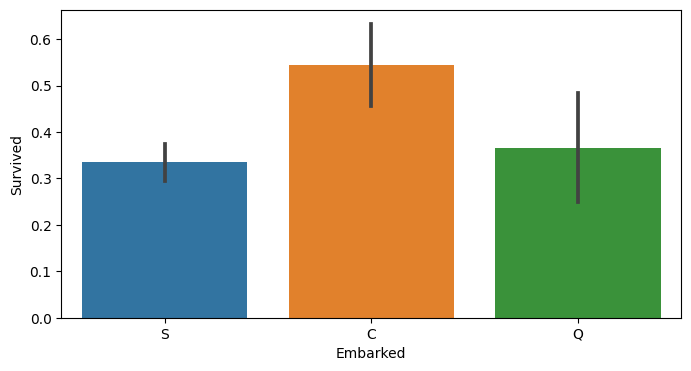

In [ ]:
import seaborn as sns
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 4))

train_df = x_train.copy()
train_df["Survived"] = y_train
sns.barplot(x="Embarked", y="Survived", data=train_df)
plt.show()

Получили количество выживших $S<Q<C$. Упорядочим метки соответственно.

In [ ]:
import numpy as np

emb = {np.nan: 0, "S": 0, "Q": 1, "C": 2}

x_train_working["Embarked"] = x_train["Embarked"].map(emb)
x_test_working["Embarked"] = x_test["Embarked"].map(emb)

x_train_working[5:10]

SibSp  Parch      Fare  Pclass  Sex  Embarked
118      0      1  247.5208       1    1         2
536      0      0   26.5500       1    1         0
361      1      0   27.7208       2    1         2
29       0      0    7.8958       3    1         0
55       0      0   35.5000       1    1         0

У нас осталось еще 4 признака, с которыми непонятно, что делать: Name, Ticket, Cabin, Age.

Рассмотрим поле Name. Это поле может нести информацию о поле, социальном статусе, происхождении, национальности, возрасте и т.д. Можно построить модели, которые будут это оценивать и отражать. Мы будем работать с числовыми представлениями текста в нашем курсе. Но пока мы можем использовать метод "пристального вглядывания" в данные.

In [ ]:
x_train.Name[:5]

331                   Partner, Mr. Austen
733            Berriman, Mr. William John
382                    Tikkanen, Mr. Juho
704               Hansen, Mr. Henrik Juul
813    Andersson, Miss. Ebba Iris Alfrida
Name: Name, dtype: object

В именах есть информация о социальном статусе:
- Miss — незамужняя женщина,
- Mrs — замужняя женщина,
- Master — несовершеннолетний мужчина,
- Mr — совершеннолетний мужчина,
- Dr — доктор,
- Rev — преподобный,
- Capt — капитан,

и т.д.

Первые 4 встречаются чаще.

Извлечем все возможные титулы, они начинаются с пробела и заканчиваются точкой.

In [ ]:
titles = dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False).unique()
print(titles)

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'Countess' 'Jonkheer']


Сгруппируем некоторые с похожими значениями. Редкие запишем в нулевой класс.

In [ ]:
title_mapping = {"Mr": 4, "Miss": 3, "Mrs": 2, "Master": 1}

# get title from name and encode by title_mapping, another titles fill zero
x_train_working["Title"] = (
    x_train.Name.str.extract(" ([A-Za-z]+)\.", expand=False)
    .map(title_mapping)
    .fillna(0)
)
x_test_working["Title"] = (
    x_test.Name.str.extract(" ([A-Za-z]+)\.", expand=False).map(title_mapping).fillna(0)
)

x_train_working[:5]

SibSp  Parch     Fare  Pclass  Sex  Embarked  Title
331      0      0  28.5000       1    1         0    4.0
733      0      0  13.0000       2    1         0    4.0
382      0      0   7.9250       3    1         0    4.0
704      1      0   7.8542       3    1         0    4.0
813      4      2  31.2750       3    0         0    3.0

#### Кодирование циклических категориальных признаков

При работе с датой и временем мы можем представить дату и время в виде числа. Один из способов такого представления [Unix Timestamp 🛠️[doc]](https://www.unixtimestamp.com/) (количество секунд, прошедших с 1 января 1970-го года).
Для ряда задач важна цикличность времени. Например, загруженность линии метро будет зависеть от времени дня (цикл 24 часа), дня недели (цикл 7 дней) и нерабочих праздничных дней (цикл год). Для прогнозирования количества электроэнергии, выработанной солнечной батареей, важно будет время дня (цикл 24 часа) и время года (цикл год).

В случае с такими признаками, как день недели или время суток, мы сталкиваемся с проблемой того, что нам нужно предложить кодирование, которое будет учитывать, что понедельник близок к воскресенью так же, как и ко вторнику, и т.д.


Давайте нанесем наши категории, например, дни недели, на окружность. Как это сделать?
Пусть понедельнику соответствует 1, а воскресенью — 7. Далее посчитаем два таких вспомогательных признака по следующим формулам

In [ ]:
weekdays = np.arange(1, 8)  # create an array of weekdays
print(weekdays)
sina = np.sin(weekdays * np.pi * 2 / np.max(weekdays))  # feature 1
cosa = np.cos(weekdays * np.pi * 2 / np.max(weekdays))  # feature 2

[1 2 3 4 5 6 7]


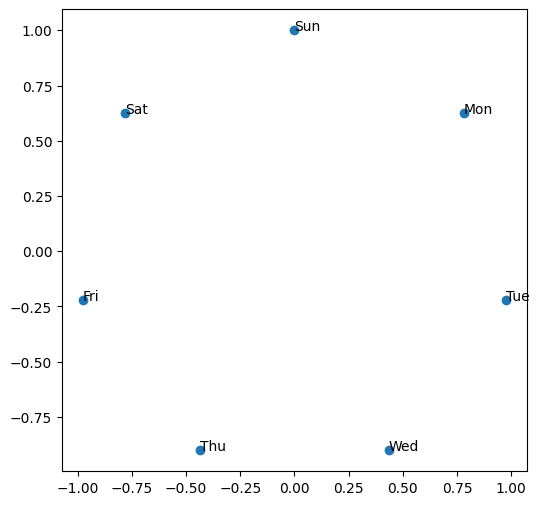

In [ ]:
plt.figure(figsize=(6, 6))  # Decide figure size
plt.scatter(sina, cosa)  # Plot scatter of feature 1 vs feature 2
for i, z in enumerate(
    ("Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun")
):  # for each day in a week
    plt.text(sina[i], cosa[i], s=z)  # add text labels to plot

Теперь расстояния между понедельником и вторником и воскресеньем и понедельником одинаковые:

In [ ]:
dist_mon_tue = (sina[1] - sina[0]) ** 2 + (
    cosa[1] - cosa[0]
) ** 2  # distance between Monday and Tuesday
dist_sun_mon = (sina[6] - sina[0]) ** 2 + (
    cosa[6] - cosa[0]
) ** 2  # distance between Sunday and Monday
print("Distance between Mon-Tue = %.2f" % dist_mon_tue)
print("Distance between Sun-Mon = %.2f" % dist_sun_mon)

Distance between Mon-Tue = 0.75
Distance between Sun-Mon = 0.75


То же самое верно и для любых отстоящих друг от друга на одинаковое число дней



In [ ]:
dist_mon_wed = (sina[2] - sina[0]) ** 2 + (
    cosa[2] - cosa[0]
) ** 2  # distance between Monday and Wednesday
dist_fri_sun = (sina[4] - sina[6]) ** 2 + (
    cosa[4] - cosa[6]
) ** 2  # distance between Friday and Sunday
print("Distance between Mon-Wed = %.2f" % dist_mon_wed)
print("Distance between Fri-Sun = %.2f" % dist_fri_sun)

Distance between Mon-Wed = 2.45
Distance between Fri-Sun = 2.45


Таким образом, циклические признаки можно кодировать парой признаков (sin и cos), полученных по схеме, описанной выше.



Проблемы подхода:

1. Такое кодирование может создать сложности для деревьев решений, т.к. они работают с одним признаком за раз.

2. Надо понимать, что важность исходной категориальной фичи неочевидным образом делится между двумя полученными из нее таким образом фичами.

3. В некоторых задачах one-hot работает лучше.

### Вещественные признаки



#### Бинаризация

Для ряда задач может быть неважно конкретное значение признака. Важнее может оказаться факт превышения порога или наличия значения.

Например, уровень сахара крови выше $11.1$ ммоль/л может говорить о наличии у пациента сахарного диабета, что повлияет на результат лечения. А наличие высшего образования больше влияет на платежеспособность, чем средний балл диплома.

Для таких признаков можно попробовать использовать бинаризацию: превращение вещественного признака в бинарный по принципу “есть ли значение” или “больше ли значение определенного порога”.

Бинаризируем уровень сахара в крови.

In [ ]:
from sklearn.preprocessing import Binarizer

# fmt: off
x = np.array([[1, 12],
              [2, 7.6],
              [3, 8.4],
              [4, 13.5],
              [5, 6.3]])
# fmt: on

transformer = Binarizer(threshold=11.1)
binarized = transformer.transform(np.expand_dims(x[:, 1], axis=1))

x_binarized = np.concatenate((x, binarized), axis=1)

print(x_binarized)

[[ 1.  12.   1. ]
 [ 2.   7.6  0. ]
 [ 3.   8.4  0. ]
 [ 4.  13.5  1. ]
 [ 5.   6.3  0. ]]


#### Binning (Бинирование)

Нам могут быть не интересны точные значения (например, что видео набрало 1000 лайков, а не 1001).

К тому же, число просмотров/лайков некоторых видео может быть очень большим в сравнении с остальными.
В итоге часть значений у нас встречается часто, а часть — очень редко, что
негативно скажется на результате работы модели.

Бинирование — это метод группировки вещественных признаков в несколько категорий, определяемых диапазонами значений. При этом категория может кодироваться средним или медианным значением признака в диапазоне данной категории.

Способы деления данных:

* **Фиксированными диапазонами.** Делим наши значения по диапазонам фиксированной длины. Так часто поступают с возрастом.

* **Используя понимание данных.**
Длина диапазона не всегда обязана быть кратна определенному ровному значению. В социальных исследованиях может быть полезным разделение на возрастные группы, которые определяются занятостью: школьники, студенты, выпускники, пенсионеры и т.д.

* **Адаптивными диапазонами.**
Бинирование с фиксированной длиной бина не поможет справиться с редкими значениями. В этой ситуации помогает бинирование, например, по квартилям — когда границы бина расставляются таким образом, чтобы между ними помещалась $1/4$ выборки.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/binning.png" width="1000">

#### Преобразования

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/log_transform.png" width="900">


* Логарифмическое преобразование — это применение логарифма к значениям признака. Это может быть полезным, если данные имеют сильно смещенное распределение, например, экспоненциальное. Логарифмическое преобразование может сделать распределение более близким к нормальному.

* Квадратный корень. Взятие квадратного корня из значений признаков может помочь справиться с сильно смещенными данными. Он уменьшает влияние больших значений и увеличивает влияние меньших значений.

* Преобразование Бокса-Кокса ([Box-Cox Transform ✏️[blog]](https://www.statisticshowto.com/box-cox-transformation/#:~:text=A%20Box%20Cox%20transformation%20is,a%20broader%20number%20of%20tests.)) — это семейство степенных преобразований, которое может адаптироваться к различным распределениям данных, общей целью которых является придать данным вид, более похожий на нормальное распределение, с которым работает бoльшее число моделей и сходимость которого лучше.

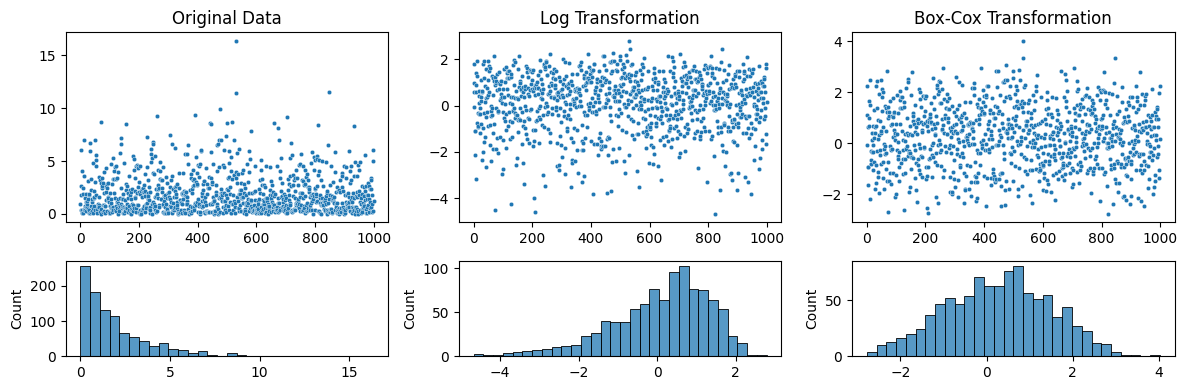

In [ ]:
from scipy import stats

np.random.seed(42)
data = np.random.exponential(scale=2, size=1000)

plt.figure(figsize=(12, 4))
gs = plt.GridSpec(2, 3, height_ratios=[2, 1])

plt.subplot(gs[0, 0])
sns.scatterplot(x=np.arange(len(data)), y=data, s=10)
plt.title("Original Data")
plt.subplot(gs[1, 0])
sns.histplot(data, bins=30)

data_log = np.log(data)
plt.subplot(gs[0, 1])
sns.scatterplot(x=np.arange(len(data_log)), y=data_log, s=10)
plt.title("Log Transformation")
plt.subplot(gs[1, 1])
sns.histplot(data_log, bins=30)

data_boxcox, _ = stats.boxcox(data)
plt.subplot(gs[0, 2])
sns.scatterplot(x=np.arange(len(data_boxcox)), y=data_boxcox, s=10)
plt.title("Box-Cox Transformation")
plt.subplot(gs[1, 2])
sns.histplot(data_boxcox, bins=30)

plt.tight_layout()
plt.show()

### Работа с пропущенными значениями

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/decision_tree_and_nan_values_in_data.png" width="1000">

Со всеми признаками производятся математические операции, поэтому для большинства моделей (деревья решений могут работать с пропущенными значениями, [Meaning of Surrogate Split ✏️[blog]](https://stats.stackexchange.com/questions/171574/meaning-of-surrogate-split)) отсутствие значений просто не дает производить эти операции.

Есть два основных подхода для работы с пропущенными значениями:

 1. Удалить все объекты с пропущенными значениями.

 2. На место пропущенных значений записать какие-то числа (заполнить пропущенные значения)

Иногда мы можем просто удалить объекты с пропущенными значениями, но если у нас мало данных и получение большего количества данных дорого/долго/невозможно, то нам нужно заполнить пропуски какими-то значениями.

Существует много способов заполнения пропусков значениями.

Рассмотрим наиболее популярные:

* **Заполнить константой.** Можно предположить, что данные несложные, а признаки не зависят друг от друга, и заполнить пропущенные значения средними значениями соответствующего признака.
Например, если средний возраст людей 30 лет, то для людей, чей возраст неизвестен, будем писать это же значение. Но в некоторых ситуациях такое заполнение может только навредить.

* **Предсказывать признаки моделью.** Используем признак с пропущенными значениями как целевую переменную и на основе других заполненных признаков предсказываем пропущенные значения. Можем использовать алгоритм, который умеет справляться с пропусками. Один из таких алгоритмов — k-NN. Можно брать ближайших соседей по известным признакам и на место неизвестного признака подставлять среднее значение соседей.

* **Самостоятельно придумывать логику заполнения.** Если мы имеем экспертное знание о природе пропусков, можем сами написать логику заполнения какими-то значениями.

В датасете Titanic отстался важный признак Age, который имеет пропуски. Посмотрим, как он связан с выживаемостью.

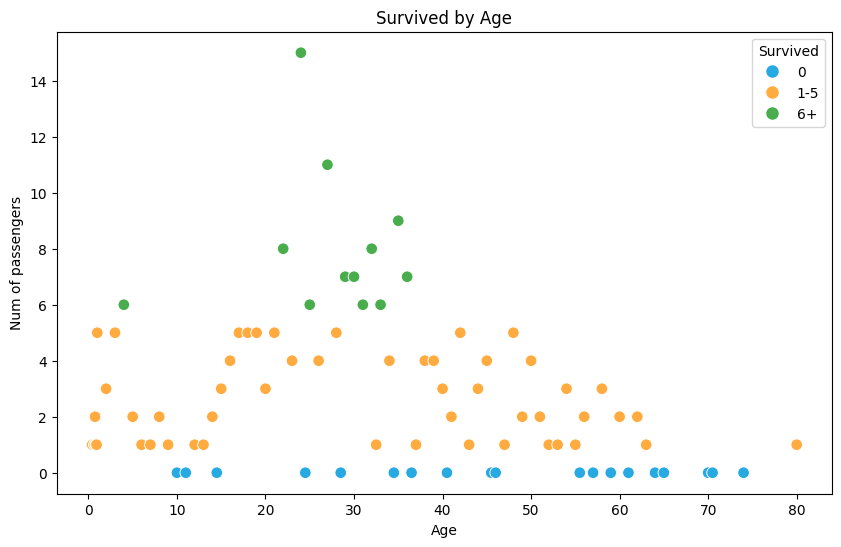

In [ ]:
train_df = x_train.copy()
train_df["Survived"] = y_train

plt.figure(figsize=(10, 6))
age_survival_plot = sns.scatterplot(
    data=train_df.groupby(["Age"], as_index=False)["Survived"].agg("sum"),
    x="Age",
    y="Survived",
    hue="Survived",
    s=70,
    palette={
        0: "#27a9e1",
        1: "#ffab40",
        2: "#ffab40",
        3: "#ffab40",
        4: "#ffab40",
        5: "#ffab40",
        6: "#49AD4D",
        7: "#49AD4D",
        8: "#49AD4D",
        9: "#49AD4D",
        11: "#49AD4D",
        15: "#49AD4D",
    },
)

age_survival_plot.set_title("Survived by Age")
age_survival_plot.set_xlabel("Age")
age_survival_plot.set_ylabel("Num of passengers")
custom_legend = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color, markersize=10)
    for color in ["#27a9e1", "#ffab40", "#49AD4D"]
]
age_survival_plot.legend(
    custom_legend, ["0", "1-5", "6+"], title="Survived", loc="upper right"
)

plt.show()

Видим, что связь есть. Обучим модель без этого признака и посмотрим на результат:

In [ ]:
x_train_working.head(3)

SibSp  Parch    Fare  Pclass  Sex  Embarked  Title
331      0      0  28.500       1    1         0    4.0
733      0      0  13.000       2    1         0    4.0
382      0      0   7.925       3    1         0    4.0

In [ ]:
results = dict()
rf = RandomForestClassifier(random_state=42)

rf.fit(x_train_working, y_train)
y_pred = rf.predict(x_test_working)

results["no feature"] = accuracy_score(y_test, y_pred).round(3)

print(f"Accuracy without feature 'Age': {results['no feature']}")

Accuracy without feature 'Age': 0.816


Заполним пропуски своей эвристикой. Вспомним, что в поле Title зашита общая информация о возрасте, посчитаем матожидание и дисперсию возраста для Title и сгенерируем недостающие значения.

In [ ]:
np.random.seed(42)

train_df = x_train.copy()
train_df["Title"] = x_train_working["Title"]

mean = {}
std = {}
for title in range(5):
    data = train_df.loc[train_df["Title"] == title]
    mean[title] = data["Age"].mean()
    std[title] = data["Age"].std()


def add_age_val(data, mean, std):
    for i, row in data.iterrows():
        if np.isnan(row["Age"]):
            title = int(row["Title"])
            data.loc[i, "Age"] = round(
                np.random.uniform(
                    low=int(mean[title] - std[title]),
                    high=int(mean[title] + std[title]),
                ),
                1,
            )
    return data

In [ ]:
x_train_working["Age"] = x_train["Age"]
x_test_working["Age"] = x_test["Age"]

x_train_working = add_age_val(x_train_working, mean, std)
x_test_working = add_age_val(x_test_working, mean, std)

x_train_working[:5]

SibSp  Parch     Fare  Pclass  Sex  Embarked  Title   Age
331      0      0  28.5000       1    1         0    4.0  45.5
733      0      0  13.0000       2    1         0    4.0  23.0
382      0      0   7.9250       3    1         0    4.0  32.0
704      1      0   7.8542       3    1         0    4.0  26.0
813      4      2  31.2750       3    0         0    3.0   6.0

Посмотрим, что получилось на обработанных данных.

In [ ]:
rf = RandomForestClassifier(random_state=42)

rf.fit(x_train_working, y_train)
y_pred = rf.predict(x_test_working)

results["by title"] = accuracy_score(y_test, y_pred).round(3)

print(f"Accuracy with hand-filled feature 'Age': {results['by title']}")

Accuracy with hand-filled feature 'Age': 0.821


Стало лучше. Теперь заполним пропуски с помощью модели. Воспользуемся `IterativeImputer` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) из `sklearn.impute` [🛠️[doc]](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.impute).

`IterativeImputer` автоматически заполняет пропущенные значения признаков, оценивая их при помощи модели. По умолчанию используется модель `BayesianRidge` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html#sklearn.linear_model.BayesianRidge).

In [ ]:
x_train_working["Age"] = x_train["Age"]
x_test_working["Age"] = x_test["Age"]

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer()
imputer.fit(x_train_working)

x_train_working = imputer.transform(x_train_working)
x_test_working = imputer.transform(x_test_working)

In [ ]:
rf = RandomForestClassifier(random_state=42)

rf.fit(x_train_working, y_train)
y_pred = rf.predict(x_test_working)

results["imputer"] = accuracy_score(y_test, y_pred).round(3)

print(f"Accuracy with feature 'Age' filled with IterativeImputer: {results['imputer']}")

Accuracy with feature 'Age' filled with IterativeImputer: 0.832


Сравним результаты при разном заполнении пропусков

In [ ]:
pd.DataFrame([results], index=["accuracy"])

no feature  by title  imputer
accuracy       0.816     0.821    0.832

В нашем случае `IterativeImputer` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.impute.IterativeImputer.html#sklearn.impute.IterativeImputer) дал наилучший результат. Хорошая практика — использовать данный метод как быстрый бейзлайн по заполнению пропусков.

Важно помнить, что пропуски в данных не всегда являются отсутствием значений, иногда пропуски могут быть обозначены совершенно разными способами: `0`, `-`, `(пусто)`, `'отсутствует'`, `None`, `nan`, и другие. Поэтому нужно приводить пропуски к единому формату, с которым удобно работать в дальнейшем, например `np.nan`.

# Разведочный анализ данных

Разведочный анализ данных (exploratory data analysis, EDA) — это процесс изучения данных с целью понимания их свойств. Его используют для поиска закономерностей, нахождения аномалий, создания новых признаков.

Это творческий процесс, и не существует единого рецепта, как это делать. Более того, разбору одной задачи можно посвятить лекцию. Наша задача в этом блоке — познакомиться с основными инструментами для анализа.

Будем работать с датасетом по определению цвета вина в зависимости от его характеристик.

Загрузим датасет и сразу посмотрим, как он выглядит:

In [ ]:
import pandas as pd

dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/wine_quality_data.csv"
)
dataset

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0               7.4              0.70         0.00             1.9      0.076   
1               7.8              0.88         0.00             2.6      0.098   
2               7.8              0.76         0.04             2.3      0.092   
3              11.2              0.28         0.56             1.9      0.075   
4               7.4              0.70         0.00             1.9      0.076   
...             ...               ...          ...             ...        ...   
6492            6.2              0.21         0.29             1.6      0.039   
6493            6.6              0.32         0.36             8.0      0.047   
6494            6.5              0.24         0.19             1.2      0.041   
6495            5.5              0.29         0.30             1.1      0.022   
6496            6.0              0.21         0.38             0.8      0.020   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                    11.0                  34.0  0.99780  3.51       0.56   
1                    25.0                  67.0  0.99680  3.20       0.68   
2                    15.0                  54.0  0.99700  3.26       0.65   
3                    17.0                  60.0  0.99800  3.16       0.58   
4                    11.0                  34.0  0.99780  3.51       0.56   
...                   ...                   ...      ...   ...        ...   
6492                 24.0                  92.0  0.99114  3.27       0.50   
6493                 57.0                 168.0  0.99490  3.15       0.46   
6494                 30.0                 111.0  0.99254  2.99       0.46   
6495                 20.0                 110.0  0.98869  3.34       0.38   
6496                 22.0                  98.0  0.98941  3.26       0.32   

      alcohol  quality  is_red  
0         9.4        5       0  
1         9.8        5       0  
2         9.8        5       0  
3         9.8        6       0  
4         9.4        5       0  
...       ...      ...     ...  
6492     11.2        6       1  
6493      9.6        5       1  
6494      9.4        6       1  
6495     12.8        7       1  
6496     11.8        6       1  

[6497 rows x 13 columns]

Можем сделать первые выводы об объеме датасета и количестве признаков.

## Описательные статистики

Теперь посмотрим более детально, используя встроенные методы `pandas`:

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
 12  is_red                6497 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 660.0 KB


Видим, что нет пропусков. Смотрим, все ли признаки соответствуют своему `Dtype`, также можем оценить размер используемой памяти.

Посмотрим описательные статистики по признакам:

In [ ]:
dataset.describe()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free_sulfur_dioxide  total_sulfur_dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000              6.000000     0.987110   
25%       0.038000            17.000000             77.000000     0.992340   
50%       0.047000            29.000000            118.000000     0.994890   
75%       0.065000            41.000000            156.000000     0.996990   
max       0.611000           289.000000            440.000000     1.038980   

                pH    sulphates      alcohol      quality       is_red  
count  6497.000000  6497.000000  6497.000000  6497.000000  6497.000000  
mean      3.218501     0.531268    10.491801     5.818378     0.753886  
std       0.160787     0.148806     1.192712     0.873255     0.430779  
min       2.720000     0.220000     8.000000     3.000000     0.000000  
25%       3.110000     0.430000     9.500000     5.000000     1.000000  
50%       3.210000     0.510000    10.300000     6.000000     1.000000  
75%       3.320000     0.600000    11.300000     6.000000     1.000000  
max       4.010000     2.000000    14.900000     9.000000     1.000000

Чтобы стало нагляднее, можем использовать `DataFrame.hist` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.hist.html) прямо из `pandas`:

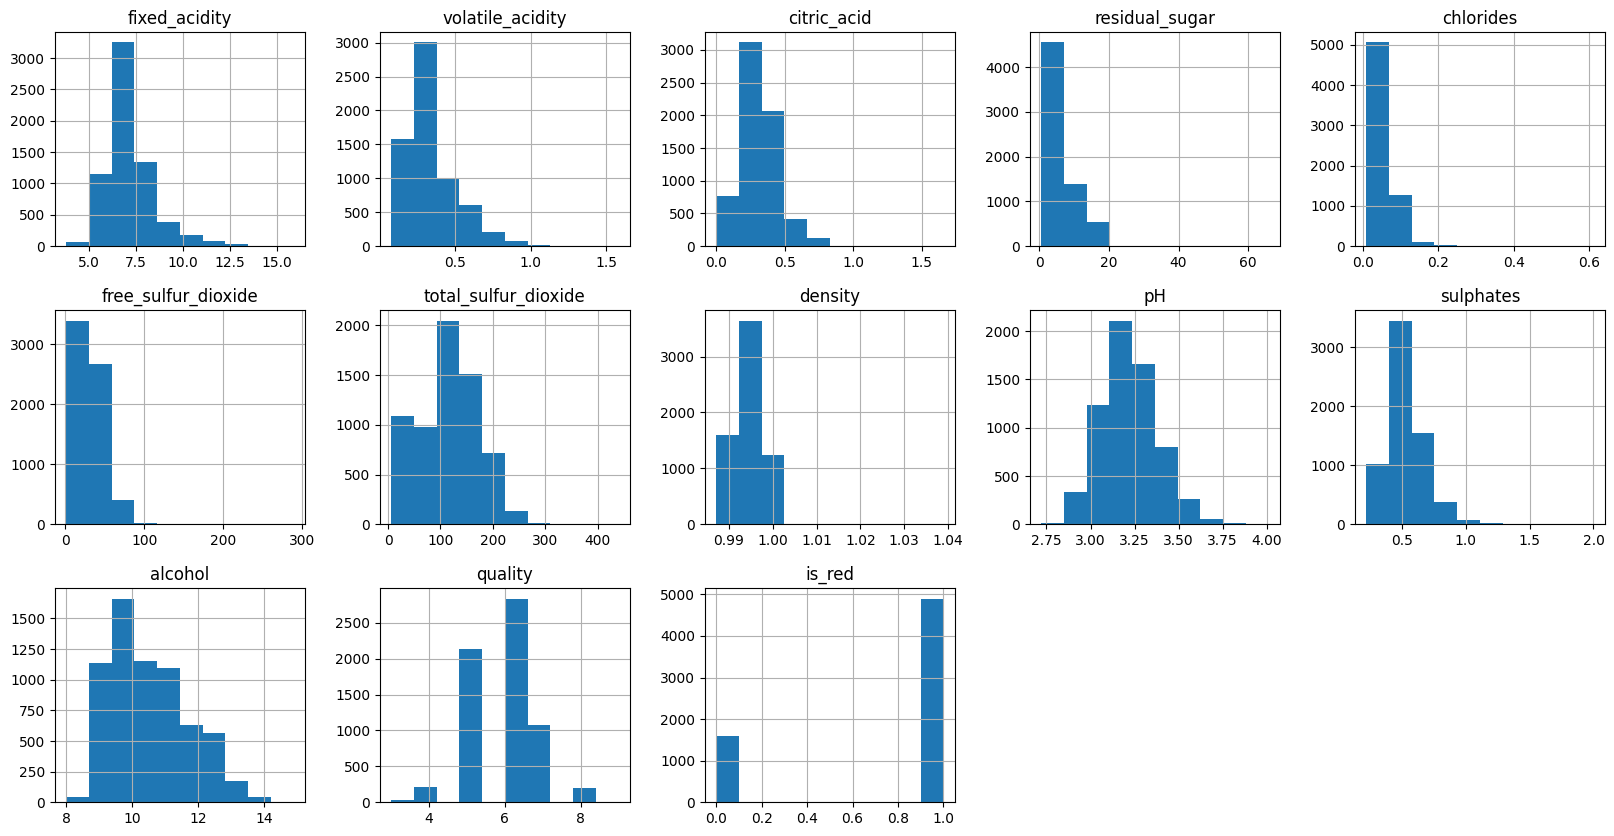

In [ ]:
import matplotlib.pyplot as plt

dataset.hist(figsize=(20, 10), layout=(-1, 5))
plt.show()

Видим, что у нас присутствует дисбаланс классов (распределение целевого признака `is_red`). Почти все распределения признаков одномодальные. Можем оценить диапазон значений признаков.

## Взаимодействие признаков

Полезно знать, как признаки взаимодействуют друг с другом и с целевой переменной. Часто для первичной оценки используют корреляцию. Дополнительно это поможет нам найти в датасете скоррелированные признаки. Для этого воспользуемся `DataFrame.corr` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.corr.html) и `seaborn.heatmap` [🛠️[doc]](https://seaborn.pydata.org/generated/seaborn.heatmap.html).

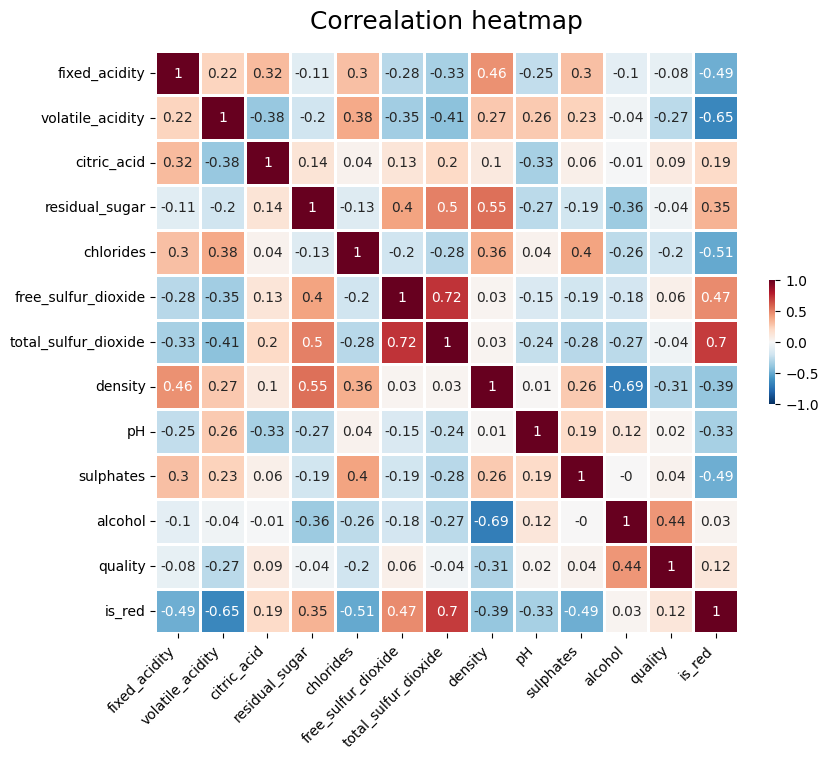

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 8))

heatmap = sns.heatmap(
    dataset.corr(method="pearson", numeric_only=True).round(2),
    annot=True,
    square=True,
    cmap="RdBu_r",
    vmax=1,
    vmin=-1,
    cbar_kws={"fraction": 0.01},  # shrink colour bar
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Correalation heatmap", fontdict={"fontsize": 18}, pad=16)
plt.show()

Видим, что два признака имеют высокую корреляцию между собой (`free_sulfur_dioxide` и `total_sulfur_dioxide`). [Почему это плохо и что с этим делать ✏️[blog]](https://habr.com/ru/companies/akbarsdigital/articles/592493/).

Также важно отметить, что корреляция Пирсона, посчитанная для категориальных признаков, может давать некорректные и бессмысленные результаты.

Поэтому на практике хорошо себя показывает [Phi_K 🛠️[doc]](https://phik.readthedocs.io/en/latest/) ($\phi_k$) корреляция. Она, в отличие от корреляции Пирсона, учитывает нелинейные зависимости и работает с категориальными признаками.

In [ ]:
!pip install -q phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 5.2 MB/s eta 0:00:00


В этот раз отсортируем коэффициенты корреляции по целевой переменной:

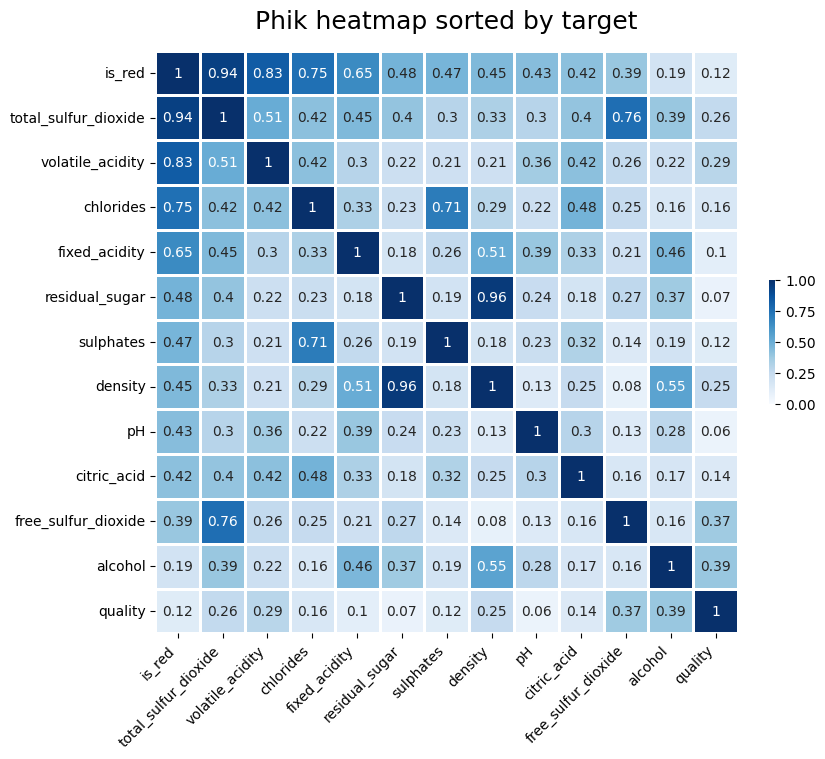

In [ ]:
import phik

plt.figure(figsize=(8, 8))

sotred_columns = (
    dataset.phik_matrix(interval_cols=dataset.columns)
    .round(2)
    .sort_values("is_red", ascending=False, axis=1)
    .columns
)

heatmap = sns.heatmap(
    dataset.phik_matrix(interval_cols=dataset.columns)
    .round(2)
    .sort_values("is_red", ascending=False, axis=1)
    .reindex(sotred_columns),
    annot=True,
    square=True,
    cmap="Blues",
    vmax=1,
    vmin=0,
    cbar_kws={"fraction": 0.01},  # shrink colour bar
    linewidth=2,
)

heatmap.set_xticklabels(
    heatmap.get_xticklabels(), rotation=45, horizontalalignment="right"
)
heatmap.set_title("Phik heatmap sorted by target", fontdict={"fontsize": 18}, pad=16)
plt.show()

Можем выделить признаки, которые имеют наибольший коэффициент. Посмотрим как они взаимодействуют друг с другом.

При большом количестве объектов бывает сложно понять, какие есть зависимости (объекты накладываются друг на друга), поэтому мы возьмем случайные 1000 объектов из нашего датасета, чтобы было нагляднее. Воспользуемся `seaborn.pairplot` [🛠️[doc]](https://seaborn.pydata.org/generated/seaborn.pairplot.html).

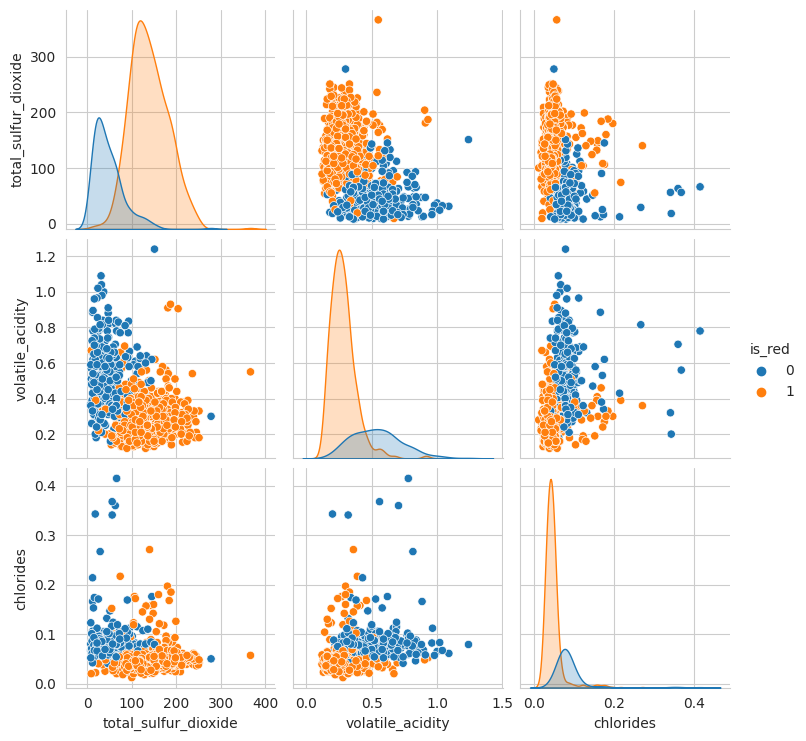

In [ ]:
sns.set_style("whitegrid")

sns.pairplot(
    dataset.sample(1000),
    vars=["total_sulfur_dioxide", "volatile_acidity", "chlorides"],
    hue="is_red",
)
plt.show()

Можем отметить, что признак `total_sulfur_dioxide` действительно хорошо разделяется по целевому признаку. Также хорошее разделение видим в паре признаков `total_sulfur_dioxide` и `volatile_acidity`.

## Анализ категориальных признаков

В датасете есть категориальный признак `quality`. Посмотрим, как распределен `total_sulfur_dioxide` в разрезе по целевому признаку и по каждому значению `quality`:

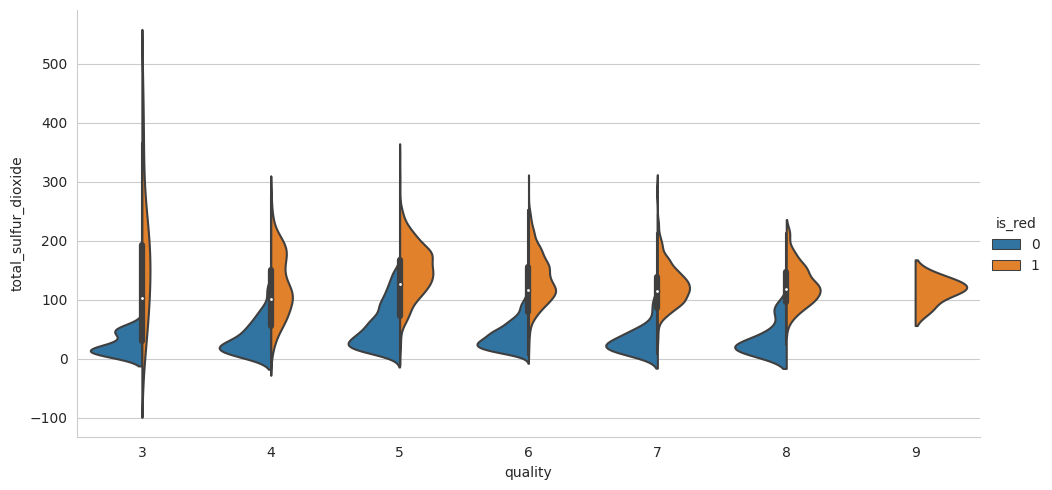

In [ ]:
sns.catplot(
    data=dataset,
    x="quality",
    y="total_sulfur_dioxide",
    hue="is_red",
    aspect=2,
    alpha=0.5,
    kind="violin",  # strip, swarm, box, violin, boxen, point, bar, or count
    split=True,
)
plt.show()

Видим, что в 9 категории нет объектов другого класса, но такой график не отражает количество объектов в категориях. Можем это посмотреть, воспользовавшись `pandas.crosstab` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.crosstab.html):

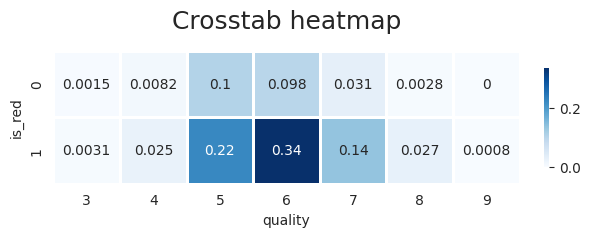

In [ ]:
cross_tab = sns.heatmap(
    pd.crosstab(dataset["is_red"], dataset["quality"], normalize=True).round(4),
    annot=True,
    square=True,
    cmap="Blues",
    cbar_kws={"fraction": 0.01},
    linewidth=1,
)

cross_tab.set_title("Crosstab heatmap", fontdict={"fontsize": 18}, pad=16)
plt.show()

Теперь видно, что объектов 9 категории довольно мало. Также можем оценить, в каких категориях сконцетрированы объекты.

Еще один полезный тип графика — это `seaborn.relplot` [🛠️[doc]](https://seaborn.pydata.org/generated/seaborn.relplot.html). Eго удобно использовать, если у нас есть временной признак, тогда мы можем построить зависимость признака относительно времени.

У нас такого признака нет, построим два признака с раскраской по категориальной переменной `quality`:

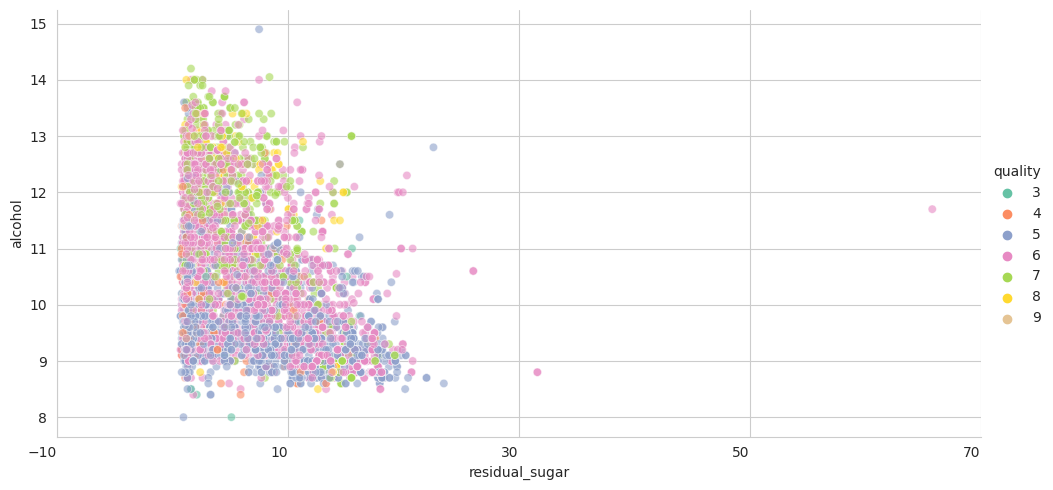

In [ ]:
relplot = sns.relplot(
    data=dataset,
    x="residual_sugar",
    y="alcohol",
    hue="quality",
    kind="scatter",  # or line
    aspect=2,
    alpha=0.6,
    palette="Set2",
)

relplot.set_xticklabels(horizontalalignment="right", step=2)
plt.show()

Видно, что объекты 5 категории в среднем находятся ниже 7 категории, построим тот же `seaborn.relplot`, но уже для двух категорий. В этот раз для примера будем использовать параметр `kind="line"`, который отвечает за вид графика:

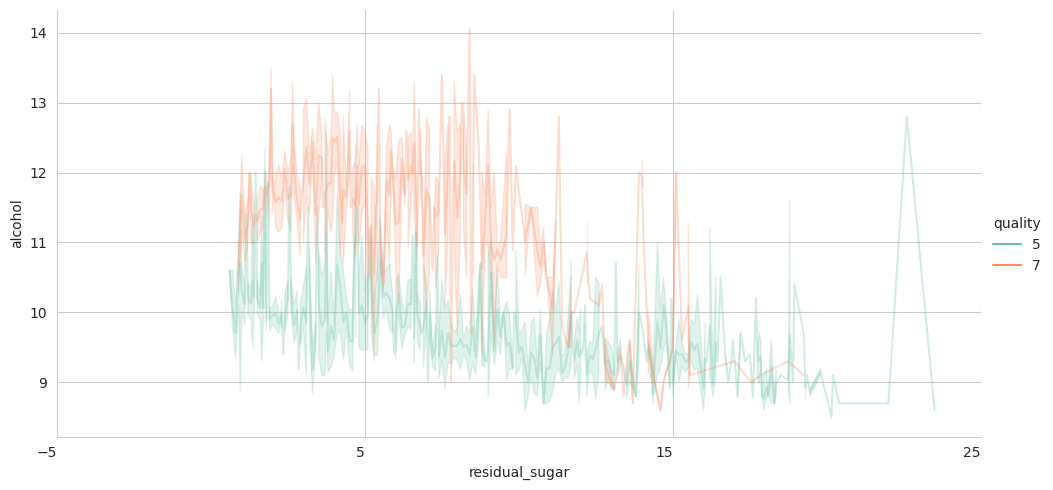

In [ ]:
relplot = sns.relplot(
    data=dataset.query("quality == (5,7)"),
    x="residual_sugar",
    y="alcohol",
    hue="quality",
    kind="line",
    aspect=2,
    alpha=0.3,
    palette="Set2",
)

relplot.set_xticklabels(horizontalalignment="right", step=2)
plt.show()

Итоги:
* Способов визуализации данных довольно много, запомните несколько и научитесь ими пользоваться. Например, те, которые мы рассмотрели в лекции.
* Раскрашивайте объекты не только по целевому признаку, но и по категориальным.
* Для анализа трендов стройте график по времени, частоте или другому признаку.
* Если объектов много, то стройте несколько графиков только на подвыборке объектов.


[[git] 🐾 Пример EDA](https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb)

[[blog] ✏️ Примеры графиков matplotlib](https://habr.com/ru/articles/468295/)

[[video] 📺 Курс лекций с разбором практических задач с применением EDA](https://www.youtube.com/watch?v=FNDQYM0hjh0&list=PLaRUeIuewv8CMFox0oEjlyePUhUmo-x0h)

# Генерация признаков


Общая схема классического машинного обучения выглядит так. Даже в случае нейросетей некоторая предобработка исходных данных все равно не бывает лишней.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/data_preparation.png" width="600">



**Генерация признаков** &mdash; процесс создания числовых представлений данных.







Процесс создания признаков зависит от модели, которую мы собираемся использовать.

Для одних моделей (**линейные, древесные модели**) может быть полезно добавить признаки, полученные **делением/перемножением** исходных. Другие модели (например, **SVM**) могут провести эти операции сами, причем, экономнее/менее переобучаясь.

Добавление признаков, явно зависящих друг от друга, мешает некоторым моделям. Например, плохая идея — дублировать в линейной модели признаки X1 и X2, или добавлять их сумму.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/process_of_generation_features.png" width="700">

**Feature engineering** является критическим местом (**bottleneck**), в машинном обучении. На этом этапе определяется, **что модель будет знать о данных**. Можно упростить задачу для модели, подав подходящий набор признаков, или ввести модель в заблуждения, допустив критические ошибки.

ML модели “ленивы”: если дать модели **подсказку** об ответе, она **не будет искать сложные закономерности в данных**. Такой подсказкой может быть **id покупателя**. Для покупателя, который каждую неделю покупает одно и то же, модель выучит, что надо предсказывать все по признаку id. Если покупатель изменит свое поведение или придет новый покупатель, то модель может выдавать неадекватные предсказания. Такую же роль может сыграть информация о **номере эксперимента**, **лаборатории**, в которой его проводили, **аспиранте**, который его проводил, и т.д. Эта ситуация будет называться **Data Leakage**.
Перечисленная выше информация может быть важна для **анализа исходных данных**, например, можно выяснить, что у прибора в лаборатории А проблемы с калибровкой.



## Baseline

При решении задачи машинного обучения важно оценивать результат. Один из способов оценить результат — это сделать базовое решение задачи. Как правило, это решение, которое требует мало времени для реализации и явно лучше случайного ответа. Далее, улучшая решение, мы можем понимать, насколько оно лучше базового и что на это повлияло (подбор гиперпараметров, кодирование признаков, генерация признаков и многое другое).

Постановка задачи следующая:

Автомобильная компания выходит на новый рынок. После интенсивного исследования рынка они пришли к выводу, что поведение нового рынка похоже на их существующий рынок. На существующем рынке отдел продаж, изучив поведение клиентов, разделил их на сегменты (классы) A, B, C, D. Для нового рынка данных о поведении нет, но есть данные о потенциальных клиентах (пол, возраст, образование, уровень дохода, состав семьи и т.д.). Нужно классифицировать потенциальных клиентов.



Загрузим [датасет 🛠️[doc]]((https://www.kaggle.com/code/iamhungundji/customer-segmentation/input)) и посмотрим, какие есть признаки:

In [ ]:
import pandas as pd

data = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/customer_segmentation.csv"
)
data

ID  Gender Ever_Married  Age Graduated     Profession  \
0     462809    Male           No   22        No     Healthcare   
1     462643  Female          Yes   38       Yes       Engineer   
2     466315  Female          Yes   67       Yes       Engineer   
3     461735    Male          Yes   67       Yes         Lawyer   
4     462669  Female          Yes   40       Yes  Entertainment   
...      ...     ...          ...  ...       ...            ...   
8063  464018    Male           No   22        No            NaN   
8064  464685    Male           No   35        No      Executive   
8065  465406  Female           No   33       Yes     Healthcare   
8066  467299  Female           No   27       Yes     Healthcare   
8067  461879    Male          Yes   37       Yes      Executive   

      Work_Experience Spending_Score  Family_Size  Var_1 Segmentation  
0                 1.0            Low          4.0  Cat_4            D  
1                 NaN        Average          3.0  Cat_4            A  
2                 1.0            Low          1.0  Cat_6            B  
3                 0.0           High          2.0  Cat_6            B  
4                 NaN           High          6.0  Cat_6            A  
...               ...            ...          ...    ...          ...  
8063              0.0            Low          7.0  Cat_1            D  
8064              3.0            Low          4.0  Cat_4            D  
8065              1.0            Low          1.0  Cat_6            D  
8066              1.0            Low          4.0  Cat_6            B  
8067              0.0        Average          3.0  Cat_4            B  

[8068 rows x 11 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8068 entries, 0 to 8067
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID               8068 non-null   int64  
 1   Gender           8068 non-null   object 
 2   Ever_Married     7928 non-null   object 
 3   Age              8068 non-null   int64  
 4   Graduated        7990 non-null   object 
 5   Profession       7944 non-null   object 
 6   Work_Experience  7239 non-null   float64
 7   Spending_Score   8068 non-null   object 
 8   Family_Size      7733 non-null   float64
 9   Var_1            7992 non-null   object 
 10  Segmentation     8068 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 693.5+ KB


Посмотрим признак `Family_Size`. По смыслу он не подразумевает вещественных значений, хотя хранится в формате `float64`:

In [ ]:
data["Family_Size"].unique()

array([ 4.,  3.,  1.,  2.,  6., nan,  5.,  8.,  7.,  9.])

Действительно, все значения целые. В нашем случае не критично, но если датасет большой, то имеет смысл привести формат данных к более компактному представлению.

Видно, что есть пропуски. Для базового решения можно удалить или заполнить нулями. Мы заполним нулями и переведем все категориальные признаки в формат one-hot encoding

In [ ]:
from sklearn.model_selection import train_test_split

data["Segmentation"] = data["Segmentation"].map({"D": 1, "A": 2, "C": 3, "B": 4})
data.fillna(0, inplace=True)
data.drop(columns=["ID"], inplace=True)
data = pd.get_dummies(data)  # to ohe

x = data.drop(columns=["Segmentation"], axis=1)
y = data["Segmentation"]
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (5647, 32)
Shape of y_train : (5647,)
Shape of x_test : (2421, 32)
Shape of y_test : (2421,)


Запустим модель случайного леса и посмотрим, какой результат получится:

Training Accuracy:  0.966
Testing Accuracy:  0.491
              precision    recall  f1-score   support

           1       0.62      0.71      0.66       692
           2       0.41      0.38      0.39       597
           3       0.50      0.49      0.49       580
           4       0.37      0.35      0.36       552

    accuracy                           0.49      2421
   macro avg       0.48      0.48      0.48      2421
weighted avg       0.48      0.49      0.49      2421



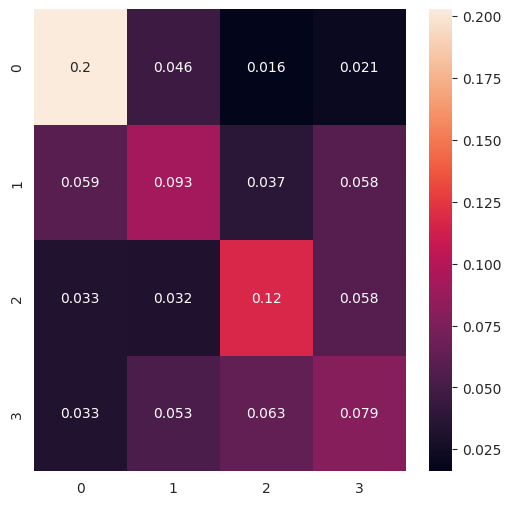

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def train_and_plot(x_train, y_train, x_test, y_test):
    model = RandomForestClassifier(random_state=42)
    model.fit(x_train, y_train)

    y_pred = model.predict(x_test)

    # evaluating the model
    print("Training Accuracy: ", model.score(x_train, y_train).round(3))
    print("Testing Accuracy: ", model.score(x_test, y_test).round(3))

    # confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize="all")
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True)

    # classification report
    cr = classification_report(y_test, y_pred)
    print(cr)


train_and_plot(x_train, y_train, x_test, y_test)

## Генерация признаков, полученных при помощи другой модели

Мы можем использовать другие модели, чтобы получить новые признаки для наших данных. Например, используя разные модели, можем использовать их предсказания, как новые признаки. В каком-то смысле мы это уже делали на прошлой лекции, разбирая блендинг.

**Генерация бинарного признакового пространства с помощью RandomForest:**

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/generating_features_using_model.png" width="700">

[[colab] 🥨 Генерация признаков с использованием RandomForest и GradientBoosting ](https://colab.research.google.com/drive/1pVRkaTksyXqbdpfYvTSFuq9rlH2KVSmB)

### IsolationForest

Добавим новый бинарный признак, используя `IsolationForest`:

In [ ]:
from sklearn.ensemble import IsolationForest

n_estimators = 300
contamination = 0.1  # threshold

model = IsolationForest(
    n_estimators=n_estimators, contamination="auto", random_state=42
)
model.fit(x_train)
x_train["new_feature_1"] = model.predict(x_train)
x_test["new_feature_1"] = model.predict(x_test)

Обратите внимание, что при генерации новых признаков важно не переобучиться и не допустить утечку данных, поэтому мы обучаем `IsolationForest` на трейне, а не на всей выборке.

Training Accuracy:  0.966
Testing Accuracy:  0.494
              precision    recall  f1-score   support

           1       0.62      0.71      0.66       692
           2       0.42      0.39      0.40       597
           3       0.51      0.49      0.50       580
           4       0.36      0.34      0.35       552

    accuracy                           0.49      2421
   macro avg       0.48      0.48      0.48      2421
weighted avg       0.49      0.49      0.49      2421



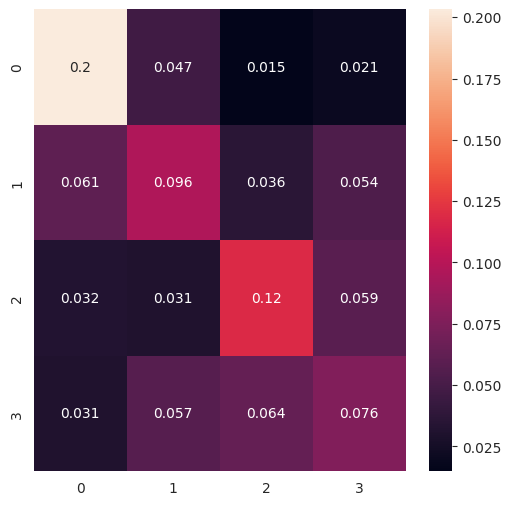

In [ ]:
train_and_plot(x_train, y_train, x_test, y_test)

Качество немного улучшилось.

### KMeans

Можем использовать алгоритмы кластеризации, чтобы получить новые признаки. Количество кластеров можно подбирать, оно не всегда должно быть равно количеству классов. Для примера возьмем `n_clusters=12`.

In [ ]:
import sklearn.cluster as cluster

clusters = cluster.KMeans(n_clusters=12, n_init="auto", random_state=42).fit(x_train)

x_train["new_feature_2"] = clusters.predict(x_train)
x_test["new_feature_2"] = clusters.predict(x_test)
x_train.head(3)

Age  Work_Experience  Family_Size  Gender_Female  Gender_Male  \
5015   49              1.0          2.0              0            1   
5755   87              0.0          2.0              0            1   
7781   28              8.0          3.0              1            0   

      Ever_Married_0  Ever_Married_No  Ever_Married_Yes  Graduated_0  \
5015               0                0                 1            0   
5755               0                0                 1            0   
7781               0                1                 0            0   

      Graduated_No  ...  Var_1_0  Var_1_Cat_1  Var_1_Cat_2  Var_1_Cat_3  \
5015             0  ...        0            0            0            0   
5755             0  ...        0            0            0            0   
7781             0  ...        0            0            0            0   

      Var_1_Cat_4  Var_1_Cat_5  Var_1_Cat_6  Var_1_Cat_7  new_feature_1  \
5015            0            0            1            0              1   
5755            0            0            1            0              1   
7781            0            0            1            0              1   

      new_feature_2  
5015              6  
5755              4  
7781              2  

[3 rows x 34 columns]

Training Accuracy:  0.966
Testing Accuracy:  0.503
              precision    recall  f1-score   support

           1       0.63      0.71      0.67       692
           2       0.43      0.40      0.42       597
           3       0.50      0.49      0.50       580
           4       0.39      0.37      0.38       552

    accuracy                           0.50      2421
   macro avg       0.49      0.49      0.49      2421
weighted avg       0.50      0.50      0.50      2421



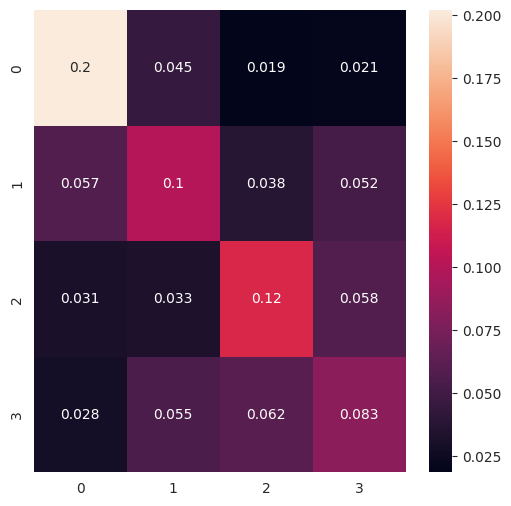

In [ ]:
train_and_plot(x_train, y_train, x_test, y_test)

## Ручная генерация признаков

Можем генерировать признаки самостоятельно, придумывая различные гипотезы и эвристики. Это творческий процесс, и нет точного рецепта, какие признаки стоит сгенерировать. Также генерация признаков зависит от модели, для которой эти признаки генерируем. Например, признаки, описывающие нелинейное взаимодействие, могут кардинально изменить качество линейной модели.

Наша задача — рассмотреть инструменты для генерации признаков.

In [ ]:
data = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/customer_segmentation.csv"
)
data.dropna(inplace=True)

In [ ]:
data.head(3)

ID  Gender Ever_Married  Age Graduated  Profession  Work_Experience  \
0  462809    Male           No   22        No  Healthcare              1.0   
2  466315  Female          Yes   67       Yes    Engineer              1.0   
3  461735    Male          Yes   67       Yes      Lawyer              0.0   

  Spending_Score  Family_Size  Var_1 Segmentation  
0            Low          4.0  Cat_4            D  
2            Low          1.0  Cat_6            B  
3           High          2.0  Cat_6            B

В этот раз закодируем признаки по их присутствию в данных:

In [ ]:
data["Profession"].value_counts()

Artist           2192
Healthcare       1077
Entertainment     809
Doctor            592
Engineer          582
Executive         505
Lawyer            500
Marketing         233
Homemaker         175
Name: Profession, dtype: int64

In [ ]:
data["Gender"] = data["Gender"].map({"Male": 1, "Female": 0})

data["Graduated"] = data["Graduated"].map({"Yes": 1, "No": 0})

data["Ever_Married"] = data["Ever_Married"].map({"Yes": 1, "No": 0})

data["Spending_Score"] = data["Spending_Score"].map({"High": 1, "Average": 2, "Low": 3})

data["Var_1"] = data["Var_1"].map(
    {"Cat_6": 1, "Cat_4": 2, "Cat_3": 3, "Cat_2": 4, "Cat_7": 5, "Cat_1": 6, "Cat_5": 7}
)

data["Segmentation"] = data["Segmentation"].map({"D": 1, "A": 2, "C": 3, "B": 4})

data["Profession"] = data["Profession"].map(
    {
        "Artist": 1,
        "Healthcare": 2,
        "Entertainment": 3,
        "Doctor": 4,
        "Engineer": 5,
        "Executive": 5,
        "Lawyer": 6,
        "Marketing": 7,
        "Homemaker": 8,
    }
)
data.head(5)

ID  Gender  Ever_Married  Age  Graduated  Profession  Work_Experience  \
0  462809       1             0   22          0           2              1.0   
2  466315       0             1   67          1           5              1.0   
3  461735       1             1   67          1           6              0.0   
5  461319       1             1   56          0           1              0.0   
6  460156       1             0   32          1           2              1.0   

   Spending_Score  Family_Size  Var_1  Segmentation  
0               3          4.0      2             1  
2               3          1.0      1             4  
3               1          2.0      1             4  
5               2          2.0      1             3  
6               3          3.0      1             3

Можем производить различные математические операции с признаками: перемножать, делить, складывать и т.д. Для временных рядов полезно брать производные, считать стандартное отклонение и т.д

Для примера перемножим признак `Age` и `Work_Experience`

In [ ]:
data["new_feature_1"] = data["Age"] * data["Work_Experience"]
data.head(3)

ID  Gender  Ever_Married  Age  Graduated  Profession  Work_Experience  \
0  462809       1             0   22          0           2              1.0   
2  466315       0             1   67          1           5              1.0   
3  461735       1             1   67          1           6              0.0   

   Spending_Score  Family_Size  Var_1  Segmentation  new_feature_1  
0               3          4.0      2             1           22.0  
2               3          1.0      1             4           67.0  
3               1          2.0      1             4            0.0

Полезный метод для генерации признаков — это `pd.groupby` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html).

Посчитаем средний возраст для каждой профессии и опыта работы:

In [ ]:
data["new_feature_2"] = data.groupby(["Profession", "Work_Experience"], as_index=False)[
    "Age"
].transform("mean")
data.head(3)

ID  Gender  Ever_Married  Age  Graduated  Profession  Work_Experience  \
0  462809       1             0   22          0           2              1.0   
2  466315       0             1   67          1           5              1.0   
3  461735       1             1   67          1           6              0.0   

   Spending_Score  Family_Size  Var_1  Segmentation  new_feature_1  \
0               3          4.0      2             1           22.0   
2               3          1.0      1             4           67.0   
3               1          2.0      1             4            0.0   

   new_feature_2  
0      26.739255  
2      48.608466  
3      75.520548

Можно использовать разные функции. Например, медиану:

In [ ]:
data["new_feature_3"] = data.groupby(["Spending_Score", "Family_Size"], as_index=False)[
    "Var_1"
].transform("median")
data.head(3)

ID  Gender  Ever_Married  Age  Graduated  Profession  Work_Experience  \
0  462809       1             0   22          0           2              1.0   
2  466315       0             1   67          1           5              1.0   
3  461735       1             1   67          1           6              0.0   

   Spending_Score  Family_Size  Var_1  Segmentation  new_feature_1  \
0               3          4.0      2             1           22.0   
2               3          1.0      1             4           67.0   
3               1          2.0      1             4            0.0   

   new_feature_2  new_feature_3  
0      26.739255            1.0  
2      48.608466            1.0  
3      75.520548            1.0

Также можем написать свою функции и использовать ее:

In [ ]:
import numpy as np

custom_func = lambda x: np.percentile(x, 75)
data["new_feature_4"] = data.groupby(["Spending_Score", "Family_Size"], as_index=False)[
    "Age"
].transform(custom_func)
data.head(3)

ID  Gender  Ever_Married  Age  Graduated  Profession  Work_Experience  \
0  462809       1             0   22          0           2              1.0   
2  466315       0             1   67          1           5              1.0   
3  461735       1             1   67          1           6              0.0   

   Spending_Score  Family_Size  Var_1  Segmentation  new_feature_1  \
0               3          4.0      2             1           22.0   
2               3          1.0      1             4           67.0   
3               1          2.0      1             4            0.0   

   new_feature_2  new_feature_3  new_feature_4  
0      26.739255            1.0           32.0  
2      48.608466            1.0           57.0  
3      75.520548            1.0           79.0

Можем сгенерировать новую таблицу признаков, используя `pivot_table` [🛠️[doc]](https://pandas.pydata.org/docs/reference/api/pandas.pivot_table.html):


```
data.pivot_table(
    index="index",
    columns=["columns"],  
    values=["values"],  
    aggfunc=["mean"],  
)
```


<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/pivot_table.png" width="700">

In [ ]:
data_pivot = data.pivot_table(
    index="Family_Size",  # indexes
    columns=["Var_1"],  # new columns
    values=["Age"],  # values are used fo aggfunc
    aggfunc=["mean", "count"],  # mean/count/sum
).fillna(0)

data_pivot.columns = [f"Cat{int(i[2])}_{i[0]}" for i in data_pivot.columns]
data_pivot.reset_index(inplace=True)

data_pivot.head(3)

Family_Size  Cat1_mean  Cat2_mean  Cat3_mean  Cat4_mean  Cat5_mean  \
0          1.0  49.434354  44.256637  46.272000  41.333333  40.041667   
1          2.0  51.064619  43.015625  39.494048  45.171053  44.159091   
2          3.0  42.033257  38.161290  36.627907  36.263889  37.935484   

   Cat6_mean  Cat7_mean  Cat1_count  Cat2_count  Cat3_count  Cat4_count  \
0  44.230769  42.777778       914.0       113.0       125.0        45.0   
1  42.187500  40.888889      1563.0       192.0       168.0        76.0   
2  34.476190  36.333333       872.0       155.0       129.0        72.0   

   Cat5_count  Cat6_count  Cat7_count  
0        24.0        13.0         9.0  
1        44.0        32.0        18.0  
2        31.0        21.0        12.0

А потом соединить ее с исходной:

In [ ]:
data = data.merge(data_pivot, how="inner", on="Family_Size")
data.head(3)

ID  Gender  Ever_Married  Age  Graduated  Profession  Work_Experience  \
0  462809       1             0   22          0           2              1.0   
1  465176       0             1   55          1           1              1.0   
2  464942       1             0   19          0           2              4.0   

   Spending_Score  Family_Size  Var_1  ...  Cat5_mean  Cat6_mean  Cat7_mean  \
0               3          4.0      2  ...  37.114286  39.047619  39.230769   
1               2          4.0      1  ...  37.114286  39.047619  39.230769   
2               3          4.0      2  ...  37.114286  39.047619  39.230769   

   Cat1_count  Cat2_count  Cat3_count  Cat4_count  Cat5_count  Cat6_count  \
0       726.0       158.0       132.0        89.0        35.0        21.0   
1       726.0       158.0       132.0        89.0        35.0        21.0   
2       726.0       158.0       132.0        89.0        35.0        21.0   

   Cat7_count  
0        13.0  
1        13.0  
2        13.0  

[3 rows x 29 columns]

Мы довольно быстро увеличили количество признаков в нашем датасете. Проверим, как это повлияло на качество:

In [ ]:
data.drop(columns=["ID"], inplace=True)

x = data.drop(columns=["Segmentation"], axis=1)
y = data["Segmentation"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42
)

print("Shape of x_train :", x_train.shape)
print("Shape of y_train :", y_train.shape)
print("Shape of x_test :", x_test.shape)
print("Shape of y_test :", y_test.shape)

Shape of x_train : (4665, 27)
Shape of y_train : (4665,)
Shape of x_test : (2000, 27)
Shape of y_test : (2000,)


Training Accuracy:  0.964
Testing Accuracy:  0.472
              precision    recall  f1-score   support

           1       0.60      0.67      0.63       530
           2       0.38      0.36      0.37       500
           3       0.50      0.52      0.51       495
           4       0.35      0.32      0.34       475

    accuracy                           0.47      2000
   macro avg       0.46      0.47      0.46      2000
weighted avg       0.46      0.47      0.47      2000



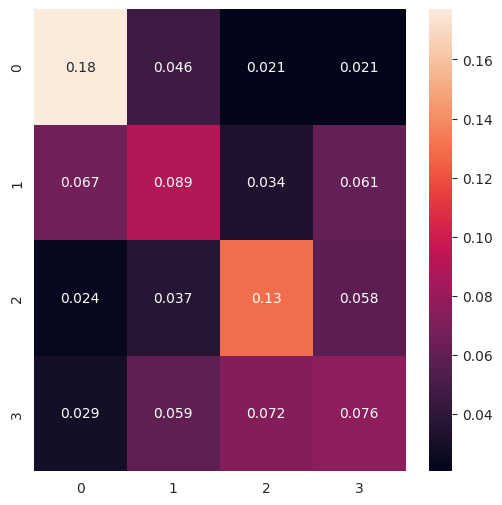

In [ ]:
train_and_plot(x_train, y_train, x_test, y_test)

Стало хуже. Возможно, какие-то признаки и улучшали качество, но другие его испортили сильнее. После того, как мы нагенерировали много признаков, стоит задуматься о том, какие признаки улучшают качество, а какие его ухудшают.

# Отбор признаков

Рассмотрим способы и подходы, чтобы отделять полезные признаки от бесполезных.

## Зачем отбирать признаки

* **Количество необходимых признаков может оказаться избытычным для решения задачи**

Не всегда нужно использовать все признаки, которые у нас есть и которые мы можем нагенерировать. Нам нужны только те признаки, которые позволяют решить задачу.


* **Некоторые признаки могут оказаться шумом**

Признаки могут коррелировать с целевой переменной случайно. Если провести эксперимент и сгенерировать большое количество случайных признаков для нашего датасета, мы можем заметить эффект, что некоторые из них действительно улучшают качество предсказания, но это никак не связано с реальной закономерностью. На новых (тестовых) данных мы обнаружим неадекватность предсказаний.

В более общем случае можно говорить, что в многомерном пространстве почти всегда можно найти корреляции:

<center><img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/fake_correlations.png" alt="alttext" width="700"/></center>

<center><em>В многоразмерном пространстве почти всегда можно найти корреляции. Из корреляции не следует причинно-следственная связь.</em></center>

<center><em>Source: <a href="https://tylervigen.com/spurious-correlations">Spurious correlations</a></em></center>

[[blog] ✏️ Больше подобных примеров](https://www.wnycstudios.org/podcasts/otm/articles/spurious-correlations)

**Скорость работы модели часто имеет значение**

В практических задачах часто приходится искать компромисс между точностью предсказания модели и временем его получения.

Спектр таких задач достаточно широк: от проблем построения быстрых систем ранжирования рекламных объявлений в интернет-маркетинге до построения быстрых систем распознавания сложных событий на ускорителях заряженных частиц.

Вычислительная сложность модели растёт с увеличением числа входных признаков, поэтому работающие с меньшим числом признаков модели являются предпочтительными.

## Полный перебор

Можно попытаться перебрать все возможные комбинации признаков. Однако даже для 100 признаков такой подход будет считаться до конца Вселенной.

Потому прибегают к эвристикам, которые могут пропускать оптимальное решение.

## Одномерный отбор признаков

Самый простой подход к отбору признаков — это одномерный подход. В нём оценивается связь каждого признака с целевой переменной, например, измеряется корреляция.

Такой подход не учитывает сложные закономерности: в нём все признаки считаются независимыми, тогда как в машинном обучении модели учитывают взаимное влияние признаков, их пар или даже более сложные взаимодействия.

Будем использовать датасет Титаник, загрузим данные:

In [ ]:
import pandas as pd

dataset = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/titanic.csv"
)
dataset.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

Сделаем предобработку и кодирование признаков:

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import numpy as np

title_mapping = {"Mr": 4, "Miss": 3, "Mrs": 2, "Master": 1}
# get title from name and encode by title_mapping, another titles fill zero
dataset["Title"] = (
    dataset.Name.str.extract(" ([A-Za-z]+)\.", expand=False)
    .map(title_mapping)
    .fillna(0)
)
# encode to binary column
dataset["Sex"] = dataset["Sex"].map({"male": 1, "female": 0})
# ordinary encode by values_count
dataset["Embarked"] = dataset["Embarked"].map({np.nan: 0, "S": 0, "Q": 1, "C": 2})
# parse cabin to get deck A, B, C etc
dataset["Deck"] = dataset["Cabin"].str.extract("([A-Za-z])")
# parse cabin to get cabin number
dataset["Cabin_Number"] = dataset["Cabin"].str.extract("(\d+)").astype(float).fillna(0)
# get sqrt fare
dataset["sqrt_Fare"] = np.sqrt(dataset["Fare"])
# deck encode to ohe format
deck_to_ohe = pd.get_dummies(dataset["Deck"], prefix="Cab", dummy_na=True)
# add ohe features to dataset
dataset = pd.concat([dataset, deck_to_ohe], axis=1)
# drop unnecessary columns
dataset.drop(
    columns=["Name", "Ticket", "Cabin", "PassengerId", "Deck", "Fare"], inplace=True
)
# train imputer to fiil nans for age
imputer = IterativeImputer()
imputer.fit(dataset[["Age", "Title", "sqrt_Fare"]])
# fill age nans by imputer
dataset["Age"] = imputer.transform(dataset[["Age", "Title", "sqrt_Fare"]])

dataset.head(5)

Survived  Pclass  Sex   Age  SibSp  Parch  Embarked  Title  Cabin_Number  \
0         0       3    1  22.0      1      0         0    4.0           0.0   
1         1       1    0  38.0      1      0         2    2.0          85.0   
2         1       3    0  26.0      0      0         0    3.0           0.0   
3         1       1    0  35.0      1      0         0    2.0         123.0   
4         0       3    1  35.0      0      0         0    4.0           0.0   

   sqrt_Fare  Cab_A  Cab_B  Cab_C  Cab_D  Cab_E  Cab_F  Cab_G  Cab_T  Cab_nan  
0   2.692582      0      0      0      0      0      0      0      0        1  
1   8.442944      0      0      1      0      0      0      0      0        0  
2   2.815138      0      0      0      0      0      0      0      0        1  
3   7.286975      0      0      1      0      0      0      0      0        0  
4   2.837252      0      0      0      0      0      0      0      0        1

Дополнительно добавим в наш датасет случайные признаки, чтобы оценить, как методы отбора будут учитывать их:

In [ ]:
random_features = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/random_features.csv"
)
dataset = pd.concat([dataset, random_features], axis=1)
dataset.head(5)

Survived  Pclass  Sex   Age  SibSp  Parch  Embarked  Title  Cabin_Number  \
0         0       3    1  22.0      1      0         0    4.0           0.0   
1         1       1    0  38.0      1      0         2    2.0          85.0   
2         1       3    0  26.0      0      0         0    3.0           0.0   
3         1       1    0  35.0      1      0         0    2.0         123.0   
4         0       3    1  35.0      0      0         0    4.0           0.0   

   sqrt_Fare  ...  Cab_E  Cab_F  Cab_G  Cab_T  Cab_nan  random_1  random_2  \
0   2.692582  ...      0      0      0      0        1       9.4         3   
1   8.442944  ...      0      0      0      0        0       9.8         2   
2   2.815138  ...      0      0      0      0        1       9.8         3   
3   7.286975  ...      0      0      0      0        0       9.8         2   
4   2.837252  ...      0      0      0      0        1       9.4         3   

   random_3  random_4  random_5  
0       1.0         2         2  
1       1.0         1         1  
2       4.0         2         2  
3       1.0         3         1  
4       3.0         2         1  

[5 rows x 24 columns]

Оценим, как признаки коррелируют с целевой переменной. Будем использовать корреляцию Пирсона, но можно использовать и другую:

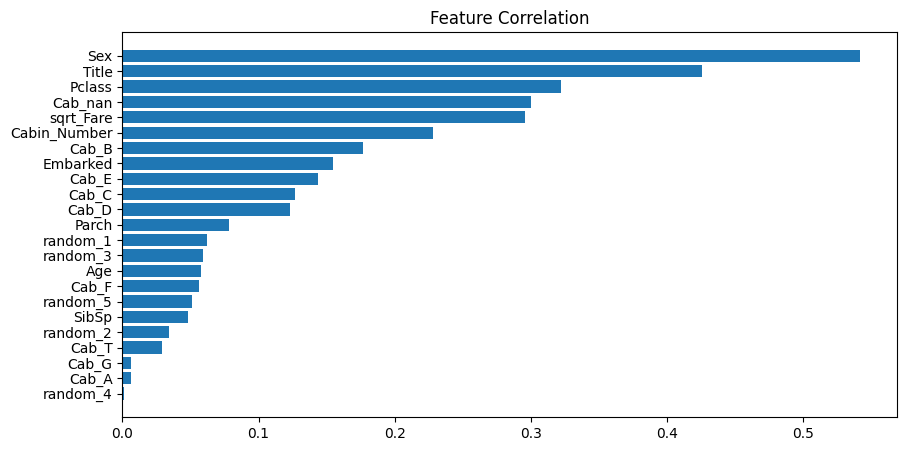

In [ ]:
from scipy import stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

x = dataset.drop(columns=["Survived"])
y = dataset["Survived"]

x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

correlations = []  # create a storage for correlations
for column in x:
    r, p_value = stats.pearsonr(x_train[column], y_train)  # compute Pearson and R
    correlations.append((column, abs(r).round(3)))  # add to storage

df_corr = (
    pd.DataFrame(correlations, columns=["Corr_feature", "Correlation"])
    .sort_values("Correlation", ascending=False)
    .reset_index(drop=True)
)

sorted_idx = np.argsort(df_corr["Correlation"])
fig = plt.figure(figsize=(10, 5))
plt.barh(
    range(df_corr.shape[0]), df_corr["Correlation"].iloc[sorted_idx], align="center"
)
plt.yticks(range(df_corr.shape[0]), df_corr["Corr_feature"].iloc[sorted_idx])
plt.title("Feature Correlation")
plt.show()

Следующая идея — посчитать ROC-AUC по признаку, учитывая его как предсказание модели. Если ROC-AUC высокий (нас интересуют только абсолютные значения), то признак важный.

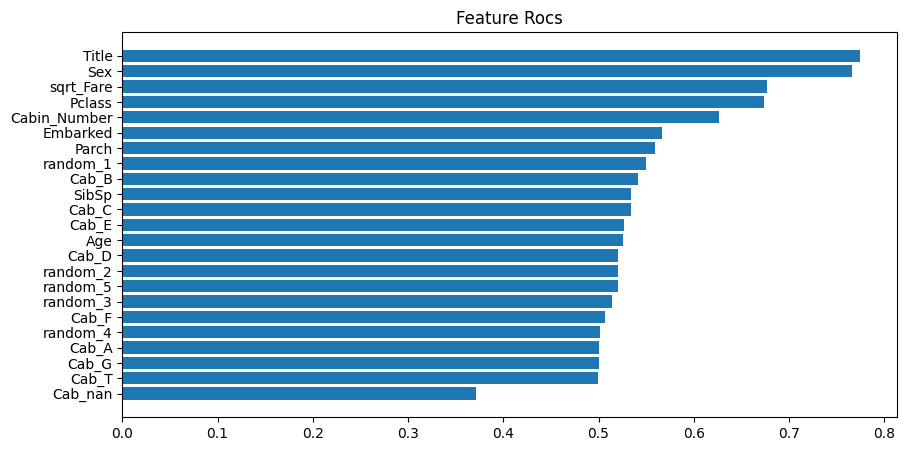

In [ ]:
from sklearn.metrics import roc_auc_score

rocs = []  # create a storage for ROCs
for column in x:
    # use feature as score directly
    r1 = roc_auc_score(y_score=x_train[column], y_true=y_train)
    # use feature as score in reversed manner
    r2 = roc_auc_score(y_score=-x_train[column], y_true=y_train)
    r = max(r1, r2)
    rocs.append((column, r.round(3)))

df_rocs = (
    pd.DataFrame(rocs, columns=["Rocs_feature", "Rocs"])
    .sort_values("Rocs", ascending=False)
    .reset_index(drop=True)
)  # sort from highest to lowest

sorted_idx = np.argsort(df_rocs["Rocs"])
fig = plt.figure(figsize=(10, 5))
plt.barh(range(df_rocs.shape[0]), df_rocs["Rocs"].iloc[sorted_idx], align="center")
plt.yticks(range(df_rocs.shape[0]), df_rocs["Rocs_feature"].iloc[sorted_idx])
plt.title("Feature Rocs")
plt.show()

Или использовать уже нам знакомую phik корреляцию:

In [ ]:
!pip install -q phik

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 4.6 MB/s eta 0:00:00


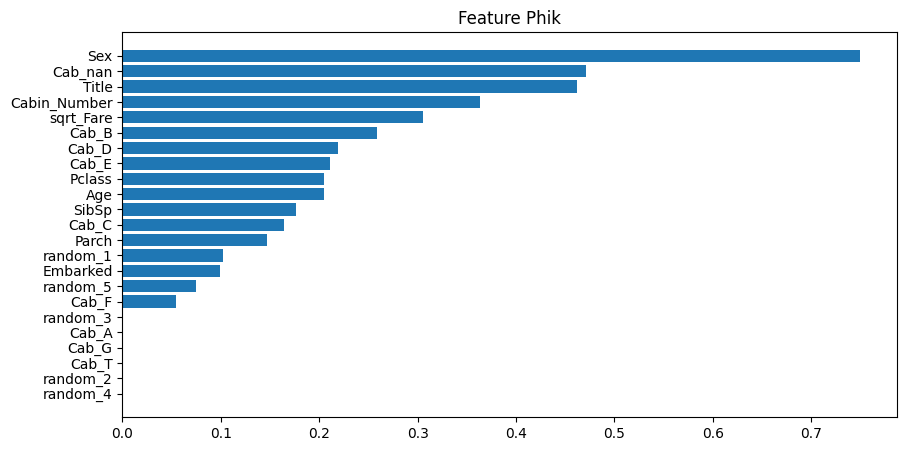

In [ ]:
import phik

df_phik = (
    dataset.phik_matrix(interval_cols=dataset.columns)
    .round(3)
    .sort_values("Survived", ascending=False)
    .reset_index()[["index", "Survived"]][1:]
    .rename(columns={"index": "Phik_feature", "Survived": "Phik"})
    .reset_index(drop=True)
)

sorted_idx = np.argsort(df_phik["Phik"])
fig = plt.figure(figsize=(10, 5))
plt.barh(range(df_phik.shape[0]), df_phik["Phik"].iloc[sorted_idx], align="center")
plt.yticks(range(df_phik.shape[0]), df_phik["Phik_feature"].iloc[sorted_idx])
plt.title("Feature Phik")
plt.show()

Посмотрим все методы в общей таблице, чтобы сравнить порядок признаков:

In [ ]:
pd.concat([df_corr, df_rocs, df_phik], axis=1)

Corr_feature  Correlation  Rocs_feature   Rocs  Phik_feature   Phik
0            Sex        0.542         Title  0.775           Sex  0.750
1          Title        0.426           Sex  0.766       Cab_nan  0.471
2         Pclass        0.322     sqrt_Fare  0.677         Title  0.462
3        Cab_nan        0.300        Pclass  0.674  Cabin_Number  0.363
4      sqrt_Fare        0.296  Cabin_Number  0.627     sqrt_Fare  0.306
5   Cabin_Number        0.228      Embarked  0.567         Cab_B  0.259
6          Cab_B        0.177         Parch  0.559         Cab_D  0.219
7       Embarked        0.155      random_1  0.550         Cab_E  0.211
8          Cab_E        0.144         Cab_B  0.541        Pclass  0.205
9          Cab_C        0.127         Cab_C  0.534           Age  0.205
10         Cab_D        0.123         SibSp  0.534         SibSp  0.176
11         Parch        0.078         Cab_E  0.527         Cab_C  0.164
12      random_1        0.062           Age  0.526         Parch  0.147
13      random_3        0.059         Cab_D  0.520      random_1  0.102
14           Age        0.058      random_2  0.520      Embarked  0.099
15         Cab_F        0.056      random_5  0.520      random_5  0.075
16      random_5        0.051      random_3  0.514         Cab_F  0.055
17         SibSp        0.048         Cab_F  0.507         Cab_A  0.000
18      random_2        0.034      random_4  0.502         Cab_G  0.000
19         Cab_T        0.029         Cab_A  0.501         Cab_T  0.000
20         Cab_A        0.006         Cab_G  0.500      random_2  0.000
21         Cab_G        0.006         Cab_T  0.499      random_3  0.000
22      random_4        0.001       Cab_nan  0.371      random_4  0.000

Как мы видим, не все случайные признаки находятся в самом низу. Некоторые из них имеют более высокую оценку, чем наши исходные.

**Важно!** Это не означает, что признаки, которые находятся ниже случайных, плохие.

### Проблемы одномерного отбора признаков

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/problems_of_one_dimensional_feature_selection.png" alt="alttext" width="600"/>

У подхода, при котором важности всех признаков оцениваются по отдельности, есть свои недостатки. На левом рисунке изображена двумерная выборка, для которой необходимо решить задачу классификации. Если спроецировать данную выборку на ось абсцисс, то она будет разделима, хотя и будут присутствовать ошибки. Если же спроецировать данную выборку на ось ординат, то все объекты разных классов перемешаются, и выборка будет неразделима. В этом случае при использовании любого метода одномерного оценивания информативности первый признак будет информативен, а второй — совершенно неинформативен.

Тем не менее, видно, что если использовать эти признаки одновременно, то классы будут разделимы идеально. Второй признак важен, но он важен только в совокупности с первым, и методы одномерного оценивания информативности не способны это определить.

На рисунке справа показана выборка, на которой одномерные методы оценки информативности работают ещё хуже. В этом случае, если спроецировать выборку на ось абсцисс или ординат, то объекты классов перемешаются, и в обоих случаях данные будут совершенно неразделимы. И, согласно любому из описанных методов, оба признака неинформативны. Тем не менее, если использовать их одновременно, то, например, решающее дерево может идеально решить данную задачу классификации.

Пример: влияние роста и веса при предсказании вероятности сердечного заболевания. Избыточный вес может являться важным фактором, но оценить, является ли он избыточным или нормальным, можно только зная рост пациента.

## Отбор признаков на основе моделей

### Линейная модель

Использование весов признаков.

В линейных моделях перед признаками стоят веса. Веса при признаках можно интерпретировать как информативности: чем больше по модулю вес при признаке, тем больший вклад этот признак вносит в ответ модели.

**Важно! Признаки должны быть отмасштабированы!**

Дополнительно можно использовать регулиризацию для отбора признаков.

Чем больше коэффициент при L1-регуляризаторе, тем меньше признаков будет использовать линейная модель (она занулит неинформативные признаки).

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/weight_importances.png" width="600">

[[doc] 🛠️ Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

Обучим линейную модель и посмотрим на веса для признаков:

<ipython-input-9-a050804d918b>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, y="name", x="coef", palette=df.colors, orient="h")


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

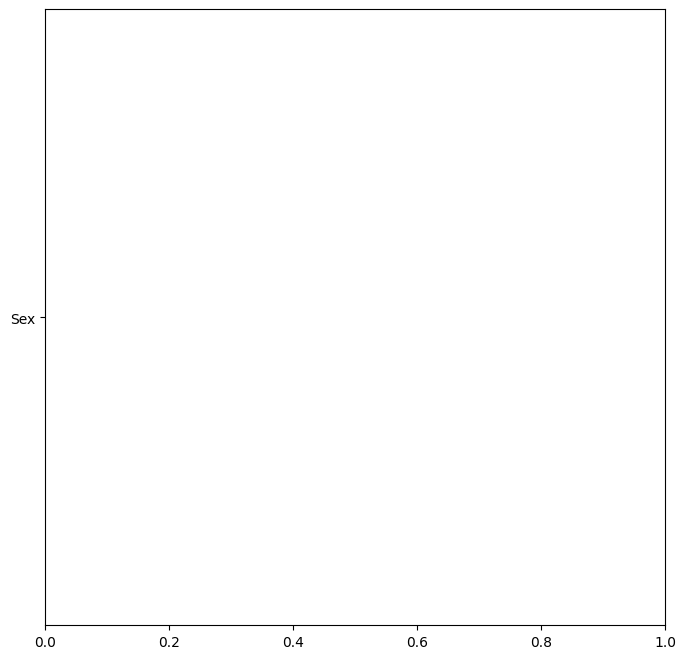

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(x_train_scaled, y_train)

df = pd.DataFrame({"name": x_train.columns, "coef": lr.coef_[0]}).sort_values(
    "coef", key=abs, ascending=False
)

df["colors"] = [
    sns.xkcd_rgb["orange"] if x < 0 else sns.xkcd_rgb["azure"] for x in df["coef"]
]


plt.figure(figsize=(8, 8))
sns.barplot(data=df, y="name", x="coef", palette=df.colors, orient="h")
plt.show()

Можно использовать `SelectFromModel` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) из библиотеки Sklearn для отбора наиболее значимых признаков:

In [ ]:
from sklearn.feature_selection import SelectFromModel

# selecting features based on importance weights
lr_selector = SelectFromModel(LogisticRegression(max_iter=1000))
lr_selector.fit(x_train_scaled, y_train)
x_train.columns[lr_selector.get_support()]  # Get a mask of the features selected

### Случайный лес

У случайного леса тоже есть свои важности признаков, только в этом случае важность признака определяется так: чем больше признак уменьшает impurity при разбиении, тем он более важный:

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(x_train, y_train)

df = pd.DataFrame(
    {"name": x_train.columns, "imp": rf.feature_importances_}
).sort_values("imp", key=abs, ascending=False)

df["colors"] = [
    sns.xkcd_rgb["orange"] if x < 0 else sns.xkcd_rgb["azure"] for x in df["imp"]
]


plt.figure(figsize=(8, 8))
sns.barplot(data=df, y="name", x="imp", palette=df.colors, orient="h")
plt.show()

In [ ]:
# select features with RFC
rf = RandomForestClassifier(n_estimators=500, random_state=42)

rf_selector = SelectFromModel(rf)
rf_selector.fit(x_train, y_train)  # Fit it on the training data

x_train.columns[rf_selector.get_support()]

### Градиентный бустинг

Такие же важности можно вытащить из градиентного бустинга. Рассмотрим на примере CatBoost:

In [ ]:
!pip install -q catboost

In [ ]:
from catboost import CatBoostClassifier

model = CatBoostClassifier(random_state=42, thread_count=-1)
model.fit(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    verbose=100,
    plot=False,
    early_stopping_rounds=100,
)

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)

fig = plt.figure(figsize=(10, 5))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), np.array(x.columns)[sorted_idx])
plt.title("Feature Importance catboost")
plt.show()

В CatBoost также есть свой метод отбора признаков `select_features` [🛠️[doc]](https://catboost.ai/en/docs/concepts/python-reference_catboost_select_features). Можно указать, какие признаки рассматривать для отбора (мы рассмотрим все признаки, параметр `features_for_select`) и количество признаков, которые нужно отобрать — `num_features_to_select`. Для примера отберем 5 признаков:

In [ ]:
summary = model.select_features(
    x_train,
    y_train,
    eval_set=(x_test, y_test),
    features_for_select="0-22",
    num_features_to_select=5,
    steps=1,
    train_final_model=False,
    logging_level="Silent",
)

In [ ]:
print(summary["selected_features_names"])

## Randomization/Permutation



Для определения важности признака можно перемешать его значения. Это не изменит форму распределения признака, но сделает его бессмысленным. По качеству модели мы можем оценить, каков был вклад признака до изменения: если качество упало сильно, то он был значимым.

В Sklearn это реализовано как отдельный класс `permutation_importance` [🛠️[doc]](https://scikit-learn.org/stable/modules/permutation_importance.html).

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/permutation_importance_example.png" alt="alttext" width="1000"/>

Изменение качества модели рассчитывается на объектах, которые не вошли в обучающую выборку, а остались для валидации (не путать с тестовой выборкой, которую мы не трогаем).

У данного метода есть три особенности:
1. Значение **важности признака** будет зависеть от **результата перемешивания**, которое носит случайный характер. Поэтому функция `permutation_importance` имеет параметр `n_repeats`, который определяет, сколько раз признак будет перемешиваться случайным образом.
2. Значение **важности признака** будет зависеть от **модели** и того, насколько “удачно” она обучена. “Плохая” и “хорошая” модель могут считать важным разный набор признаков. Поэтому полезно сравнить важность признаков модели, обучив модель на различных выборках (например, используя кросс-валидацию).
3. Данный метод неадекватно оценивает **важность коррелированных признаков**.

Для борьбы с неадекватной оценкой **коррелированных признаков** можно собрать коррелированные признаки в кластеры и оставить  только один признак для каждого [кластера 🛠️[doc]](https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-multicollinear-py).

Одна из вариаций `permutation importance` подразумевает **обучение модели заново** после каждого **перемешивания признаков**. Это дает чуть более адекватную оценку важности, но очень долго.

### Пример отбора признаков с помощью permutation importance

Сделаем `permutation importance`:

1. Обучаем модель.
2. Перемешиваем значения в одном столбце (одного признака), делаем предсказание на валидационном наборе данных и считаем ошибку. Ухудшение ошибки показывает важность признака, который перемешали.
3. Возвращаем значения признака и повторяем шаг 2 со всеми остальными признаками.

Ниже выполняются эти же операции, но уже с линейной моделью:

In [ ]:
from sklearn.inspection import permutation_importance

model = LogisticRegression()
model.fit(x_train_scaled, y_train)

r = permutation_importance(model, x_test_scaled, y_test, n_repeats=100, random_state=42)

df = pd.DataFrame({"name": x_train.columns, "imp": r.importances_mean}).sort_values(
    "imp", ascending=False
)
df["colors"] = [
    sns.xkcd_rgb["orange"] if x < 0 else sns.xkcd_rgb["azure"] for x in df["imp"]
]


plt.figure(figsize=(8, 8))
sns.barplot(data=df, y="name", x="imp", palette=df.colors, orient="h")
plt.show()

И со случайным лесом:

In [ ]:
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(x_train, y_train)

r = permutation_importance(model, x_test, y_test, n_repeats=100, random_state=42)

df = pd.DataFrame({"name": x_train.columns, "imp": r.importances_mean}).sort_values(
    "imp", ascending=False
)

df["colors"] = [
    sns.xkcd_rgb["orange"] if x < 0 else sns.xkcd_rgb["azure"] for x in df["imp"]
]


plt.figure(figsize=(8, 8))
sns.barplot(data=df, y="name", x="imp", palette=df.colors, orient="h")
plt.show()

Как видно, у некоторых признаков при переходе от древесных моделей к линейным важность признаков изменилась

## Boruta

Boruta развивает идею Permutation.

Увеличим наш датасет, добавив в него "теневые признаки" $-$ перемешанные реальные. Таким образом, наш датасет точно будет содержать хорошие признаки (мы ничего не удаляем).

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/boruta_idea.png" alt="alttext" width="600"/>

После этого обучаем модель и отбираем те признаки, чей `feature_importance` больше, чем у лучшего из теневых. Повторяем процедуру несколько раз для того,  чтобы удалить случайные скачки качества.

Таким образом, для каждого признака мы будем знать, сколько раз мы его отобрали. Получаем распределение. Самая большая неопределенность будет в середине (вероятность отобрать = 0.5):

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/boruta_diagram.png" alt="alttext" width="600"/>

[[blog] ✏️ Automated feature selection with boruta](https://www.kaggle.com/code/residentmario/automated-feature-selection-with-boruta)

Набор (в нашем случае из 20) испытаний Бернулли — это биномиальное распределение. Со значимостью, допустим, 0.05 берем все из «хорошего хвоста» и отбрасываем из «плохого хвоста». С признаками из середины колокола ничего особо не сделаешь: увеличение числа итераций приведет к ужатию колокола, но глобально не поможет.

Если нам нужна хорошо интерпретируемая модель, то надо брать только точно хорошие признаки.

### Пример отбора признаков с помощью Boruta

Будем использовать реализацию [boruta_py 🐾[git]](https://github.com/scikit-learn-contrib/boruta_py). Возьмем Random Forest модель.

In [ ]:
model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(x_train, y_train)

Попробуем применить алгоритм Boruta к этому же датасету и сократить количество признаков.
Оценим текущее качество модели, используя ROC-AUC:

In [ ]:
pred = model.predict_proba(x_test)[:, 1]
r1 = roc_auc_score(y_score=pred, y_true=y_test)

print(f"ROC-AUC: {r1:.4f}")

Загрузим Boruta:

In [ ]:
!pip install -q boruta

Питоновская реализация Boruta соответствует  API sklearn и может использоваться как в конвейере, так и самостоятельно.

Boruta работает с `numpy.array`, поэтому используем `.values()` :

In [ ]:
print(type(x_train))
print(type(x_train.values))

Проведем оценку признаков при помощи Boruta.



In [ ]:
from boruta import BorutaPy

# define Boruta feature selection method
model = RandomForestClassifier(n_estimators=500, random_state=42)


feat_selector = BorutaPy(model, n_estimators=100, verbose=1, random_state=42)

# find all relevant features
feat_selector.fit(x_train.values, y_train.values)

Посмотрим, как оценила признаки Boruta:

In [ ]:
keep = x_train.columns[feat_selector.support_].to_list()
normal = x_train.columns[feat_selector.support_weak_].to_list()
drop = x_train.columns[
    ~(feat_selector.support_ | feat_selector.support_weak_)
].to_list()

print("features keep:", keep)
print("features normal:", normal)
print("features drop:", drop)

Посмотрим на более подробную информацию о результатах отбора:

In [ ]:
feature_ranks = list(
    zip(x_train.columns, feat_selector.ranking_, feat_selector.support_)
)

df = pd.DataFrame(feature_ranks, columns=["feature", "rank", "boruta_keep"])
df.sort_values("rank")

Boruta из 23 признаков предлагает оставить только 4: **Sex, Age, Title, sqrt_Fare**.

 Зная информацию о ранге признака, мы можем взять больше признаков для обучения. Также обратите внимание, что случайный признак находится довольно высоко.



Обучим алгоритм на признаках, отобранных Boruta.
Давайте проверим, можем ли мы добиться такого же результата, если проанализируем и уберем «лишние» данные?

In [ ]:
# Build the model with the random forest algorithm

model = RandomForestClassifier(n_estimators=500, random_state=42)
model.fit(x_train[keep], y_train)

pred = model.predict_proba(x_test[keep])[:, 1]
r1 = roc_auc_score(y_score=pred, y_true=y_test)

print(f"ROC-AUC: {r1:.4f}")

Качество упало, но не так сильно. Можно поэкспериментировать с добавлением признаков более низкого ранга.

## Жадный отбор признаков

Жадные методы отбора признаков по сути являются надстройками над методами обучения моделей. Они перебирают различные подмножества признаков и выбирают то из них, которое дает наилучшее качество определённой модели машинного обучения.

Данный процесс устроен следующим образом:

Обучение модели считается черным ящиком, который на вход принимает информацию о том, какие из его признаков можно использовать при обучении модели, обучает модель, и дальше каким-то методом оценивается качество такой модели, например, по отложенной выборке или кросс-валидации. Таким образом, задача, которую необходимо решить — это оптимизация функционала качества модели по подмножеству признаков.

**Полный перебор**

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/full_sorting.png" alt="alttext" width="600"/>

Самый простой способ решения данной задачи — это полный перебор всех подмножеств признаков и оценивание качества на каждом подмножестве. Итоговое подмножество — то, на котором качество модели наилучшее. Этот перебор можно структурировать и перебирать подмножества последовательно: сначала те, которые имеют мощность 1 (наборы из 1 признака), потом наборы мощности 2, и так далее. Это подход очень хороший, он найдет оптимальное подмножество признаков, но при этом очень сложный, поскольку всего таких подмножеств $2^d -1$, где $d$ — число признаков (пустое множество не рассматриваем). Если признаков много — сотни или тысячи, то такой перебор невозможен: он займет слишком много времени, возможно, сотни лет или больше. Поэтому, такой метод подходит либо при небольшом количестве признаков, либо если известно, что информативных признаков очень мало, единицы.

**Жадное добавление**

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/greedy_addition.png" alt="alttext" width="600"/>

 Жадная стратегия используется всегда, когда полный перебор не подходит для решения задачи. Например, может оказаться неплохой стратегия жадного наращивания (жадного добавления). Сначала находится один признак, который дает наилучшее качество модели (наименьшую ошибку $Q$):

$i_1 = argmin Q(i)$.

Тогда множество, состоящее из этого признака:

$J_1 = {i_1}$

Дальше к этому множеству добавляется еще один признак так, чтобы как можно сильнее уменьшить ошибку модели:

$i_2 =argminQ(i_1,i)$, $J_2 ={i_1,i_2}$.

Далее каждый раз добавляется по одному признаку, образуются множества $J_3 , J_4 , . . . .$ Если в какой-то момент невозможно добавить новый признак так, чтобы уменьшить ошибку, процедура останавливается. Жадность процедуры заключается в том, что как только какой-то признак попадает в оптимальное множество, его нельзя оттуда удалить.

[[doc] 🛠️ Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)

[[doc] 🛠️ Model-based and sequential feature selection](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py)

[[doc] 🛠️ Sequential Feature Selection for Regression](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-5-sequential-feature-selection-for-regression)

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold


sfs = SequentialFeatureSelector(
    RandomForestClassifier(random_state=42),
    k_features=8,  # number of features to select
    forward=True,  # True - add, False - del
    floating=False,
    scoring="accuracy",
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
)
sfs.fit(x_train, y_train)

df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
df.head(df.shape[0])

In [ ]:
df["feature_names"].values[-1]

In [ ]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

plot_sfs(sfs.get_metric_dict(), kind="std_dev")

plt.title("Sequential Forward Selection (StdDev)")
plt.grid()
plt.show()

### ADD-DEL

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/non_greedy.png" width="600">

Описанный выше подход довольно быстрый: в нем столько итераций, сколько признаков в выборке. Но при этом он слишком жадный: перебирается слишком мало вариантов, и мы можем оказаться в плохой локальной точке. Процедуру можно усложнить. Один из подходов к усложнению — это алгоритм **ADD-DEL**, который не только добавляет, но и удаляет признаки из оптимального множества.

Алгоритм начинается с процедуры жадного добавления. Множество признаков наращивается до тех пор, пока получается уменьшить ошибку, затем признаки жадно удаляются из подмножества, то есть перебираются все возможные варианты удаления признака, оценивается ошибка и удаляется тот признак, удаление которого приводит к наибольшему уменьшению ошибки на выборке. Эта процедура повторяет добавление и удаление признаков до тех пор, пока уменьшается ошибка. Алгоритм ADD-DEL всё еще жадный, но при этом он менее жадный, чем предыдущий, поскольку *может исправлять ошибки*, сделанные в начале перебора: если вначале был добавлен неинформативный признак, то на этапе удаления от него можно избавиться.

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/add_del.png" width="900">

In [ ]:
sffs = SequentialFeatureSelector(
    RandomForestClassifier(random_state=42),  # represents the classifier
    k_features=8,  # the number of features you want to select
    forward=True,  # add features
    floating=True,  # remove features
    scoring="accuracy",  # means that the selection will be decided by the accuracy of the classifier.
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
)

sffs.fit(x_train.values, y_train)  # performs the actual SFFS algorithm
df = pd.DataFrame.from_dict(sffs.get_metric_dict()).T
df.head(df.shape[0])

In [ ]:
x.iloc[:, list(df["feature_idx"].values[-1])].columns

In [ ]:
plot_sfs(sffs.get_metric_dict(), kind="std_dev")

plt.title("Sequential Forward Selection (StdDev)")
plt.grid()
plt.show()

## Рекомендации по отбору признаков

* Все методы отбора могут давать разные результаты, нужно использовать несколько и агрегировать их оценку.
* Начинайте с более простых и быстрых методов для оценки.
* Если объектов очень много, то можно использовать часть объектов для оценки, но важно, чтобы эта часть была репрезентативна.
* Отбор признаков чаще используется для интерпретации модели, анализа признаков и увеличения скорости работы, чем для улучшения качества предсказания.  


**Важно помнить**, что нельзя отбирать признаки на том же наборе данных, на котором тестируетесь.

Иначе получите завышенное качество вашей модели.

[[colab] 🥨 Эксперимент с неправильным отбором признаков](https://colab.research.google.com/drive/1nn8o--hy2siBqTKRowmW0cdD6Skh7-rY)

# Задача понижения размерности


Часто мы хотим данные из пространства высокой размерности перевести в пространство более низкой размености с сохранением одного или нескольких свойств, например:
* объекты реконструируются с минимальной ошибкой,
* расстояние между объектами сохраняется.


Мотивация понижения размерности:

1. Многие алгоритмы показывают себя плохо на пространствах большой размерности ([проклятие размерности 📚[wiki]](https://en.wikipedia.org/wiki/Curse_of_dimensionality)).

2. Некоторые просто будут значительно дольше работать, при этом качество их работы не изменится от уменьшения размерности.

3. Понижение размерности позволяет использовать память более эффективно и подавать модели на обучение за один раз больше объектов.

4. Избавиться от шумовых признаков.

5. Задача визуализации: хочется взглянуть на наши объекты, а делать это в 100-мерном или 100000-мерном пространстве невозможно.

6. Удаление выбросов — в пространствах меньшей размерности можем их увидеть глазами.

7. Можем увидеть закономерности в данных: что они разделяются на явные кластеры и т. д.



## Manifold assumption

В машинном обучении часто используют предположение о многообразии (manifold assumption). Это предположение о том, что между признаками, описывающими реальные объекты, существуют некоторые нетривиальные связи. Вследствие этого данные заполняют не весь объем пространства признаков, а лежат на некоторой поверхности — на **многообразии** (manifold).

Если предположение верно, то каждый объект может быть достаточно точно описан новыми признаками в пространстве значительно меньшей размерности, чем исходное пространство признаков.

При этом мы будем терять часть информации об объектах. Но при выполнении предположения о многообразии (а оно почти всегда выполняется) и при правильных настройках алгоритма понижения размерности эти потери будут незначительны.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/manifold_assumption.png" width="600">

В большинстве случаев это действительно правда. Например, лица людей даже на фотографиях $300\times300$ лежат в пространстве меньшей размерности, нежели $90000$. Не каждая матрица размером $300\times300$, заполненная какими-то значениями от $0$ до $1$, даст нам изображение лица человека.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/faces_in_space_of_smaller_dimension.png" width="600">

## PCA (Метод главных компонент)

Метод главных компонент (Principal Component Analysys, PCA) — простейший линейный метод снижения размерности, описан [Пирсоном в 1901 году 📚[book]](http://pca.narod.ru/pearson1901.pdf).



<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/introduction_pca.png" width="900"/>

#### Максимизация дисперсии выборки после понижения размерности

Рассмотрим простой пример для понимания интуиции, которая стоит за методом главных компонент.

У нас есть выборка объектов с двумя признаками $x_1$ и $x_2$, отобразим их на плоскости. Мы хотим, чтобы у нас был только один признак, который характеризует наши данные. Тогда наша задача — провести прямую через наши точки так, чтобы она наилучшим образом характеризовала наши данные

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/pca_dataset_example.png" width="400"/>

Проведем прямую вдоль максимального изменения данных и спроецируем точки на нее. Это и будет наша первая главная компонента.

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/first_component_example.png" width="900"/>

Теперь мы можем использовать только один признак, который лежит на новой оси, а любые отклонения от нее — это просто шум (в действительности, определить, что является шумом в данных — это нетривиальная задача).

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/proection_component.png" width="400"/>

Это то, как можно понимать интуицию работы PCA.

В более многомерном случае (например, при количестве признаков 200) мы бы делали то же самое:

1. Выбираем направление максимального изменения данных — это первая главная компонента.
2. Если данные описаны не полностью, то выбираем еще одно направление — перпендикулярное к первому, так, чтобы описать оставшееся изменение в данных.
3. Повторяем пункт 2, пока компонент не будет достаточно, вплоть до размерности исходного пространства. При этом каждая следующая компонента будет перпендикулярна предыдущим и объяснять меньше дисперсии, чем любая из них.

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/3d_to_2d_pca.png" width="1000"/>

### Практический пример использования PCA

Чтобы понять, как использовать PCA на практике, найдем главные компоненты для датасета и посмотрим, как распределится между ними дисперсия.

##### Без стандартизации



Скачаем датасет, на котором польза от понижения размерности видна более явно.

В данном датасете 977 признаков (нам сейчас не важно, какие), характеризующие клетки крови.

Загрузим датасет и подготовим данные

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

scRNAseq = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/scRNAseq_CITEseq.txt",
    sep="\t",
)

x = scRNAseq.iloc[:, 0:-1]  # features
y = scRNAseq.iloc[:, -1]  # labels

# 2. taking the log of the data.
x = np.log(x + 1)


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)
print(f"dataset shape: {x.shape}")
x

dataset shape: (8617, 976)


ABHD17A  ABHD5  ABI3  AC013264.2  AC017104.6  AC092580.4  \
CTGTTTACACCGCTAG      0.0    0.0   0.0         0.0         0.0         0.0   
CTCTACGGTGTGGCTC      0.0    0.0   0.0         0.0         0.0         0.0   
AGCAGCCAGGCTCATT      0.0    0.0   0.0         0.0         0.0         0.0   
GAATAAGAGATCCCAT      0.0    0.0   0.0         0.0         0.0         0.0   
GTGCATAGTCATGCAT      0.0    0.0   0.0         0.0         0.0         0.0   
...                   ...    ...   ...         ...         ...         ...   
TTGCCGTGTAGATTAG      0.0    0.0   0.0         0.0         0.0         0.0   
GGCGTGTAGTGTACTC      0.0    0.0   0.0         0.0         0.0         0.0   
CGTATGCCGTCTTCTG      0.0    0.0   0.0         0.0         0.0         0.0   
TACACGACGCTCTTCC      0.0    0.0   0.0         0.0         0.0         0.0   
ACACGACGCTCTTCCG      0.0    0.0   0.0         0.0         0.0         0.0   

                  AC093673.5  AC132872.2     ACRBP  ACSL1  ...  MOUSE_Rtn4  \
CTGTTTACACCGCTAG         0.0         0.0  0.000000    0.0  ...    4.406719   
CTCTACGGTGTGGCTC         0.0         0.0  0.000000    0.0  ...    4.330733   
AGCAGCCAGGCTCATT         0.0         0.0  0.693147    0.0  ...    4.634729   
GAATAAGAGATCCCAT         0.0         0.0  0.000000    0.0  ...    4.605170   
GTGCATAGTCATGCAT         0.0         0.0  0.000000    0.0  ...    4.276666   
...                      ...         ...       ...    ...  ...         ...   
TTGCCGTGTAGATTAG         0.0         0.0  0.000000    0.0  ...    0.000000   
GGCGTGTAGTGTACTC         0.0         0.0  0.000000    0.0  ...    0.000000   
CGTATGCCGTCTTCTG         0.0         0.0  0.000000    0.0  ...    0.000000   
TACACGACGCTCTTCC         0.0         0.0  0.000000    0.0  ...    0.693147   
ACACGACGCTCTTCCG         0.0         0.0  0.000000    0.0  ...    0.000000   

                  MOUSE_Ppp1ca  MOUSE_Cald1  MOUSE_Rps26  MOUSE_Ctsl  \
CTGTTTACACCGCTAG      3.663562     5.087596     3.135494    4.897840   
CTCTACGGTGTGGCTC      4.219508     4.454347     4.110874    4.356709   
AGCAGCCAGGCTCATT      4.248495     4.477337     4.110874    4.727388   
GAATAAGAGATCCCAT      4.276666     4.477337     4.442651    4.219508   
GTGCATAGTCATGCAT      4.488636     4.859812     4.077537    3.178054   
...                        ...          ...          ...         ...   
TTGCCGTGTAGATTAG      0.000000     0.000000     0.000000    0.000000   
GGCGTGTAGTGTACTC      0.000000     0.000000     0.000000    0.693147   
CGTATGCCGTCTTCTG      0.000000     0.693147     0.000000    0.000000   
TACACGACGCTCTTCC      0.693147     0.000000     0.000000    1.098612   
ACACGACGCTCTTCCG      0.000000     0.693147     0.000000    0.000000   

                  MOUSE_Tnfrsf12a  MOUSE_Esd  MOUSE_Acta2  MOUSE_Arpc2  \
CTGTTTACACCGCTAG         4.060443   4.077537     1.791759     4.204693   
CTCTACGGTGTGGCTC         4.025352   4.262680     4.248495     3.970292   
AGCAGCCAGGCTCATT         4.317488   3.637586     3.332205     4.234107   
GAATAAGAGATCCCAT         3.806662   4.394449     3.465736     4.143135   
GTGCATAGTCATGCAT         3.401197   2.639057     6.306275     4.543295   
...                           ...        ...          ...          ...   
TTGCCGTGTAGATTAG         0.000000   0.000000     0.693147     0.000000   
GGCGTGTAGTGTACTC         0.000000   0.000000     0.000000     0.000000   
CGTATGCCGTCTTCTG         0.000000   0.000000     0.000000     0.000000   
TACACGACGCTCTTCC         0.693147   0.693147     1.098612     1.098612   
ACACGACGCTCTTCCG         0.000000   0.000000     1.098612     0.000000   

                  MOUSE_Calr  
CTGTTTACACCGCTAG    3.091042  
CTCTACGGTGTGGCTC    3.526361  
AGCAGCCAGGCTCATT    4.343805  
GAATAAGAGATCCCAT    4.682131  
GTGCATAGTCATGCAT    3.465736  
...                      ...  
TTGCCGTGTAGATTAG    0.000000  
GGCGTGTAGTGTACTC    0.000000  
CGTATGCCGTCTTCTG    0.693147  
TACACGACGCTCTTCC    0.000000  
ACACGACGCTCTTCCG    0.693147  

[8617 rows x 976 

Полезной информацией является коэффициент объясненной дисперсии (explained variance ratio) главной компоненты. Этот коэффициент является отношением между дисперсией главной компоненты и суммой дисперсий всех главных компонент. Он указывает долю выборочной дисперсии, которая лежит вдоль оси каждой главной компоненты.

В модуле PCA после `fit` можно получить explained variance ratio посредством обращения к полю `explained_variance_ratio_`, а explained variance — посредством обращения к полю `explained_variance_`.



Построим график с `explained_variance_ratio_` для 10 компонент.

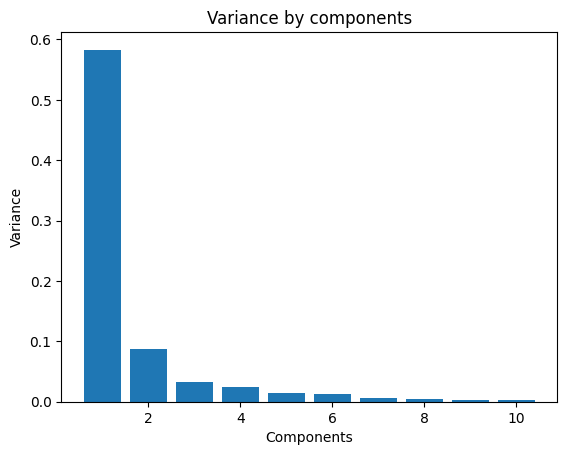

In [ ]:
import sklearn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# performing PCA with default number of principal components.
pca = PCA(n_components=10)
pca.fit(x_train)  # fitting our PCA model with the training data.
# calculating the explained variance of each of the components.
evr = pca.explained_variance_ratio_

# We are plotting the explained variance ratios.
plt.bar(range(1, evr.shape[0] + 1), evr)
plt.title("Variance by components")
plt.xlabel("Components")
plt.ylabel("Variance")
plt.show()

In [ ]:
pca.explained_variance_.shape

(10,)

Из графика не совсем понятно, сколько компонент брать, резко доля объясняемой дисперсии меняется в районе 2-й компоненты. Посмотрим, сколько компонент нужно модели.

In [ ]:
from sklearn.linear_model import LogisticRegression

pca = PCA(n_components=10)
pca.fit(x_train)
x_train_reduced = pca.transform(x_train)
x_test_reduced = pca.transform(x_test)

for i in range(1, 11):
    model = LogisticRegression(max_iter=1000)
    model.fit(x_train_reduced[:, :i], y_train)

    print("%i first components %.2f" % (i, model.score(x_test_reduced[:, :i], y_test)))

1 first components 0.46
2 first components 0.78
3 first components 0.89
4 first components 0.93
5 first components 0.94
6 first components 0.94
7 first components 0.95
8 first components 0.96
9 first components 0.96
10 first components 0.96


Видим, что уже первых 8 компонент достаточно для достижения качества, которое далее не меняется.


Дело в том, что мы забыли сделать **стандартизацию** данных.

В датасете переменные имеют совершенно разные масштабы. Из-за этого часть из них "перетегягивает" на себя всю дисперсию.

В результате по доле дисперсии судить о важности компонент нельзя.

##### Со стандартизацией

Сделаем предварительно стандартизацию

In [ ]:
# First, we import the StandardScaler module.
from sklearn.preprocessing import StandardScaler

# Next, we create a StandardScaler object called scaler by calling the
# StandardScaler() function.
scaler = StandardScaler()

#  We then fit the scaling model to our training data.
x_train = scaler.fit_transform(x_train)

# We transform your test set by applying the same scaling model.
x_test = scaler.transform(x_test)

# performing PCA with default number of principal components.
pca = PCA(n_components=10)
pca.fit(x_train)  # fitting our PCA model with the training data.

PCA(n_components=10)

В `PCA.components_` лежат векторы главных компонент, расположенные построчно (`n_components`, `n_features`).

In [ ]:
pca.components_.shape

(10, 976)

Обратите внимание, что PCA упорядочивает собственные векторы. Это значит, что собственный вектор, соответствующий главной компоненте и, соответственно, имеющей максимальную дисперсию, будет находиться в первой строке.

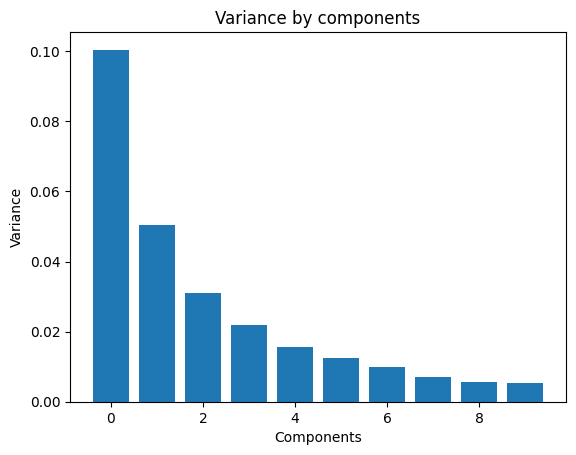

In [ ]:
# calculating the explained variance of each of the components.
evr = pca.explained_variance_ratio_

# We are plotting the explained variance ratios.
plt.bar(range(evr.shape[0]), evr)
plt.title("Variance by components")
plt.xlabel("Components")
plt.ylabel("Variance")
plt.show()

Теперь видим, что не только первые две компоненты дают вклад. Это происходит потому, что переменные отмасштабированы.

Но и значимого спада в доле объясняемой дисперсии мы не видим, поэтому встает вопрос: как выбрать число компонент так, чтобы взять нужное и отсечь ненужное?

### Как выбирать оптимальное число  компонент




Подбирать число компонент можно по-разному

#### По доле объясняемой дисперсии

Мы можем выбрать порог по доле объясняемой дисперсии, например 95%. Это быстрый споособ, но не ясно почему именно 95%, а не 90%.


724 components to 95% explained_variance_ratio


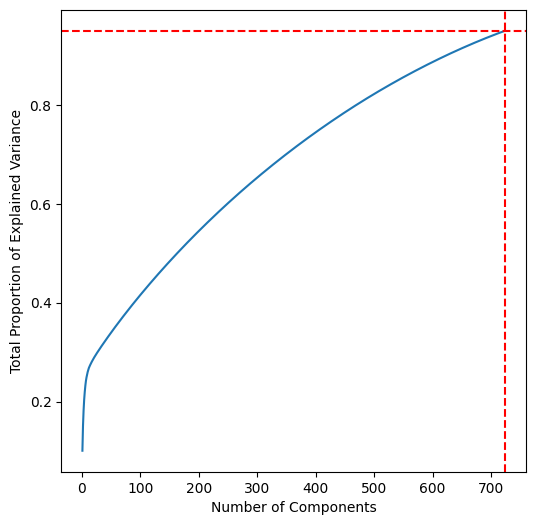

In [ ]:
pca = PCA(0.95)
pca.fit(x_train)

total_explained = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(6, 6))

plt.plot(np.arange(1, len(total_explained) + 1), total_explained)
plt.axhline(y=0.95, color="red", linestyle="--")
chosen_number = np.argmax(total_explained >= 0.95) + 1
plt.axvline(x=chosen_number, color="red", linestyle="--")
plt.ylabel("Total Proportion of Explained Variance")
plt.xlabel("Number of Components")
print(f"{chosen_number} components to 95% explained_variance_ratio")
plt.show()

Получилось 724 компоненты. При выборе другого порога получили бы другое количество компонент.


#### По правилу локтя

Можно построить график, отражающий, сколько дисперсии объясняет каждая из компонент, и на основе графика выбрать нужное число компонент.

Идея подхода простая: переход от компонент, объясняющих что-то важное в данных, к компонентам, объясняющим шум, должен сопровождаться резким снижением доли объясняемой дисперсии.

Или можно сказать иначе: выбранные нами компоненты должны быть устойчивы к добавлению шума в данные. Если мы нашли резкий скачок в доле объясняемой дисперсии, то маловероятно, что добавление шума этот скачок нивелирует — наш способ отбора компонент устойчив к шуму.

В идеальном случае график будет выглядеть как-то так. Но на практике таких склонов может не быть, а может быть несколько.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/elbow_rule.png" width="600">

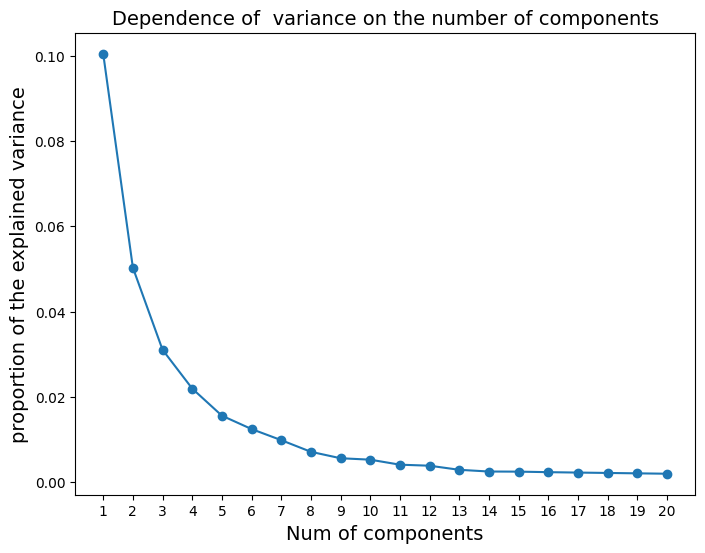

In [ ]:
n_comp = 20
pca = PCA(n_comp)
pca.fit(x_train)
explained = pca.explained_variance_ratio_

plt.figure(figsize=(8, 6))
plt.scatter(np.arange(1, n_comp + 1), explained)
plt.plot(np.arange(1, n_comp + 1), explained)
plt.title("Dependence of  variance on the number of components", size=14)
plt.xlabel("Num of components", size=14)
plt.ylabel("proportion of the explained variance", size=14)
plt.xticks(np.arange(1, n_comp + 1))
plt.show()


Из такого графика сложно понять, какое число компонент стоит выбрать.

#### Перестановочный метод

Еще одним способом выбрать число главных компонент является перестановочный метод. Он заключается в следующем:

1. Для каждого признака перемешиваем его значения.

2. Создаём матрицу признаков, которая не содержит информации о первоначальной структуре данных.

3. Применяем метод главных компонент (PCA).

4. Любая доля объяснённой дисперсии в данном случае возникает из-за особенностей данных, а не реальной структуры.

5. Этот процесс повторяется многократно, например, 100–1000 раз.

6. Для определённой  $k$ компоненты на реальных данных мы видим, какую часть дисперсии она объясняет.

7. Анализируем распределение доли дисперсии, которую $k$-я компонента объясняет в случайных данных (полученных перемешиванием).

8. Сравниваем это распределение с реальными данными, чтобы понять, объясняет ли $k$-я компонента что-то существенное или это просто случайный "шум".

In [ ]:
from tqdm import tqdm


def shuffle_dataset(dataset):
    random_data = {
        col: np.random.permutation(dataset[col].values) for col in dataset.columns
    }
    return pd.DataFrame(random_data)


def get_variance_by_chance(dataset, n_replics, n_components):
    variance_explained_by_chance = np.empty((n_replics, n_components))
    for i in tqdm(range(n_replics)):
        random_data = shuffle_dataset(dataset)
        random_pca = PCA(n_components=n_components)
        variance_explained_by_chance[i, :] = random_pca.fit(
            random_data
        ).explained_variance_ratio_
    return variance_explained_by_chance


def calc_permutat_pval(real_values, permut_values, eps=None):
    eps = eps or (1 / (permut_values.shape[0] * 10))
    p_values = np.mean(permut_values >= real_values, axis=0) + eps
    return p_values


def pca_analysis(dataset, title, n_components=None, n_replics=100):
    n_components = n_components or dataset.shape[1]
    explained_variance = (
        PCA(n_components=n_components).fit(dataset).explained_variance_ratio_
    )
    variance_by_chance = get_variance_by_chance(dataset, n_replics, n_components)
    p_values = calc_permutat_pval(explained_variance, variance_by_chance)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.set_title(f"PCA {title}", size=15)
    ax1.set_xlabel("Component number", size=15)
    ax1.set_ylabel("Explained variance ratio", size=15)

    ax1.plot(explained_variance, label="real", lw=3)
    ax1.fill_between(
        range(explained_variance.shape[0]),
        np.mean(variance_by_chance, axis=0) + np.std(variance_by_chance, axis=0),
        np.mean(variance_by_chance, axis=0) - np.std(variance_by_chance, axis=0),
        color="red",
        lw=3,
        label="Chance",
    )

    ax2.set_title(f"PC significance, {title}", size=15)
    ax2.set_xlabel("Component number", size=15)
    ax2.set_ylabel("-log(pvalue + eps)", size=15)

    p_values = -np.log10(p_values)
    ax2.plot(p_values, lw=3)
    ax2.hlines(
        y=-np.log10(0.05),
        xmin=0,
        xmax=p_values.shape[0],
        color="red",
        linestyles="dashed",
        lw=3,
    )

    fig.tight_layout()

    return fig, (ax1, ax2)

100%|██████████| 10/10 [00:25<00:00,  2.56s/it]


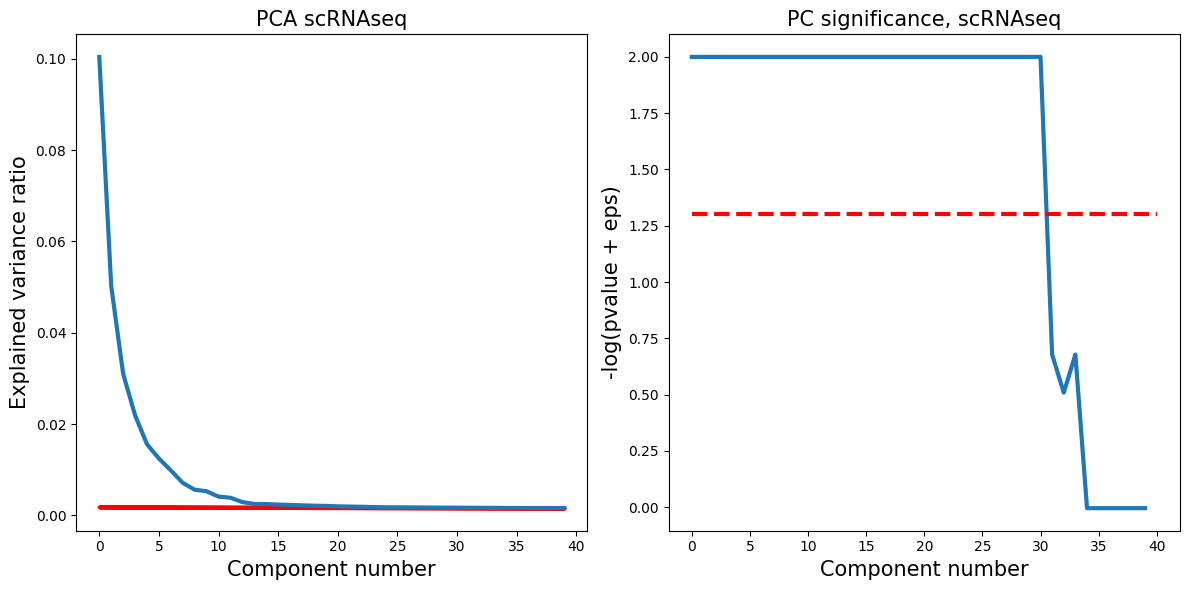

In [ ]:
np.random.seed(42)
pca_analysis(pd.DataFrame(x_train), "scRNAseq", n_replics=10, n_components=40)
plt.show()

Явно видим, что, согласно этому подходу, надо взять 30 компонент.

[[arxiv] 🎓 Permutation methods for factor analysis and PCA](https://arxiv.org/abs/1710.00479) — статья с рассуждениями на тему "Почему это работает?"

### Пример с RNA-Seq — нахождение выбросов

Загрузим данные биологического анализа пациентов с раком и без него.

В данном случае наши данные уже предварительно обработаны, поэтому стандартизацию проводить не будем

In [ ]:
rnadataset = pd.read_table(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/rnaseq_data.tab.txt",
    index_col=0,
    header=None,
)
print("dataset shape: ", rnadataset.shape)

dataset shape:  (358, 71586)


In [ ]:
rnadataset.columns = list(rnadataset.columns[:-2]) + ["dataset", "sample type"]
rnadataset.head()

1         2          3         4         5         6  \
0                                                                          
GSM1296956  13.374975  3.536581  13.644486  3.929925  5.485977  9.363128   
GSM1296957  13.555346  4.772572  14.153843  4.388201  5.412374  9.339831   
GSM1296958  13.396705  4.804828  13.948490  4.395992  5.627752  7.867446   
GSM1296959  13.843843  4.563550  14.390648  4.697154  5.511075  8.943584   
GSM1296960  13.505687  4.750858  14.049400  4.476174  5.753380  8.475744   

                    7         8          9         10  ...      71577  \
0                                                      ...              
GSM1296956  13.134106  4.318162  10.050190  10.605277  ...  11.111910   
GSM1296957  13.789576  4.211175  11.242888  10.518348  ...  10.998240   
GSM1296958  13.424588  4.097212  10.568927  10.666406  ...  10.498048   
GSM1296959  14.181927  4.766994  10.418466  10.924152  ...  10.680012   
GSM1296960  14.255647  4.344796  10.189663  10.651861  ...   9.778142   

               71578      71579     71580      71581     71582     71583  \
0                                                                          
GSM1296956  6.889096  10.636753  6.656603  11.054070  6.914937  8.949687   
GSM1296957  8.220715  10.645032  5.799432  10.951782  5.358962  8.951818   
GSM1296958  8.145627  11.452488  6.164146  11.492929  6.189310  9.091511   
GSM1296959  8.450327  10.966135  6.482977  10.869259  6.683605  9.321499   
GSM1296960  7.615217  10.570247  5.861632  11.168351  6.343246  8.793520   

                71584   dataset  sample type  
0                                             
GSM1296956   8.982860  GSE53622       cancer  
GSM1296957   8.147058  GSE53622       normal  
GSM1296958  10.021106  GSE53622       cancer  
GSM1296959   9.278717  GSE53622       normal  
GSM1296960  11.562505  GSE53622       cancer  

[5 rows x 71586 columns]

In [ ]:
# We remove the dataset and sample type columns from the data frame and
# store the data frame in X
x = rnadataset.drop(labels=["dataset", "sample type"], axis=1)

# We store the dataset and sample type columns in the labels data frame
labels = rnadataset.loc[:, ["dataset", "sample type"]]

In [ ]:
# Finding the top two principal components of the data
pca_decomposer = PCA(n_components=2)
pca_decomposer.fit(x)

PCA(n_components=2)

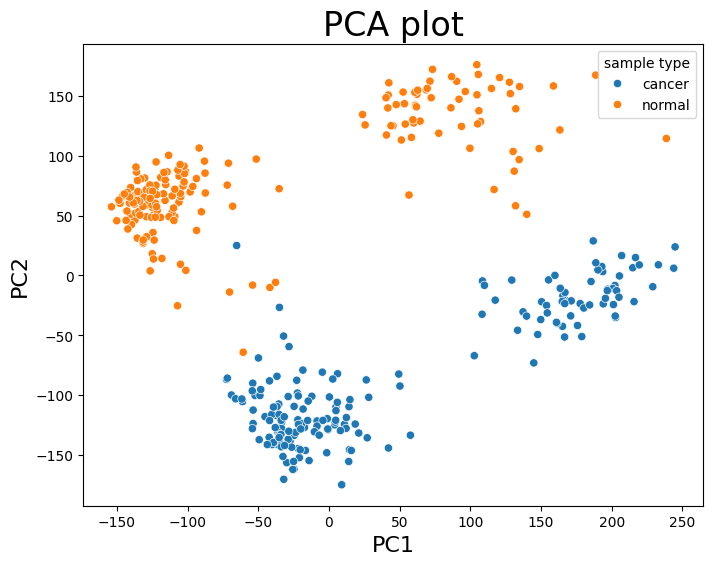

In [ ]:
import seaborn as sns

x_reduced = pca_decomposer.transform(x)

# Display a scatterplot of the transformed dataset
plt.figure(figsize=(8, 6))
plt.title("PCA plot", size=24)
plt.xlabel("PC1", size=16)
plt.ylabel("PC2", size=16)
sns.scatterplot(x=x_reduced[:, 0], y=x_reduced[:, 1], hue=labels["sample type"]);

Даже не понимая, что за признаки у нас в колонках, мы видим несколько интересных вещей.

Во-первых, синяя точка на оранжевой территории и оранжевая на синей — видимо, выбросы.

Кроме этого мы видим, что почему-то у нас есть 4 почти равноудаленных кластера, по два на рак и нормальную ткань

In [ ]:
# Run PCA on the features
x_reduced = pca_decomposer.transform(x)

# Display a scatterplot of the transformed dataset
plt.figure(figsize=(8, 6))
plt.title("PCA plot", size=24)
plt.xlabel("PC1", size=16)
plt.ylabel("PC2", size=16)
sns.scatterplot(
    x=x_reduced[:, 0],
    y=x_reduced[:, 1],
    hue=labels["sample type"],
    style=labels["dataset"],
);

Видим, что в пределах данных одного эксперимента рак и опухоль разделяются хорошо. Но при этом данные между разными экспериментами отличаются так же, как и рак от опухоли.

Этот эффект называется батч-эффектом и говорит о том, что нужно нормализовывать данные в пределах эксперимента каким-то хитрым образом, чтобы научить модель на новых данных отличать рак от нормальной ткани.

Таким образом, с помощью PCA мы нашли выбросы и артефакт в данных.

### Проблемы  PCA




**Интересное направление в данных может не совпадать с направлением максимальной дисперсии.**

Рассмотрим случай выборки, которая сгенерирована из двух вытянутых нормальных распределений, чьи основные оси неортогональны друг другу:

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/problem_pca_2.png" width="600"/>

**Выбранные оси могут не подходить для нашей задачи**

В примере ниже дисперсии не отражают интересующие нас направления в данных:

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/problem_pca_1.png" width="600"/>

В данном случае метод главных компонент будет считать вертикальную компоненту более значимой для описания набора данных, чем горизонтальную.

Но, например, в случае, когда данные из левого и правого кластера относятся к разным классам, для их линейной разделимости вертикальная компонента является шумовой. Несмотря на это, метод главных компонент никогда ее шумовой не признает, и есть вероятность, что отбор признаков с его помощью выкинет из ваших данных значимые для решаемой вами задачи компоненты просто потому, что вдоль них значения имеют низкую дисперсию.

Справляться с такими ситуациями могут некоторые другие методы уменьшения размерности данных, например, метод независимых компонент (Independent Component Analysis, ICA).

#### Недостатки линейного PCA

Также бывают ситуации, когда оптимально спроецировать не на некоторую плоскость, а на многообразие (кривая плоскость), как показано на картинке ниже.

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/s_manifold.png" width="650"/>

В данном случае оптимально спроецировать на S-образную кривую.



## Kernel PCA (нелинейный) метод главных компонент

Как уже упоминалось, иногда невозможно захватить всю информацию линейной проекцией, хотя кривая поверхность с такой же размерностью это позволяет сделать. Одним из подходов к решению данной проблемы является задача перевода признаков в нелинейное пространство.

### Kernel trick

Kernel Trick избегает явного перевода наших признаков в пространство новых признаков, ведь пространства бывают очень большие, а нам бы хотелось сэкономить память компьютера.
Оказывается, для PCA не важны собственно признаки объектов, а важны скалярные произведения между объектами.

И это скалярное произведением позволяет подсчитывать напрямую функция $k(\mathbf {x} ,\mathbf {x'})$, которую часто называют *ядром или ядерной функцией (kernel, kernel function)*

Бывают разные ядра, которые считают скалярное произведение в разных пространствах


* $\large \displaystyle k(x_i, x_j) = \frac{1}{z} e^{-\frac{h(x_i, x_j)^2}{h}}$ — радиальная базисная функция (RBF)
* $\large k(x_i, x_j) = (<x_i, x_j> + c)^d; c, d \in \mathbb{R}$ — полиномиальное ядро
* $\large k(x_i, x_j) = \sigma((<x_i, x_j>)$ — ядро с функцией активации


Рассмотрим на примере:

In [ ]:
# https://scikit-learn.org/stable/auto_examples/decomposition/plot_kernel_pca.html
from sklearn.datasets import make_circles

np.random.seed(42)
x, y = make_circles(n_samples=400, factor=0.3, noise=0.05, random_state=42)

Возьмем две концентрические окружности

In [ ]:
plt.figure(figsize=(5, 5))

plt.title("Original space")

class_0 = y == 0
class_1 = y == 1

sns.scatterplot(x=x[class_0, 0], y=x[class_0, 1], color="orange", s=30, label="Class 0")
sns.scatterplot(
    x=x[class_1, 0], y=x[class_1, 1], color="#27a9e1", s=30, label="Class 1"
)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()

Обычный PCA не может их разделить

In [ ]:
pca = PCA()
x_pca = pca.fit_transform(x)
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=x_pca[class_0, 0], y=x_pca[class_0, 1], color="orange", s=30, label="Class 0"
)
sns.scatterplot(
    x=x_pca[class_1, 0], y=x_pca[class_1, 1], color="#27a9e1", s=30, label="Class 1"
)
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")
plt.show()

А вот KernelPCA  справляется

In [ ]:
from sklearn.decomposition import KernelPCA

kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10)
x_kpca = kpca.fit_transform(x)

plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=x_kpca[class_0, 0], y=x_kpca[class_0, 1], color="orange", s=30, label="Class 0"
)
sns.scatterplot(
    x=x_kpca[class_1, 0], y=x_kpca[class_1, 1], color="#27a9e1", s=30, label="Class 1"
)
plt.title("Projection by KPCA")
plt.xlabel(r"1st principal component in space induced by $\phi$")
plt.ylabel("2nd component")
plt.show()

Хотя, конечно, и восстанавливать он будет не идеально: работал-то он в пространстве бОльшей размерности и оси строил там.

In [ ]:
# 1. The 'kpca' variable is a KernelPCA object that is initialized with 'n_components' set to 2.
# 2. Then it applies the kernel function specified in the 'kernel' variable  and then transforms the data based on the kernel, and gets the transformed data.
# 3. Then it returns the transformed data.
# 4. Then we get the inverse transformation by simply calling "kpca.inverse_transform(x_kpca)"
# 5. Finally, we plot the transformed data.

x_back = kpca.inverse_transform(x_kpca)
plt.figure(figsize=(5, 5))
sns.scatterplot(
    x=x_back[class_0, 0], y=x_back[class_0, 1], color="orange", s=30, label="Class 0"
)
sns.scatterplot(
    x=x_back[class_1, 0], y=x_back[class_1, 1], color="#27a9e1", s=30, label="Class 1"
)
plt.title("Original space after inverse transform")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

plt.tight_layout()
plt.show()

Kernel PCA довольно чувствителен к выбору ядра.

К примеру, для данных, расположенных на трех окружностях:

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/kernel_pca_three_circles.png" width="260"/>

в зависимости от выбора ядра мы будем получать совершенно разные отображение в спрямляющее пространство:

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/kernel_pca_different_kernels.png" width="600"/>

В связи с вышеописанными случаями, ниже мы рассмотрим более сильные методы.

Существуют и другие методы понижения размерности в данных. К примеру, t-SNE и UMAP.

Они немного иначе решают поставленную задачу: из пространства новой размерности мы не должны легко переходить в прежнее пространство. Взамен этого требуется, чтобы сохранялись расстояния между объектами. Причем, особое внимание уделяется расстояниям между близкими объектами. При этом расстояния между далекими объектами могут не сохраняться.

## t-SNE (t-distributed Stochastic Neighbor Embedding)

Идея состоит в том, чтобы не напрямую максимизировать дисперсию, а найти такое пространство, в котором расстояние между объектами будет сохраняться или по крайне мере не сильно меняться.

При этом будем больше беспокоиться о расстоянии между близкими объектами, нежели о расстоянии между далекими.

Рассмотрим алгоритм пошагово:

**Шаг 1:** Вычисляем матрицу попарных сходств объектов в пространстве исходной размерности. Затем преобразуем попарные сходства в условные вероятности.

Получаем, что объекты, считающиеся близкими в пространстве высокой размерности, имеют более высокую условную вероятность быть соседями и в пространстве низкой размерности.

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/tsne_get_distance_matrix.png" width="650"/>

**Шаг 2:** Иициализируем начальное положение объектов в пространстве низкой размерности. Так как мы сгенирировали его случайно, видим, что они сильно отличаются.


<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/tsne_two_matrix_distance.png" width="600"/>

**Шаг 3:** Оптимизация. Осталось только привести сгенерированную матрицу к исходной. Делаем это с помощью градиентного спуска, минимизируя функцию потерь [дивергенцию Кульбака — Лейблера 📚[wiki]](https://ru.wikipedia.org/wiki/%D0%A0%D0%B0%D1%81%D1%81%D1%82%D0%BE%D1%8F%D0%BD%D0%B8%D0%B5_%D0%9A%D1%83%D0%BB%D1%8C%D0%B1%D0%B0%D0%BA%D0%B0_%E2%80%94_%D0%9B%D0%B5%D0%B9%D0%B1%D0%BB%D0%B5%D1%80%D0%B0):

$$KL(P||Q) = \sum_{i \neq j}{p_{ij} log \frac{p_{ij}}{q_{ij}}},$$

где:

$p_{ij}$ — условная вероятность близости между объектами $i$ и $j$ в пространстве исходной размерности

$q_{ij}$ — условная вероятность близости между объектами $i$ и $j$ в пространстве низкой размерности

В итоге мы хотим получить такое представление, чтобы объекты, которые находились близко в исходном пространстве, **наиболее вероятно** находились близко и в новом представлении.

**Физическая аналогия:**

Представьте себе комнату, в которой в воздухе висят шарики (наши объекты), которые соединены недеформированными пружинками, и время заморожено. Мы хотим из 3-мерного пространства (шарики в объеме комнаты), сделать представление в 2-мерном (шарики лежат на полу).

Если разморозить время, шарики упадут на пол. Тогда пружинки начнут стягивать шарики, которые были близки, и отталкивать шарики, которые упали близко, но были далеки. После того, как все шарики прекратят движение по полу и система из связанных шариков окажется в состоянии покоя, распределение расстояний между шариками на плоскости будет приближением для исходного распределения расстояний в объеме комнаты. Эта физическая аналогия показывает то, что происходит при минимизации дивергенции Кульбака — Лейблера.

Можем увидеть такой эффект на демонстрации:

In [ ]:
# source: https://bost.ocks.org/mike/
from IPython.display import HTML

!wget -qN https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L04/tSNE.html

HTML(filename="./tSNE.html")

### Пример применения

Мы будем применять t-SNE не на исходных данных, а на 9-ти первых компонентах PCA. Для того, чтобы t-SNE сходился лучше, в качестве изначальных координат точек в новом пространстве можно использовать не случайный шум, а первые две компоненты PCA.

Преследуем две цели: уменьшить время работы t-SNE (который работает очень медленно) и убрать эффект шума на t-SNE — он может на него реагировать, особенно при условии, что схождения к минимуму мы можем не дождаться.



[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 8617 samples in 0.047s...
[t-SNE] Computed neighbors for 8617 samples in 4.321s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8617
[t-SNE] Computed conditional probabilities for sample 2000 / 8617
[t-SNE] Computed conditional probabilities for sample 3000 / 8617
[t-SNE] Computed conditional probabilities for sample 4000 / 8617
[t-SNE] Computed conditional probabilities for sample 5000 / 8617
[t-SNE] Computed conditional probabilities for sample 6000 / 8617
[t-SNE] Computed conditional probabilities for sample 7000 / 8617
[t-SNE] Computed conditional probabilities for sample 8000 / 8617
[t-SNE] Computed conditional probabilities for sample 8617 / 8617
[t-SNE] Mean sigma: 0.412418
[t-SNE] Computed conditional probabilities in 2.502s
[t-SNE] Iteration 50: error = 73.7138214, gradient norm = 0.0086984 (50 iterations in 18.936s)
[t-SNE] Iteration 100: error = 73.3175049, gradient norm = 0.0022528 (50 iterations in 

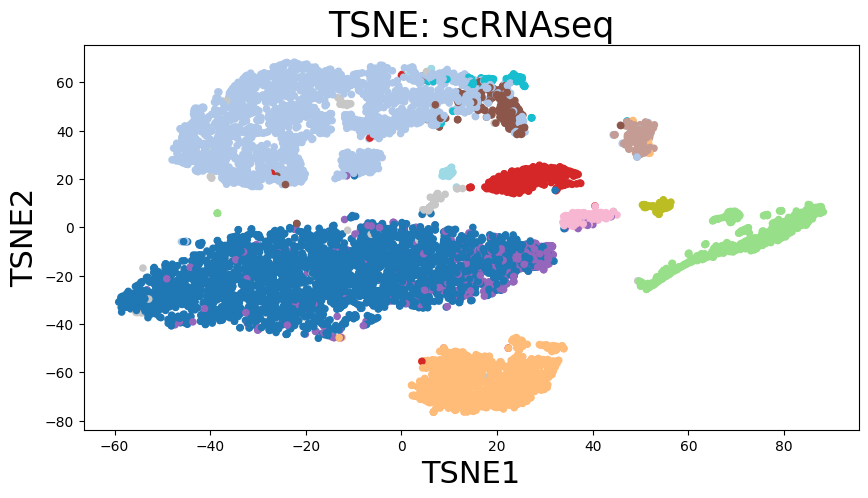

In [ ]:
from sklearn import manifold

# 1. Firstly we reduce the dimensionality of the data to 6 features using PCA.
# 2. Then we take the first two PCA components and use this
#    as an initial approximation for the T-SNE algorithm.
# 3. Then we fit T-SNE on the data and plot the first two dimensions
#    of the T-SNE output, which are represented in green.
# 4. The visualization makes clear that there are distinct clusters in our data


scRNAseq = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/scRNAseq_CITEseq.txt",
    sep="\t",
)

x = scRNAseq.iloc[:, 0:-1]  # features
y = scRNAseq.iloc[:, -1]  # labels

# taking the log of the data.
x = np.log(x + 1)

x_reduced = PCA(n_components=9).fit_transform(x)

model = manifold.TSNE(
    n_components=2,
    init=x_reduced[:, 0:2],  # often use as a reasonable approximation
    perplexity=40,  # important parameter
    verbose=2,
    learning_rate="auto",
)

manifold = model.fit_transform(x_reduced)

plt.figure(figsize=(10, 5))
plt.scatter(manifold[:, 0], manifold[:, 1], c=y, cmap="tab20", s=20)
plt.title("TSNE: scRNAseq", fontsize=25)
plt.xlabel("TSNE1", fontsize=22)
plt.ylabel("TSNE2", fontsize=22)
plt.show()



И покрасим по разметке, которая нам известна из эксперимента. Видим, что разделение очень хорошее.

In [ ]:
!pip install ivis --upgrade


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552450 sha256=77792a6c91cb5be52f4432d6e1305ba839e60aba0ee89bbc468193144c9ba40e
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


In [ ]:
from sklearn import manifold
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
from sklearn.decomposition import PCA

# 1. Firstly we reduce the dimensionality of the data to 6 features using PCA.
# 2. Then we take the first two PCA components and use this
#    as an initial approximation for the T-SNE algorithm.
# 3. Then we fit T-SNE on the data and plot the first two dimensions
#    of the T-SNE output, which are represented in green.
# 4. The visualization makes clear that there are distinct clusters in our data


scRNAseq = pd.read_csv(
    "https://edunet.kea.su/repo/EduNet-web_dependencies/datasets/scRNAseq_CITEseq.txt",
    sep="\t",
)

x = scRNAseq.iloc[:, 0:-1]  # features
y = scRNAseq.iloc[:, -1]  # labels

# taking the log of the data.
x = np.log(x + 1)

x_reduced = PCA().fit_transform(x)


In [ ]:
from ivis import Ivis

model = Ivis(embedding_dims=2, k=100)

embeddings = model.fit_transform(x_reduced)

Building KNN index


100%|██████████| 8617/8617 [00:01<00:00, 8120.39it/s]


Extracting KNN neighbours


100%|██████████| 8617/8617 [00:07<00:00, 1143.79it/s]


Training neural network
Epoch 1/1000
68/68 [==============================] - 2s 16ms/step - loss: 0.5441
Epoch 2/1000
68/68 [==============================] - 1s 16ms/step - loss: 0.3312
Epoch 3/1000
68/68 [==============================] - 1s 16ms/step - loss: 0.2865
Epoch 4/1000
68/68 [==============================] - 1s 15ms/step - loss: 0.2657
Epoch 5/1000
68/68 [==============================] - 2s 23ms/step - loss: 0.2496
Epoch 6/1000
68/68 [==============================] - 1s 16ms/step - loss: 0.2326
Epoch 7/1000
68/68 [==============================] - 1s 16ms/step - loss: 0.2135
Epoch 8/1000
68/68 [==============================] - 1s 16ms/step - loss: 0.2130
Epoch 9/1000
68/68 [==============================] - 1s 16ms/step - loss: 0.2143
Epoch 10/1000
68/68 [==============================] - 1s 16ms/step - loss: 0.2061
Epoch 11/1000
68/68 [==============================] - 1s 16ms/step - loss: 0.1939
Epoch 12/1000
68/68 [==============================] - 1s 16ms/step - lo

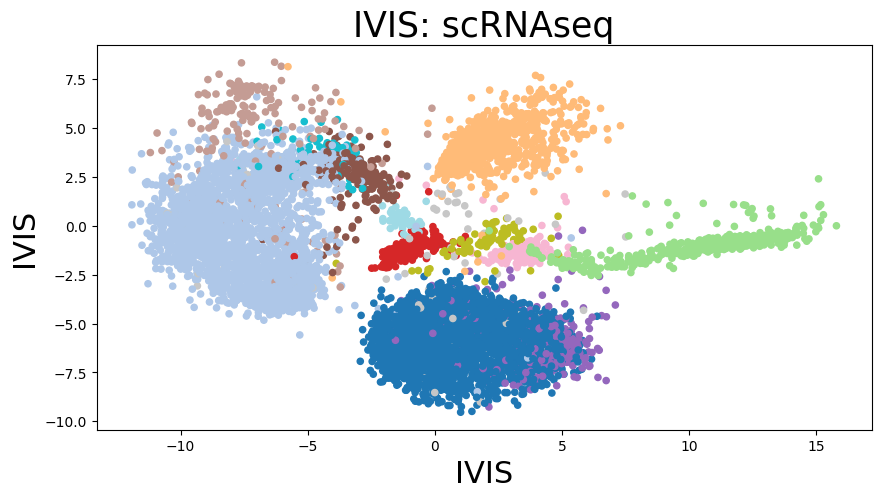

In [ ]:


plt.figure(figsize=(10, 5))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y, cmap="tab20", s=20)
plt.title("IVIS: scRNAseq", fontsize=25)
plt.xlabel("IVIS", fontsize=22)
plt.ylabel("IVIS", fontsize=22)
plt.show()

### Важные параметры t-SNE



`perplexity` — чем больше **perplexity**, тем более глобально мы смотрим на структуру.

`metric` — как считаются расстояния между точками — **metric**. По умолчанию используется евклидово расстояние, но часто помогают и другие (например, косинусное).

`learning_rate` — шаг градиентного спуска, тоже влияет на полученное представление.

### Проблемы t-SNE




* **Стохастичность**

Низкоразмерное представление, которое вы получите, будет отличаться между
запусками, если не зафиксировать **random seed**. Может отличаться довольно сильно.

* **Добавление новых точек**

Если у вас появились новые данные, то добавить их на  представление, полученное при помощи t-SNE ранее — нетривиальная задача.
Для разных областей есть свои "подгоны", но все это эвристика.

* **Расстояния не отражают реальную структуру**

Расстояния между кластерами точек могут ничего не значить (плохо сохраняются далекие расстояния):

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/tsne_problems_distances_between_clusters_no_matter.png" width="1000"/>

* **Искажение размера кластеров**

Размеры кластеров ничего не значат и могут сильно отличаться от исходных:

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/tsne_problems_cluster_size_no_matter.png" width="1000"/>

* **Искажение структуры**

Можно увидеть не ту структуру, которая по идее должна быть:

<img src="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/tsne_problems_erroneous_structure.png" width="1000"/>

[[demo] 🎮 How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)





Из-за указанных  недостатков результат t-SNE нужно с осторожностью использовать для кластеризации.



[[video] 📺 StatQuest: t-SNE, Clearly Explained](https://www.youtube.com/watch?v=NEaUSP4YerM)

[[article] 🎓 The art of using t-SNE for single-cell transcriptomics](https://www.nature.com/articles/s41467-019-13056-x) — cтатья по применению t-SNE в биологии

## UMAP



UMAP — uniform manifold approximation and projection.

[[doc] 🛠️ How UMAP Works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)

[[video] 📺 scRNA-seq: Dimension reduction (PCA, tSNE, UMAP)](https://www.youtube.com/watch?v=94ZMJ8tq1Wk)

[[demo] 🎮 Understanding UMAP](https://pair-code.github.io/understanding-umap/)

Использует похожую на t-SNE идею, но иначе, в результате чего получает много выгодных бонусов.

Внутри себя метод строит граф, в котором ребрами соединены между собой $k$ ближайших соседей. При этом эти ребра неравноправны: если для данной пары точек расстояние между ними сильно больше, чем расстояния между ними и другими точками, то и ребро будет иметь маленький вес.

<img src ="https://edunet.kea.su/repo/EduNet-content/dev-2.0/L04/out/umap.png" width="800">

Далее задача состоит в том, чтобы в пространстве более низкой размерности получился граф, похожий на тот, который был в пространстве высокой размерности.
Для этого оптимизируем низкоразмерное представление градиентным спуском.

### Пример применения

In [ ]:
from IPython.display import clear_output

!pip install -q umap-learn
!pip install -q --upgrade tbb
clear_output()

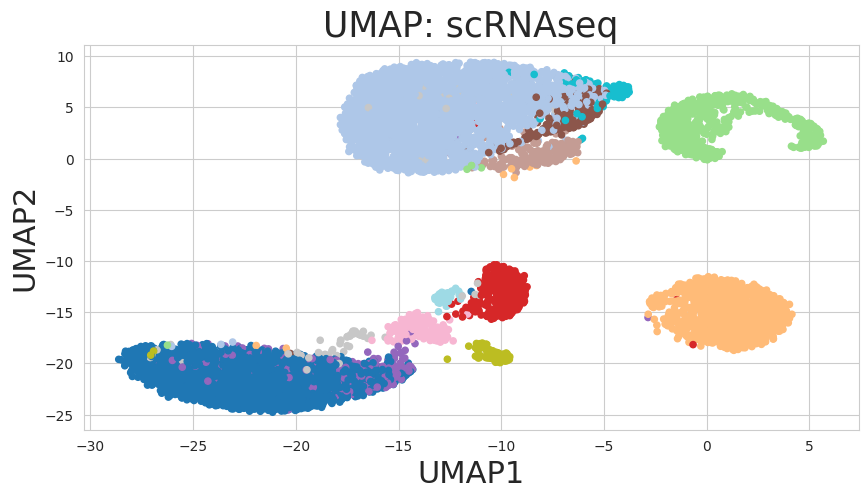

In [ ]:
from umap import UMAP

# Converts the original expression matrix (scRNAseq) into a 9-dimensional PCA space
x_reduced = PCA(n_components=9).fit_transform(x)  # x_scRNAseq

# Initializes UMAP with the PCA components
model = UMAP(
    n_components=2,
    min_dist=1,
    n_neighbors=93,
    init=x_reduced[:, 0:2],
    # it is recommended to use the first two components of PCA for initialization of UMAP and t-SNE
    n_epochs=1000,
    verbose=2,
)

# Runs the UMAP algorithm on the PCA transformed data
umap = model.fit_transform(x_reduced)
clear_output()
# Plots the results of the UMAP transformation
plt.figure(figsize=(10, 5))
plt.scatter(umap[:, 0], umap[:, 1], c=y, cmap="tab20", s=20)
plt.title("UMAP: scRNAseq", fontsize=25)
plt.xlabel("UMAP1", fontsize=22)
plt.ylabel("UMAP2", fontsize=22)
plt.show()

### Важные параметры UMAP



`n_neighbors` — число соседей, которые ищутся для каждой точки. Влияет на то, насколько глобально мы смотрим на структуру данных.


`min_dist` — влияет на то, насколько близко могут находиться между собой точки в новом представлении.

`metric` — определяет, как считаются расстояния между точками. По умолчанию Евклидово расстояние, но это не всегда дает лучший результат.

### Преимущества перед t-SNE



* **Скорость работы**

Выдает результаты, похожие на t-SNE, но  работает в разы быстрее

<center><img src="https://edunet.kea.su/repo/EduNet-web_dependencies/dev-2.0/L04/umap_tsne_performance.png" width="450"/></center>

<center><em>Source: <a href="https://umap-learn.readthedocs.io/en/latest/performance.html">Performance Comparison of Dimension Reduction Implementations</a></em></center>

* **Возможность проецировать новые точки**

UMAP может проецировать точки из новых датасетов на уже имеющееся представление.



* **Может объединять представления**

Если у вас есть признаки, сильно отличающиеся по своим свойствам, то можно построить для них представления отдельно с разными метриками, а далее объединить их.




* **Более интуитивные параметры**

Параметры `n_neighbours` и `min_dist` намного понятнее их аналога — `perplexity`.

* **Можно использовать для отображения и в пространства бо́льшей размерности**

Кроме того, его можно использовать для понижения размерности не только до 2-3 (в целях визуализации), но и для больших размерностей, с которыми потом работать другими методами (хотя здесь надо быть аккуратным, он тоже склонен деформировать дальние расстояния)

* **Расстояния более информативны**

Плохая идея — интерпретировать расстояния между кластерами и их размеры для 2D представлений.

Но в случае UMAP это менее выражено.





Если же отображать в пространство размерности большей, чем два, то можно получить и очень хорошие представления. Но это все эвристика, может и не повезти.

* **Supervised UMAP**

UMAP позволяет передать в него метки объектов — вы можете получать представление, которое оптимизировано под имеющуюся у вас информацию о кластерах.

* **Semi-Supervised UMAP**

UMAP позволяет передать в него метки **только для части** объектов — вы можете получать представление, которое оптимизировано под имеющуюся у вас информацию о кластерах, но при этом не оставляет без внимания объекты без меток.

### Понижение размерности для улучшения качества кластеризации

Методы понижения размерности, такие как UMAP и t-SNE, могут быть использованы как эффективный метод предобработки данных для последующей передачи в [алгоритмы кластеризации на основе плотности 📚[wiki]](https://en.wikipedia.org/wiki/DBSCAN). Данные методы понижения размерности не полностью сохраняют информацию о плотности распределения объектов при осуществлении проекции в низкоразмерное пространство, поэтому следует относиться к такой предобработке с некоторой осторожностью (рекомендуем ознакомиться с [Clustering on the output of t-SNE ✏️[blog]](https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne) на  stackexchange). Несмотря на эти опасения, все же есть веские причины для использования данных методов понижения размерности в качестве этапа предварительной обработки для кластеризации. Как и при любом подходе к кластеризации, необходимо провести исследование и оценку полученных кластеров, чтобы попытаться валидировать разбиение на них, если это возможно.

Загрузим датасет с одноканальными $8 \times 8$ изображениями рукописных цифр:

In [ ]:
from sklearn import datasets

digits = datasets.load_digits(n_class=10)
x = digits.data
y = digits.target
n_samples, n_features = x.shape
print(x.shape)

(1797, 64)


In [ ]:
from ivis import Ivis

model = Ivis(embedding_dims=2, k=50)

embeddings = model.fit_transform(x)

Building KNN index


100%|██████████| 1797/1797 [00:00<00:00, 103950.85it/s]


Extracting KNN neighbours


100%|██████████| 1797/1797 [00:00<00:00, 4413.19it/s]


Training neural network
Epoch 1/1000
15/15 [==============================] - 1s 9ms/step - loss: 1.0094
Epoch 2/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.5325
Epoch 3/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.3374
Epoch 4/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.3698
Epoch 5/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.3408
Epoch 6/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.3746
Epoch 7/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.3303
Epoch 8/1000
15/15 [==============================] - 0s 9ms/step - loss: 0.2857
Epoch 9/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.2703
Epoch 10/1000
15/15 [==============================] - 0s 8ms/step - loss: 0.1983
Epoch 11/1000
15/15 [==============================] - 0s 15ms/step - loss: 0.2435
Epoch 12/1000
15/15 [==============================] - 0s 17ms/step - loss: 0.2490

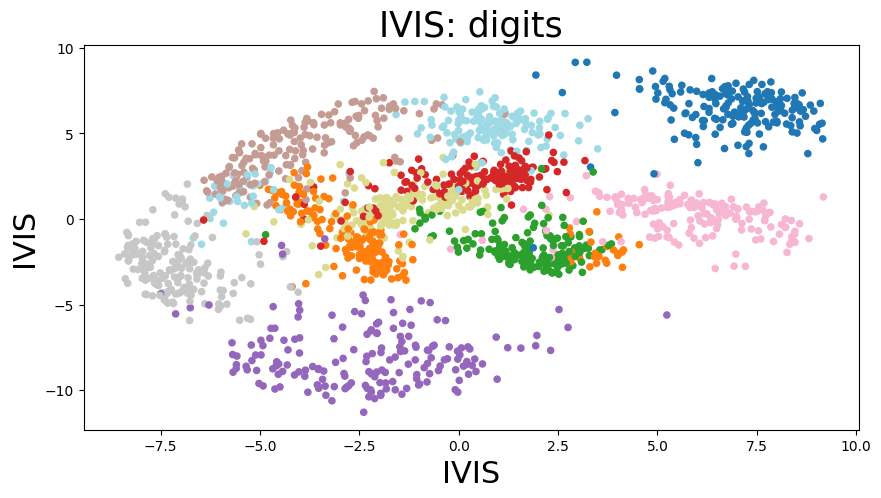

In [ ]:
plt.figure(figsize=(10, 5))
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=y, cmap="tab20", s=20)
plt.title("IVIS: digits", fontsize=25)
plt.xlabel("IVIS", fontsize=22)
plt.ylabel("IVIS", fontsize=22)
plt.show()

Понизим размерность данных $64 \rightarrow 2$ при помощи t-SNE:

In [ ]:
from sklearn import manifold


# t-SNE embedding of the digits dataset
tsne = manifold.TSNE(n_components=2, init="pca", random_state=42, learning_rate="auto")
x_tsne = tsne.fit_transform(x)

Понизим размерность данных $64 \rightarrow 2$ при помощи UMAP:

In [ ]:
umap = UMAP(n_neighbors=5)
x_umap = umap.fit_transform(x)

Визуализируем результаты:

In [ ]:
from matplotlib import offsetbox


def plot_embedding(x, title=None):
    x_min, x_max = np.min(x, 0), np.max(x, 0)
    x = (x - x_min) / (x_max - x_min)  # normalization of x to (0..1) range

    plt.figure()
    ax = plt.subplot(111)
    for i in range(x.shape[0]):
        plt.text(
            x[i, 0],
            x[i, 1],
            str(y[i]),
            color=plt.cm.Set1(y[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )

    if hasattr(offsetbox, "AnnotationBbox"):
        # only print thumbnails with matplotlib > 1.0
        shown_imgs = np.array([[1.0, 1.0]])  # just something big
        for i in range(x.shape[0]):
            dist = np.sum((x[i] - shown_imgs) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_imgs = np.r_[shown_imgs, [x[i]]]
            img_box = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r), x[i]
            )
            ax.add_artist(img_box)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(x.shape[0]):
        plt.text(
            x[i, 0],
            x[i, 1],
            str(y[i]),
            color=plt.cm.Set1(y[i] / 10.0),
            fontdict={"weight": "bold", "size": 9},
        )
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

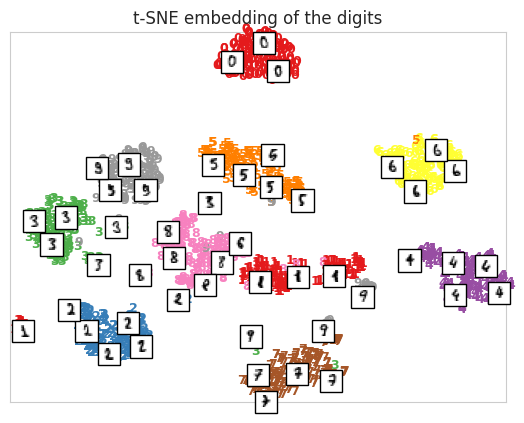

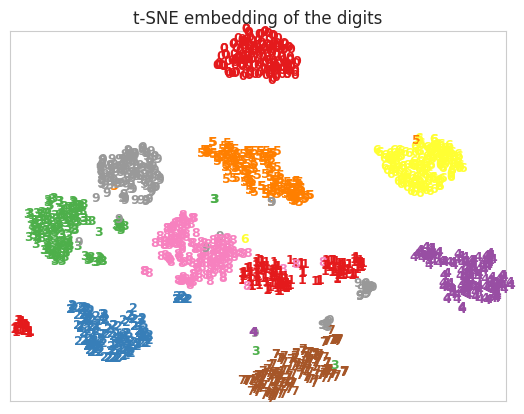

In [ ]:
# t-SNE embedding of the digits dataset
plot_embedding(x_tsne, "t-SNE embedding of the digits")

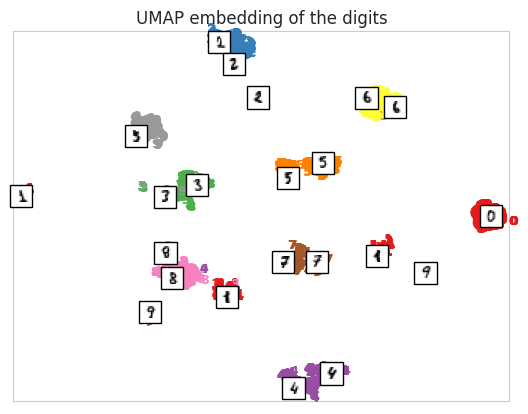

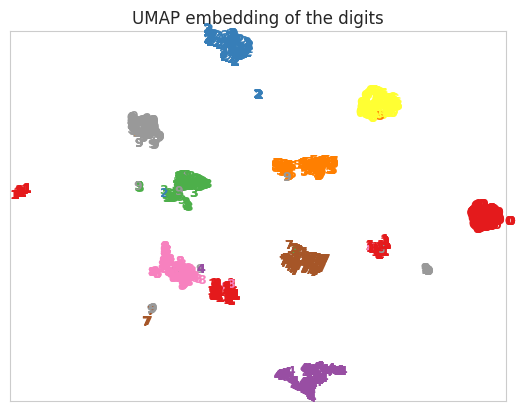

In [ ]:
# UMAP embedding of the digits
plot_embedding(x_umap, "UMAP embedding of the digits")

Как нетрудно заметить, при использовании UMAP точки из датасета при проекции в низкоразмерное пространство оказались расположены более "кучно", нежели чем при использовании t-SNE.

Теперь попробуем кластеризовать наши данные при помощи K-Means. Для оценки качества воспользуемся стандартными метриками `adjusted_rand_score` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html) и `adjusted_mutual_info_score` [🛠️[doc]](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_mutual_info_score.html) из `sklearn.metrics`.

In [ ]:
import sklearn.cluster as cluster

kmeans_labels_on_raw = cluster.KMeans(n_clusters=10, n_init="auto").fit_predict(x)

In [ ]:
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


def plot_clustering_metrics(true_l, pled_l, title):
    ari = adjusted_rand_score(true_l, pled_l)
    ami = adjusted_mutual_info_score(true_l, pled_l)
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    plt.title(f"Clustering metrics for {title}\n\n 1.0 is best")
    width = 0.75
    ind = np.arange(2)
    ax.barh(ind, [ari, ami], width)
    ax.grid(axis="x")
    ax.set_xlim([0, 1.0])
    for i, v in enumerate([ari, ami]):
        ax.text(v + 0.01, i, f"{v:1.2f}", color="black")
    ax.set_yticks(ind)
    ax.set_yticklabels(["ARI", "AMI"], minor=False)
    plt.show()

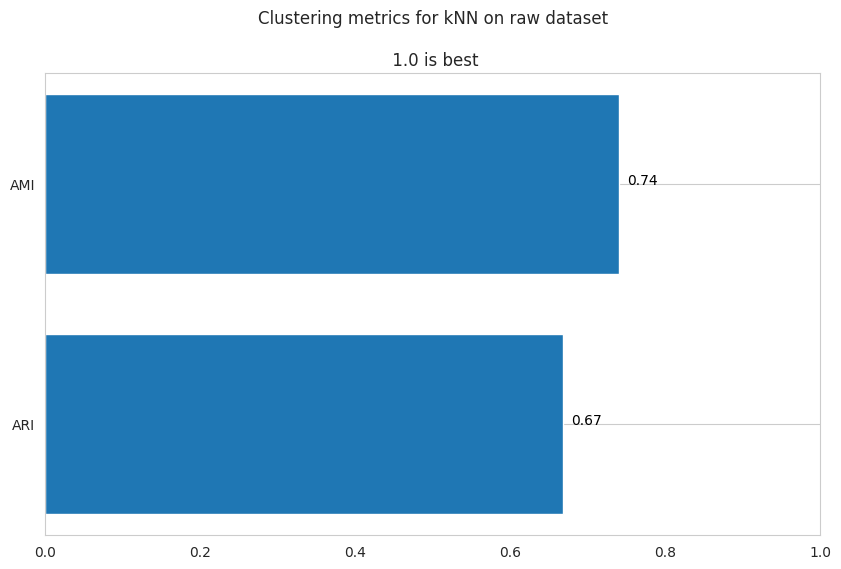

In [ ]:
plot_clustering_metrics(y, kmeans_labels_on_raw, "kNN on raw dataset")

Теперь передадим K-Means данные после понижения размерности:

In [ ]:
kmeans_labels_on_x_tsne = cluster.KMeans(n_clusters=10, n_init="auto").fit_predict(
    x_tsne
)
kmeans_labels_on_x_umap = cluster.KMeans(n_clusters=10, n_init="auto").fit_predict(
    x_umap
)

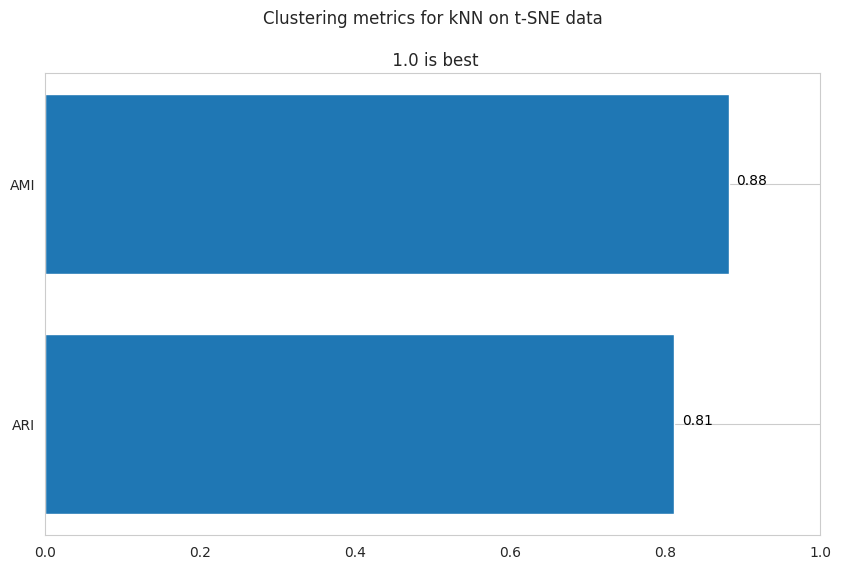

In [ ]:
plot_clustering_metrics(y, kmeans_labels_on_x_tsne, "kNN on t-SNE data")

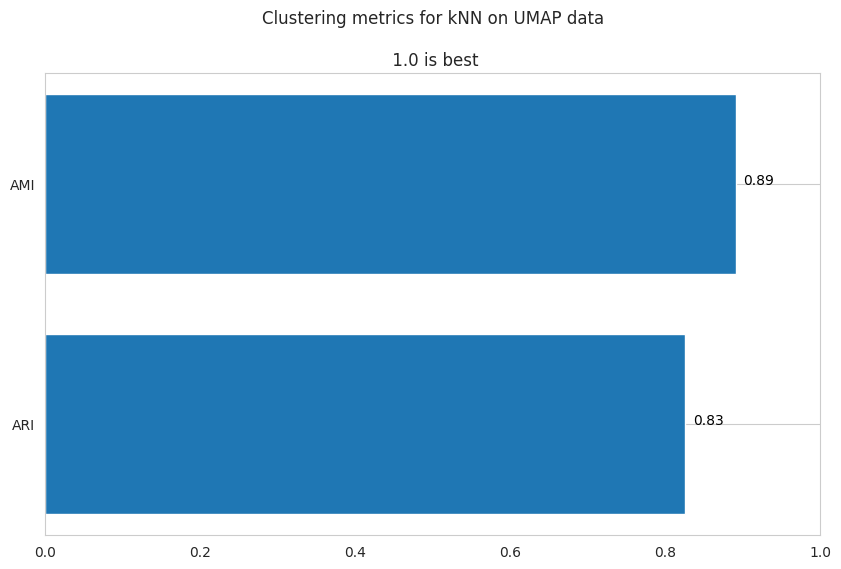

In [ ]:
plot_clustering_metrics(y, kmeans_labels_on_x_umap, "kNN on UMAP data")

Применяя методы понижения размерности на этапе предобработки данных, нам удалось значительно улучшить качество кластеризации. Использование UMAP в разобранном нами примере позволило достичь лучших результатов по сравнению с t-SNE и получить прирост практически в 20% относительно метрик качества кластеризации.

<font size=6>Литература</font>

<font size=5>Проблемы при работе с реальными данными:</font>
* [[blog] ✏️ SMOTE for Imbalanced Classification with Python](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)
* [[article] 🎓 Support Vector Method for Novelty Detection ](https://proceedings.neurips.cc/paper/1999/file/8725fb777f25776ffa9076e44fcfd776-Paper.pdf)

<font size=5>Кластеризация:</font>

* [[demo] 🎮 Visualizing K-Means Clustering](https://www.naftaliharris.com/blog/visualizing-k-means-clustering/)
* [[blog] ✏️ Подробнее про DBSCAN](https://habr.com/ru/post/322034/)
* [[demo] 🎮 Visualizing DBSCAN Clustering](https://www.naftaliharris.com/blog/visualizing-dbscan-clustering/)

<font size=5>Кодирование признаков:</font>

* [[book] 📚 Real-World Machine Learning](https://www.manning.com/books/real-world-machine-learning)
* [[git] 🐾 Real-World Machine Learning](https://github.com/brinkar/real-world-machine-learning)
* [[blog] ✏️ Think twice before dropping that first one-hot encoded column](https://inmachineswetrust.com/posts/drop-first-columns/)

<font size=5>Разведочный анализ данных:</font>
* [[book] 📚Устраняем мультиколлинеарность признаков в ML при помощи графов](https://habr.com/ru/companies/akbarsdigital/articles/592493/)
* [[git] 🐾 Пример EDA](https://github.com/WillKoehrsen/machine-learning-project-walkthrough/blob/master/Machine%20Learning%20Project%20Part%201.ipynb)
* [[blog] ✏️ Примеры графиков matplotlib](https://habr.com/ru/articles/468295/)
* [[video] 📺 Курс лекций с разбором практических задач с применением EDA](https://www.youtube.com/watch?v=FNDQYM0hjh0&list=PLaRUeIuewv8CMFox0oEjlyePUhUmo-x0h)

<font size=5>Генерация признаков:</font>
* [[colab] 🥨 Генерация признаков с использованием RandomForest и GradientBoosting ](https://colab.research.google.com/drive/1pVRkaTksyXqbdpfYvTSFuq9rlH2KVSmB#scrollTo=VaJ-_qIqbkPN)

<font size=5>Отбор признаков:</font>
* [[blog] ✏️ Automated feature selection with boruta](https://www.kaggle.com/code/residentmario/automated-feature-selection-with-boruta)
* [[doc] 🛠️ Feature selection](https://scikit-learn.org/stable/modules/feature_selection.html)
* [[doc] 🛠️ Model-based and sequential feature selection](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py)
* [[blog] ✏️ Sequential Feature Selection for Regression](http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/#example-5-sequential-feature-selection-for-regression)
* [[colab] 🥨 Эксперимент с неправильным отбором признаков](https://colab.research.google.com/drive/1nn8o--hy2siBqTKRowmW0cdD6Skh7-rY)

<font size=5>Задача понижения размерности:</font>
* [[arxiv] 🎓 Permutation methods for factor analysis and PCA](https://arxiv.org/abs/1710.00479)
* [[demo] 🎮 How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)
[[video] 📺 StatQuest: t-SNE, Clearly Explained](https://www.youtube.com/watch?v=NEaUSP4YerM)
* [[article] 🎓 The art of using t-SNE for single-cell transcriptomics](https://www.nature.com/articles/s41467-019-13056-x)

* [[video] 📺 scRNA-seq: Dimension reduction (PCA, tSNE, UMAP)](https://www.youtube.com/watch?v=94ZMJ8tq1Wk)
* [[demo] 🎮 Understanding UMAP](https://pair-code.github.io/understanding-umap/)

<font size=5>Дополнительно:</font>
* [[book] 📚 Feature Selection for High-Dimensional Data](https://www.springer.com/gp/book/9783319218571)
* [[book] 📚 Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists Paperback](https://books.google.ru/books/about/Feature_Engineering_for_Machine_Learning.html?id=Ho0UvgAACAAJ&redir_esc=y)
* [[blog] ✏️ Handling Cyclical Features](http://blog.davidkaleko.com/feature-engineering-cyclical-features.html) — про кодирование циклических признаков Feature Engineering
* [[blog] ✏️ How to Win a Data Science Competition: Learn from Top Kagglers](https://blog.coursera.org/learn-top-kagglers-win-data-science-competition/)
* [[article] 🎓 A Few Useful Things to Know About Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
* [[blog] ✏️ Сайт](https://dyakonov.org/) и [курс 🐾[git]](https://github.com/Dyakonov/PZAD) Дьяконова
